#專題資料結構
```
Project: DeepX
└─ original_dataset
   ├─ abnormal
   │   └─ abnormal_label
   │   └─ abnormal(.dcm)
   │   └─ abnormal(.jpg)
   ├─ normal
   │   └─ normal_label
   │   └─ normal(.dcm)
   │   └─ normal(.jpg)
└─ yolov8_custom
└─ processed_dataset
   ├─ abnormal
   ├─ normal
└─ all_data
└─ splitted_dataset
   ├─ test
   │   └─ abnormal
   │   └─ normal
   ├─ train
   │   └─ abnormal
   │   └─ normal
   ├─ train_argumentation
   │   └─ abnormal
   │   └─ normal
└─ tensor
   ├─ test
   ├─ train
└─ result
```

#連結Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Deep_X_torch') #切換目錄
os.listdir() #確認目錄內容

['SEResNet.py',
 'splitted_dataset',
 '__pycache__',
 'tensor',
 'processed_dataset',
 'original_dataset',
 'yolov8_custom',
 'all_data',
 'result_resnet152',
 'result_seresnet152',
 'Deep_X_torch_main.ipynb']

#將DCM檔轉成JPG檔

In [ ]:
!pip install pydicom
!pip install opencv-python

In [ ]:
from itertools import count
import pydicom
import cv2
import os

def dcm_to_png(folder_path,output_path,output_name):
    count = 1
    file_count = 0
    elbow_count = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm"):
            file_count += 1
            try:
                ds = pydicom.dcmread(os.path.join(folder_path, file_name))
                # 檢索患者年齡
                patient_name = ds.PatientName
                uid = ds.SeriesInstanceUID
                patient_age = ds.PatientAge
                patient_part = ds.BodyPartExamined

                if patient_part == "ELBOW":
                  elbow_count += 1

                # 打印患者年齡
                # print("Filename:",file_name)
                # print("classified:",output_name)
                # print("Patient's Name:", patient_name)
                # print("UID:", uid)
                # print("Patient's Age:", patient_age)
                # print("Patient's body part:", patient_part)
                # print("\n\n")
            except pydicom.errors.InvalidDicomError:
                continue

            data = ds.pixel_array
            image = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

            # calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), 0, 1.0)

            # apply the rotation matrix to the image
            rotated = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

            # adjust the brightness of the rotated image
            bright_image = cv2.convertScaleAbs(rotated, alpha=1, beta=0)

            # create a new folder for each PNG image
            folder_name = os.path.join(os.getcwd(), output_path, output_name + "(.jpg)")
            os.makedirs(folder_name, exist_ok=True)

            # save the enhanced image as a PNG file inside the folder
            file_prefix = os.path.splitext(file_name)[0]
            cv2.imwrite(os.path.join(folder_name, f"{output_name}_{count}.jpg"), bright_image)
            count += 1

    print(output_name)
    print("File numbers:" + str(file_count))
    print("Elbow numbers: " + str(elbow_count))

# set the path to the folder containing the DICOM images
dcm_path_abnormal = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.dcm)'
output_path_abnormal = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal'
dcm_path_normal = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.dcm)'
output_path_normal = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal'

dcm_to_png(dcm_path_abnormal, output_path_abnormal, 'abnormal')
dcm_to_png(dcm_path_normal, output_path_normal, 'normal')

# dcm_path_test = '/content/drive/My Drive/Deep_X_torch/original_dataset/test/test(.dcm)'
# output_path_test = '/content/drive/My Drive/Deep_X_torch/original_dataset/test'

# dcm_to_png(dcm_path_test, output_path_test, 'test')

#資料前處理

In [ ]:
import cv2
import os

def remove_noise(img, kernel_size=(9, 9)):
    """去除噪聲"""
    blurred = cv2.GaussianBlur(img, kernel_size, 0)
    return blurred

def gray_scale(img):
    """轉換為灰度影像"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def process_images(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'):
            input_path = os.path.join(input_dir, filename)
            if not os.path.exists(output_dir):
              os.makedirs(output_dir)
            output_path = os.path.join(output_dir, filename)

            img = cv2.imread(input_path)
            clahe = cv2.createCLAHE(clipLimit=3)
            gray_img = gray_scale(img)
            clahe_img = clahe.apply(gray_img)
            cv2.imwrite(output_path, clahe_img)

normal_input_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.jpg)'
normal_output_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/normal'

abnormal_input_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.jpg)'
abnormal_output_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal'

yolo_output_dir = '/content/drive/My Drive/Deep_X_torch/all_data'

process_images(normal_input_dir, normal_output_dir)
process_images(abnormal_input_dir, abnormal_output_dir)

process_images(normal_input_dir, yolo_output_dir)
process_images(abnormal_input_dir, yolo_output_dir)

#區分訓練集(train)和測試集(test)

In [ ]:
#Split the raw dataset into train set, valid set and test set.
import os
import random
import shutil

TRAIN_SET_RATIO = 0.7
TEST_SET_RATIO = 0.3

class SplitDataset():
    def __init__(self, dataset_dir, saved_dataset_dir, train_ratio=TRAIN_SET_RATIO, test_ratio=TEST_SET_RATIO, show_progress=False):
        self.dataset_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/'
        self.saved_dataset_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/'
        self.saved_train_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/'
        self.saved_test_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/'

        self.train_ratio = train_ratio
        self.test_radio = test_ratio

        self.train_file_path = []
        self.test_file_path = []

        self.index_label_dict = {}

        self.show_progress = show_progress

        if not os.path.exists(self.saved_train_dir):
            os.mkdir(self.saved_train_dir)
        if not os.path.exists(self.saved_test_dir):
            os.mkdir(self.saved_test_dir)


    def __get_label_names(self):
        label_names = []
        for item in os.listdir(self.dataset_dir):
            item_path = os.path.join(self.dataset_dir, item)
            if os.path.isdir(item_path):
                label_names.append(item)
        return label_names

    def __get_all_file_path(self):
        all_file_path = []
        index = 0
        for file_type in self.__get_label_names():
            self.index_label_dict[index] = file_type
            index += 1
            type_file_path = os.path.join(self.dataset_dir, file_type)
            file_path = []
            for file in os.listdir(type_file_path):
                single_file_path = os.path.join(type_file_path, file)
                file_path.append(single_file_path)
            all_file_path.append(file_path)
        return all_file_path

    def __copy_files(self, type_path, type_saved_dir):
        for item in type_path:
            src_path_list = item[1]
            dst_path = type_saved_dir + "%s/" % (item[0])
            if not os.path.exists(dst_path):
                os.mkdir(dst_path)
            for src_path in src_path_list:
                shutil.copy(src_path, dst_path)
                if self.show_progress:
                    print("Copying file "+src_path+" to "+dst_path)

    def __split_dataset(self):
        all_file_paths = self.__get_all_file_path()
        for index in range(len(all_file_paths)):
            file_path_list = all_file_paths[index]
            file_path_list_length = len(file_path_list)
            random.shuffle(file_path_list)

            train_num = int(file_path_list_length * self.train_ratio)
            test_num = int(file_path_list_length * self.test_radio)
            test_num += 1

            self.train_file_path.append([self.index_label_dict[index], file_path_list[: train_num]])
            self.test_file_path.append([self.index_label_dict[index], file_path_list[train_num:train_num + test_num]])

    def start_splitting(self):
        self.__split_dataset()
        self.__copy_files(type_path=self.train_file_path, type_saved_dir=self.saved_train_dir)
        self.__copy_files(type_path=self.test_file_path, type_saved_dir=self.saved_test_dir)


if __name__ == '__main__':
    split_dataset = SplitDataset(dataset_dir='/content/drive/My Drive/Deep_X_torch/processed_dataset/',
                                 saved_dataset_dir='/content/drive/My Drive/Deep_X_torch/splitted_dataset/',
                                 show_progress=True)
    split_dataset.start_splitting()

Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_10.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_11.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_9.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_5.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_8.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/normal/normal_4.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal/
Copying file /content/drive/My Drive/Deep_X_

#訓練集資料增強


In [ ]:
!pip install imagecorruptions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00


In [ ]:
import glob
import cv2
import imgaug.augmenters as iaa
import os
from tqdm import trange

def data_augmentation(input_path, output_path, yolo_output_path, times):
    # Define a set of image augmentation operations using imgaug
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        iaa.SomeOf((0, 5), [
            iaa.Fliplr(0.5),  # 有 50% 的概率水平翻轉
            iaa.Flipud(0.5),  # 有 50% 的概率垂直翻轉
            iaa.Affine(rotate=(-20, 20)),  # 隨機旋轉圖像 -10 到 10 度
            iaa.OneOf([
                iaa.GaussianBlur((0, 1.5)),  # 高斯模糊，模糊程度在 0 到 1.5 之間
                iaa.AverageBlur(k=(2, 5)),   # 均值模糊，核的大小在 2 到 5 之間
                iaa.MedianBlur(k=(3, 7)),   # 中值模糊，核的大小在 3 到 8 之間
            ]),
            # iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # 銳化，參數可調
            # iaa.Emboss(alpha=(0, 1.0), strength=(0, 0.5)),  # 浮雕效果，參數可調
            # iaa.Add((-5, 5), per_channel=0.5),  # 添加亮度，每通道亮度值在 -10 到 10 之間
            # iaa.Multiply((0.5, 1.5)),  # 乘以亮度因子，值在 0.5 到 1.5 之間
            iaa.contrast.LinearContrast((0.7, 1.2)),  # 線性對比度，參數可調
            iaa.imgcorruptlike.Saturate(severity=3),  # 飽和度增強，程度為 3
        ], random_order=True)  # 隨機應用上述操作，順序隨機
    ], random_order=True)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    if not os.path.exists(yolo_output_path):
        os.makedirs(yolo_output_path)

    # Process each file in the input_path directory
    # Process each .jpg file in the input_path directory
    file_count = 0
    for jpg_file in glob.glob(os.path.join(input_path, '*.jpg')):
        img = cv2.imread(jpg_file)
        img_list = [img]  # Create a list with a single image

        for count in trange(times):
            images_aug = seq.augment_images(img_list)
            for index, augmented_image in enumerate(images_aug):
                filename = os.path.splitext(os.path.basename(jpg_file))[0]  # Extract the filename without extension
                output1 = os.path.join(output_path, f"{filename}_aug{count + 1}.jpg")
                output2 = os.path.join(yolo_output_path, f"{filename}_aug{count + 1}.jpg")
                cv2.imwrite(output1, augmented_image)
                cv2.imwrite(output2, augmented_image)
        file_count += 1


    # Calculate and print statistics
    print("增強前圖片數量：" + str(file_count))
    print("增強後圖片數量：" + str(file_count * times))
    print("數據增強完成")

# Example usage:
yolo_output_dir = '/content/drive/My Drive/Deep_X_torch/all_data'
normal_input_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
normal_output_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
abnormal_input_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
abnormal_output_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'

data_augmentation(normal_input_dir, normal_output_dir, yolo_output_dir, 20)
data_augmentation(abnormal_input_dir, abnormal_output_dir, yolo_output_dir, 20)

# test_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/test/test(.jpg)'

# data_augmentation(test_dir, test_dir, 20)


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


增強前圖片數量：11
增強後圖片數量：220
數據增強完成


 15%|█▌        | 3/20 [00:03<00:20,  1.20s/it]

#YoloV8自動化標記

##YoloV8資料結構
```
└── YOLOv8
    └── yolov8m
         └── args.yaml
└── classes.txt
└── data_custom.yaml
└── result
    └── source
└── runs
    └── detect
└── train
    └── images
    └── labels
└── val
    └── images
    └── labels
└── yolov8m.pt
```

##下載函式庫

In [3]:
#!pip install simple_image_download

In [4]:
!pip install ultralytics
from ultralytics import YOLO
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/78.2 GB disk)


In [5]:
import os
os.chdir('/content/drive/My Drive/Deep_X_torch/yolov8_custom') #切換目錄
os.listdir() #確認目錄內容

['YOLOv8',
 'train',
 'val',
 'yolov8x.pt',
 'yolov8n.pt',
 'runs',
 'data_custom.yaml',
 'classes.txt',
 'yolov8m.pt']

##訓練(train)Yolo模型

In [6]:
!yolo task=detect mode=train epochs=350 data=data_custom.yaml model=yolov8m.pt imgsz=640 batch=15 patience=0

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data_custom.yaml, epochs=350, patience=0, batch=15, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

##驗證(predict)Yolo模型

In [ ]:
!yolo task=detect mode=predict save=True model=/content/drive/MyDrive/Deep_X_torch/yolov8_custom/runs/detect/train/weights/best.pt conf=0.3 source=/content/drive/MyDrive/Deep_X_torch/all_data save_txt=True save_crop=False max_det=1

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_1.jpg: 640x576 1 elbow, 64.0ms
image 2/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11.jpg: 640x544 1 elbow, 64.4ms
image 3/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug1.jpg: 640x544 1 elbow, 35.5ms
image 4/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug10.jpg: 640x544 1 elbow, 35.5ms
image 5/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug11.jpg: 640x544 1 elbow, 35.5ms
image 6/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug12.jpg: 640x544 1 elbow, 35.5ms
image 7/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug13.jpg: 640x544 1 elbow, 35.5ms
image 8/644 /content/drive/MyDrive/Deep_X_torch/all_data/abnormal_11_aug14.jpg: 640x544 1 elbow, 35.5ms
image 9/644 

#根據標記的label切割JPG檔案

In [ ]:
import cv2
import os

def crop_images(img_folder, label_folder, save_folder, crop_size=(224, 224)):
    # create new folder to save the cropped images
    os.makedirs(save_folder, exist_ok=True)

    # loop through each image file in the folder
    for img_file in os.listdir(img_folder):
        # check if the file is an image file
        if not img_file.endswith('.jpg'):
            continue

        # read the corresponding text file
        txt_file = img_file.split(".")[0]
        txt_file = txt_file + '.txt'
        # txt_file = txt_file.split("_")[0] + "_" + txt_file.split("_")[1] + '.txt'
        txt_path = os.path.join(label_folder, txt_file)
        print(txt_file)
        if not os.path.exists(txt_path):
            continue

        # read the image
        img_path = os.path.join(img_folder, img_file)
        img = cv2.imread(img_path)

        # read the bounding box and class label from the text file
        with open(txt_path, 'r') as f:
            line = f.readline()
            class_id, x_center, y_center, width, height = [float(x) for x in line.split()]

        # Convert coordinates to the top-left and bottom-right corners of the image
        x_min = int((x_center - width / 2) * img.shape[1])
        y_min = int((y_center - height / 2) * img.shape[0])
        x_max = int((x_center + width / 2) * img.shape[1])
        y_max = int((y_center + height / 2) * img.shape[0])

        # Crop the image and save it to the save folder
        cropped_img = img[y_min:y_max, x_min:x_max]
        cropped_img = cv2.resize(cropped_img, crop_size)
        save_path = os.path.join(save_folder, img_file)
        cv2.imwrite(save_path, cropped_img)

normal_label_folder = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal_label'
abnormal_label_folder = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal_label'

yolo_label_folder = '/content/drive/MyDrive/Deep_X_torch/yolov8_custom/runs/detect/predict4/labels'

train_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
train_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_argumentation_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
train_argumentation_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'
test_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/normal'
test_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/abnormal'

# crop_images(train_normal_dir, normal_label_folder, train_normal_dir)
# crop_images(train_abnormal_dir, abnormal_label_folder, train_abnormal_dir)
# crop_images(train_argumentation_normal_dir, normal_label_folder, train_argumentation_normal_dir)
# crop_images(train_argumentation_abnormal_dir, abnormal_label_folder, train_argumentation_abnormal_dir)
# crop_images(test_normal_dir, normal_label_folder, test_normal_dir)
# crop_images(test_abnormal_dir, abnormal_label_folder, test_abnormal_dir)

crop_images(train_normal_dir, yolo_label_folder, train_normal_dir)
crop_images(train_abnormal_dir, yolo_label_folder, train_abnormal_dir)
crop_images(train_argumentation_normal_dir, yolo_label_folder, train_argumentation_normal_dir)
crop_images(train_argumentation_abnormal_dir, yolo_label_folder, train_argumentation_abnormal_dir)
crop_images(test_normal_dir, yolo_label_folder, test_normal_dir)
crop_images(test_abnormal_dir, yolo_label_folder, test_abnormal_dir)

normal_10.txt
normal_11.txt
normal_9.txt
normal_5.txt
normal_8.txt
normal_4.txt
normal_12.txt
normal_15.txt
normal_14.txt
normal_7.txt
normal_13.txt
abnormal_1.txt
abnormal_15.txt
abnormal_27.txt
abnormal_14.txt
abnormal_13.txt
abnormal_17.txt
abnormal_24.txt
abnormal_5.txt
abnormal_2.txt
abnormal_23.txt
abnormal_11.txt
abnormal_9.txt
abnormal_20.txt
abnormal_19.txt
abnormal_30.txt
abnormal_21.txt
abnormal_6.txt
abnormal_25.txt
abnormal_4.txt
normal_10_aug1.txt
normal_10_aug2.txt
normal_10_aug3.txt
normal_10_aug4.txt
normal_10_aug5.txt
normal_10_aug6.txt
normal_10_aug7.txt
normal_10_aug8.txt
normal_10_aug9.txt
normal_10_aug10.txt
normal_10_aug11.txt
normal_10_aug12.txt
normal_10_aug13.txt
normal_10_aug14.txt
normal_10_aug15.txt
normal_10_aug16.txt
normal_10_aug17.txt
normal_10_aug18.txt
normal_10_aug19.txt
normal_10_aug20.txt
normal_11_aug1.txt
normal_11_aug2.txt
normal_11_aug3.txt
normal_11_aug4.txt
normal_11_aug5.txt
normal_11_aug6.txt
normal_11_aug7.txt
normal_11_aug8.txt
normal_11_

#將圖像轉換為張量

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms

def transform(image_path,tensor_path):
    # 設置轉換方式，將圖像轉換為張量
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # 遍歷資料夾中的所有檔案
    for filename in os.listdir(image_path):
        # 讀取圖像
        img_path = os.path.join(image_path, filename)
        img = Image.open(img_path)

        file_name,extension = os.path.splitext(filename)

        # 將圖像轉換為張量
        tensor_img = transform(img)

        # 將張量保存為.pt檔案
        tensors_path = os.path.join(tensor_path, file_name + ".pt")
        #print(tensors_path)
        torch.save(tensor_img,tensors_path)

train_normal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
train_abnormal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
test_normal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/normal'
test_abnormal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/abnormal'
test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'

transform(train_normal_splitted_path,train_normal_tensor_path)
transform(train_abnormal_splitted_path,train_abnormal_tensor_path)
transform(test_normal_splitted_path,test_normal_tensor_path)
transform(test_abnormal_splitted_path,test_abnormal_tensor_path)

#訓練及驗證模型(ResNet/5-Fold)

train dataset's size : 600


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 53.9MB/s]


Device used : cuda
Fold: 1
train_dataset : 480 ,valid_dataset : 120


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Filenames saved in /content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2/valid_filenames.txt
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model initialized
[Training Progress]: 


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.32it/s]



Epoch: [1/50]  train_loss: 0.4669  -  train_accuracy: 0.7937 -  val_loss: 66.6667  -  val_accuracy: 0.3333  -  val_correct: 40        
wrong predict : [('abnormal_1_aug2.pt',), ('abnormal_24_aug3.pt',), ('abnormal_25_aug4.pt',), ('abnormal_24_aug2.pt',), ('abnormal_1_aug19.pt',), ('abnormal_25_aug10.pt',), ('abnormal_24_aug8.pt',), ('abnormal_1_aug12.pt',), ('abnormal_9_aug11.pt',), ('abnormal_1_aug18.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug9.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug9.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug12.pt',), ('abnormal_24_aug20.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug8.pt',), ('abnormal_1_aug5.pt',), ('abnormal_24_aug14.pt',), ('abnormal_24_aug19.pt',), ('abnormal_24_aug10.pt',), ('abnormal_24_aug12.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug8.pt',), ('abnormal_24_aug13.pt',), ('abnormal_9_aug16.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug5.pt',), ('abnormal_

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.37it/s]



Epoch: [2/50]  train_loss: 0.2246  -  train_accuracy: 0.9292 -  val_loss: 1.9212  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('abnormal_1_aug18.pt',), ('abnormal_25_aug15.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_1_aug3.pt',), ('abnormal_24_aug6.pt',), ('abnormal_9_aug10.pt',), ('abnormal_9_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug2.pt',), ('abnormal_24_aug1.pt',), ('abnormal_1_aug16.pt',), ('abnormal_24_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug9.pt',), ('abnormal_24_aug17.pt',), ('abnormal_1_aug12.pt',), ('abnormal_24_aug10.pt',), ('abnormal_1_aug6.pt',), ('abnormal_24_aug2.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug11.pt',), ('abnormal_9_aug5.pt',), ('abnormal_1_aug8.pt',), ('abnormal_25_aug18.pt',), ('abnormal_24_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_1_aug9.pt',), ('abnormal_24_aug13.pt',), ('abnormal_9_aug7.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug9.pt'

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.37it/s]



Epoch: [3/50]  train_loss: 0.1284  -  train_accuracy: 0.9542 -  val_loss: 1.6351  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('abnormal_1_aug3.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug8.pt',), ('abnormal_9_aug18.pt',), ('abnormal_9_aug11.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug6.pt',), ('abnormal_24_aug4.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug5.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug14.pt',), ('abnormal_24_aug8.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug13.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug11.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug14.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug3.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug12.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug12.pt',), ('abnormal_1_aug9.pt',), ('abnormal_25_aug5.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug7.pt',)]


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:02<00:00, 40.50it/s]



Epoch: [4/50]  train_loss: 0.1270  -  train_accuracy: 0.9562 -  val_loss: 0.4261  -  val_accuracy: 0.8917  -  val_correct: 107       
wrong predict : [('abnormal_1_aug19.pt',), ('abnormal_25_aug2.pt',), ('abnormal_1_aug8.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug12.pt',), ('normal_13_aug8.pt',), ('abnormal_25_aug11.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug5.pt',), ('abnormal_9_aug16.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug15.pt',)]
Model saved
	      Precision: 0.7647  -  Recall: 0.9750  -  F1 Score: 0.8571
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:02<00:00, 40.24it/s]



Epoch: [5/50]  train_loss: 0.0596  -  train_accuracy: 0.9708 -  val_loss: 1.2448  -  val_accuracy: 0.6167  -  val_correct: 74        
wrong predict : [('abnormal_24_aug17.pt',), ('abnormal_9_aug2.pt',), ('abnormal_24_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_1_aug18.pt',), ('abnormal_25_aug16.pt',), ('abnormal_24_aug13.pt',), ('abnormal_24_aug18.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug20.pt',), ('abnormal_1_aug20.pt',), ('abnormal_9_aug15.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug13.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug17.pt',), ('abnormal_24_aug6.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug1.pt',), ('abnormal_24_aug10.pt',), ('abnormal_25_aug19.pt',), ('abnormal_1_aug2.pt',), ('abnormal_24_aug9.pt',), ('abnormal_1_aug3.pt',), ('abnormal_25_aug12.pt',), ('abnormal_2

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:02<00:00, 40.13it/s]



Epoch: [6/50]  train_loss: 0.0501  -  train_accuracy: 0.9875 -  val_loss: 1.4151  -  val_accuracy: 0.6083  -  val_correct: 73        
wrong predict : [('abnormal_9_aug10.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug5.pt',), ('abnormal_24_aug9.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug18.pt',), ('abnormal_24_aug13.pt',), ('abnormal_24_aug10.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug11.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug2.pt',), ('abnormal_24_aug17.pt',), ('abnormal_24_aug2.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug5.pt',), ('abnormal_24_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_24_aug6.pt',), ('abnormal_25_aug2.pt',), ('abnormal_24_aug4.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug19.pt',), ('abnormal_24_aug18.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug16.pt',), ('abnor

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:02<00:00, 40.44it/s]



Epoch: [7/50]  train_loss: 0.0276  -  train_accuracy: 0.9938 -  val_loss: 1.0657  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('abnormal_25_aug3.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug14.pt',), ('abnormal_24_aug6.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug10.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug3.pt',), ('abnormal_24_aug18.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.80it/s]



Epoch: [8/50]  train_loss: 0.0095  -  train_accuracy: 1.0000 -  val_loss: 1.7958  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('abnormal_1_aug15.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug10.pt',), ('abnormal_24_aug9.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug13.pt',), ('abnormal_24_aug6.pt',), ('abnormal_9_aug7.pt',), ('abnormal_25_aug8.pt',), ('abnormal_24_aug10.pt',), ('abnormal_24_aug2.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug5.pt',), ('abnormal_24_aug20.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug10.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug6.pt',), ('abnorm

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.05it/s]



Epoch: [9/50]  train_loss: 0.0127  -  train_accuracy: 1.0000 -  val_loss: 1.0248  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_1_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug10.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug15.pt',), ('abnormal_2

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.92it/s]



Epoch: [10/50]  train_loss: 0.0066  -  train_accuracy: 1.0000 -  val_loss: 0.7108  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('abnormal_25_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.15it/s]



Epoch: [11/50]  train_loss: 0.0055  -  train_accuracy: 1.0000 -  val_loss: 0.8547  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug12.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.03it/s]



Epoch: [12/50]  train_loss: 0.0057  -  train_accuracy: 1.0000 -  val_loss: 0.9841  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug2.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug1.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.87it/s]



Epoch: [13/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 1.0965  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug3.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug16.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.64it/s]



Epoch: [14/50]  train_loss: 0.0101  -  train_accuracy: 1.0000 -  val_loss: 0.9862  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug9.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 39.32it/s]



Epoch: [15/50]  train_loss: 0.0036  -  train_accuracy: 1.0000 -  val_loss: 0.9826  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug2.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug4.pt',), ('abnormal_2

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.15it/s]



Epoch: [16/50]  train_loss: 0.0105  -  train_accuracy: 1.0000 -  val_loss: 1.0850  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug18.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug14.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.23it/s]



Epoch: [17/50]  train_loss: 0.0092  -  train_accuracy: 1.0000 -  val_loss: 0.9464  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug17.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.96it/s]



Epoch: [18/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 0.9604  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug5.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug9.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.29it/s]



Epoch: [19/50]  train_loss: 0.0058  -  train_accuracy: 1.0000 -  val_loss: 0.9372  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug2.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug20.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug16.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug5.pt',), ('abnormal_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.81it/s]



Epoch: [20/50]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.0746  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug15.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug12.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.32it/s]



Epoch: [21/50]  train_loss: 0.0037  -  train_accuracy: 1.0000 -  val_loss: 1.1115  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug14.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug4.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug3.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.35it/s]



Epoch: [22/50]  train_loss: 0.0045  -  train_accuracy: 1.0000 -  val_loss: 1.0598  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug4.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug6.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.85it/s]



Epoch: [23/50]  train_loss: 0.0062  -  train_accuracy: 1.0000 -  val_loss: 1.0061  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug11.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug1.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.10it/s]



Epoch: [24/50]  train_loss: 0.0046  -  train_accuracy: 1.0000 -  val_loss: 1.0660  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug18.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.53it/s]



Epoch: [25/50]  train_loss: 0.0036  -  train_accuracy: 1.0000 -  val_loss: 0.9768  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug3.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug8.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug4.pt',), ('abnormal_2

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.98it/s]



Epoch: [26/50]  train_loss: 0.0051  -  train_accuracy: 1.0000 -  val_loss: 0.9186  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_1_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.05it/s]



Epoch: [27/50]  train_loss: 0.0046  -  train_accuracy: 1.0000 -  val_loss: 0.8705  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug2.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug9.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug13.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.98it/s]



Epoch: [28/50]  train_loss: 0.0075  -  train_accuracy: 1.0000 -  val_loss: 0.8703  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug17.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug19.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.78it/s]



Epoch: [29/50]  train_loss: 0.0130  -  train_accuracy: 0.9958 -  val_loss: 1.0502  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug1.pt',), ('abnormal_2

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.36it/s]



Epoch: [30/50]  train_loss: 0.0037  -  train_accuracy: 1.0000 -  val_loss: 1.0662  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug13.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.86it/s]



Epoch: [31/50]  train_loss: 0.0035  -  train_accuracy: 1.0000 -  val_loss: 1.0080  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_1_aug7.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.39it/s]



Epoch: [32/50]  train_loss: 0.0034  -  train_accuracy: 1.0000 -  val_loss: 1.0022  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug8.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug11.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug2.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.58it/s]



Epoch: [33/50]  train_loss: 0.0156  -  train_accuracy: 0.9938 -  val_loss: 0.8053  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_25_aug14.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug13.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.16it/s]



Epoch: [34/50]  train_loss: 0.0045  -  train_accuracy: 1.0000 -  val_loss: 0.9716  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug14.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug3.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug2.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.06it/s]



Epoch: [35/50]  train_loss: 0.0064  -  train_accuracy: 1.0000 -  val_loss: 1.1403  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug14.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.60it/s]



Epoch: [36/50]  train_loss: 0.0035  -  train_accuracy: 1.0000 -  val_loss: 1.1707  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug2.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug15.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.19it/s]



Epoch: [37/50]  train_loss: 0.0059  -  train_accuracy: 1.0000 -  val_loss: 0.9969  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug19.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug15.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug6.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.59it/s]



Epoch: [38/50]  train_loss: 0.0037  -  train_accuracy: 1.0000 -  val_loss: 0.9100  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug4.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug4.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.77it/s]



Epoch: [39/50]  train_loss: 0.0048  -  train_accuracy: 1.0000 -  val_loss: 0.9053  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug3.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug17.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug13.pt',), ('abnormal_1

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.86it/s]



Epoch: [40/50]  train_loss: 0.0060  -  train_accuracy: 1.0000 -  val_loss: 1.0443  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_1_aug7.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug3.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.81it/s]



Epoch: [41/50]  train_loss: 0.0051  -  train_accuracy: 1.0000 -  val_loss: 0.8509  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_25_aug3.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.92it/s]



Epoch: [42/50]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 0.8174  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_9_aug17.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug12.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.90it/s]



Epoch: [43/50]  train_loss: 0.0063  -  train_accuracy: 1.0000 -  val_loss: 0.8986  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug3.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug12.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug1.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug2.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.32it/s]



Epoch: [44/50]  train_loss: 0.0062  -  train_accuracy: 1.0000 -  val_loss: 0.8928  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug9.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug15.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug20.pt',), ('abnormal_9_aug8.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.27it/s]



Epoch: [45/50]  train_loss: 0.0193  -  train_accuracy: 0.9917 -  val_loss: 0.7743  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('abnormal_25_aug18.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug8.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug5.pt',), ('abnormal_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.55it/s]



Epoch: [46/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 0.8042  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_25_aug13.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug11.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug4.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug6.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug10.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug3.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.01it/s]



Epoch: [47/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 0.8413  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_25_aug2.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug13.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug19.pt',), ('abnormal_9_aug9.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug14.pt',), ('abnormal_9_aug17.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_a

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.99it/s]



Epoch: [48/50]  train_loss: 0.0064  -  train_accuracy: 1.0000 -  val_loss: 0.9017  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_9_aug1.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug14.pt',), ('abnormal_9_aug15.pt',), ('abnormal_25_aug10.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug5.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug4.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug1.pt',), ('abnormal_25_aug16.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug3.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug13.pt',), ('abnormal_9_aug2.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug18.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug3.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug4.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.12it/s]



Epoch: [49/50]  train_loss: 0.0090  -  train_accuracy: 0.9979 -  val_loss: 0.8515  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_25_aug9.pt',), ('abnormal_9_aug5.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25_aug12.pt',), ('abnormal_9_aug19.pt',), ('abnormal_9_aug1.pt',), ('abnormal_9_aug12.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug4.pt',), ('abnormal_25_aug7.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug15.pt',), ('abnormal_9_aug17.pt',), ('abnormal_25_aug18.pt',), ('abnormal_25_aug5.pt',), ('abnormal_9_aug3.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug2.pt',), ('abnormal_1_aug1.pt',), ('abnormal_25_aug11.pt',), ('abnormal_25_aug8.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_9_aug13.pt',), ('abnormal_25_aug17.pt',), ('abnormal_9_

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.65it/s]



Epoch: [50/50]  train_loss: 0.0042  -  train_accuracy: 1.0000 -  val_loss: 0.9151  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_25_aug11.pt',), ('abnormal_25_aug14.pt',), ('abnormal_25_aug8.pt',), ('abnormal_9_aug4.pt',), ('abnormal_25_aug2.pt',), ('abnormal_25_aug9.pt',), ('abnormal_9_aug12.pt',), ('abnormal_25_aug7.pt',), ('abnormal_25_aug16.pt',), ('abnormal_25_aug18.pt',), ('abnormal_1_aug7.pt',), ('abnormal_25_aug15.pt',), ('abnormal_1_aug1.pt',), ('abnormal_9_aug13.pt',), ('abnormal_9_aug2.pt',), ('abnormal_9_aug5.pt',), ('abnormal_9_aug15.pt',), ('abnormal_9_aug17.pt',), ('abnormal_9_aug9.pt',), ('abnormal_9_aug19.pt',), ('abnormal_25_aug6.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug10.pt',), ('abnormal_9_aug8.pt',), ('abnormal_25_aug1.pt',), ('abnormal_9_aug1.pt',), ('abnormal_25_aug17.pt',), ('abnormal_25_aug19.pt',), ('abnormal_25_aug3.pt',), ('abnormal_9_aug14.pt',), ('abnormal_25_aug5.pt',), ('abnormal_25_aug20.pt',), ('abnormal_25

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 39.44it/s]



Epoch: [1/50]  train_loss: 0.4733  -  train_accuracy: 0.8000 -  val_loss: 21.5942  -  val_accuracy: 0.6417  -  val_correct: 77        
wrong predict : [('normal_8_aug10.pt',), ('normal_8_aug19.pt',), ('normal_14_aug12.pt',), ('abnormal_27_aug18.pt',), ('normal_14_aug17.pt',), ('normal_14_aug19.pt',), ('normal_14_aug14.pt',), ('normal_8_aug14.pt',), ('normal_8_aug1.pt',), ('normal_14_aug20.pt',), ('normal_8_aug9.pt',), ('normal_8_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug8.pt',), ('normal_14_aug4.pt',), ('normal_8_aug11.pt',), ('normal_8_aug16.pt',), ('normal_8_aug4.pt',), ('abnormal_27_aug2.pt',), ('normal_14_aug11.pt',), ('normal_14_aug9.pt',), ('normal_14_aug18.pt',), ('normal_14_aug7.pt',), ('abnormal_27_aug1.pt',), ('abnormal_27_aug20.pt',), ('normal_8_aug18.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug15.pt',), ('normal_8_aug5.pt',), ('normal_8_aug2.pt',), ('normal_8_aug8.pt',), ('normal_14_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug10.pt',), ('normal_8_aug1

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.66it/s]



Epoch: [2/50]  train_loss: 0.2064  -  train_accuracy: 0.9292 -  val_loss: 23.8342  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_14_aug7.pt',), ('normal_8_aug4.pt',), ('normal_14_aug19.pt',), ('normal_14_aug8.pt',), ('normal_8_aug18.pt',), ('normal_14_aug6.pt',), ('normal_8_aug7.pt',), ('normal_8_aug2.pt',), ('normal_14_aug4.pt',), ('normal_8_aug17.pt',), ('normal_8_aug16.pt',), ('normal_8_aug9.pt',), ('normal_14_aug15.pt',), ('normal_8_aug12.pt',), ('normal_14_aug20.pt',), ('normal_14_aug5.pt',), ('normal_14_aug12.pt',), ('normal_8_aug1.pt',), ('normal_8_aug8.pt',), ('normal_14_aug9.pt',), ('normal_14_aug13.pt',), ('normal_14_aug3.pt',), ('normal_14_aug2.pt',), ('normal_14_aug18.pt',), ('normal_8_aug11.pt',), ('normal_8_aug20.pt',), ('normal_14_aug11.pt',), ('normal_14_aug14.pt',), ('normal_8_aug19.pt',), ('normal_14_aug1.pt',), ('normal_8_aug13.pt',), ('normal_8_aug6.pt',), ('normal_8_aug5.pt',), ('normal_8_aug14.pt',), ('normal_14_aug17.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.70it/s]



Epoch: [3/50]  train_loss: 0.0885  -  train_accuracy: 0.9708 -  val_loss: 3.9166  -  val_accuracy: 0.4833  -  val_correct: 58        
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_14_aug20.pt',), ('normal_8_aug4.pt',), ('abnormal_14_aug8.pt',), ('normal_8_aug16.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug10.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug14.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug6.pt',), ('abnormal_15_aug2.pt',), ('normal_8_aug2.pt',), ('abnormal_15_aug3.pt',), ('abnormal_14_aug7.pt',), ('normal_8_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug20.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug13.pt',), ('abnormal_14_aug3.pt',), ('normal_14_aug13.pt',), ('abnormal_15_aug4.pt',), ('abnormal_14_aug5.pt',), ('normal_8_aug19.pt',), ('abnormal_15_aug20.pt',), ('normal_8_aug5.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug2.pt',), ('normal_14_aug6.pt',), ('normal_8_aug3.pt',), ('normal_8_aug9.pt',), ('abnormal_15_aug

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.98it/s]



Epoch: [4/50]  train_loss: 0.0349  -  train_accuracy: 0.9896 -  val_loss: 1.1963  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('normal_14_aug3.pt',), ('normal_8_aug16.pt',), ('normal_14_aug17.pt',), ('normal_14_aug19.pt',), ('normal_14_aug20.pt',), ('normal_8_aug4.pt',), ('normal_14_aug8.pt',), ('normal_8_aug8.pt',), ('normal_8_aug10.pt',), ('normal_8_aug20.pt',), ('normal_14_aug15.pt',), ('normal_14_aug12.pt',), ('normal_14_aug7.pt',), ('abnormal_15_aug4.pt',), ('abnormal_15_aug9.pt',), ('normal_14_aug14.pt',), ('normal_14_aug16.pt',), ('abnormal_15_aug1.pt',), ('normal_8_aug11.pt',), ('abnormal_15_aug7.pt',), ('normal_8_aug7.pt',), ('normal_8_aug14.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('abnormal_15_aug10.pt',), ('normal_8_aug1.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug2.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug5.pt',), ('normal_8_aug12.pt',), ('normal_14_aug18.pt',), ('normal_14_aug2.pt',), ('normal_8_au

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 39.80it/s]



Epoch: [5/50]  train_loss: 0.0111  -  train_accuracy: 1.0000 -  val_loss: 0.8684  -  val_accuracy: 0.6000  -  val_correct: 72        
wrong predict : [('normal_8_aug6.pt',), ('abnormal_14_aug5.pt',), ('normal_14_aug14.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug14.pt',), ('normal_8_aug14.pt',), ('normal_14_aug8.pt',), ('abnormal_15_aug2.pt',), ('abnormal_5_aug1.pt',), ('abnormal_15_aug6.pt',), ('abnormal_15_aug15.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug19.pt',), ('abnormal_15_aug13.pt',), ('abnormal_15_aug10.pt',), ('normal_8_aug11.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug19.pt',), ('normal_8_aug1.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug4.pt',), ('normal_8_aug5.pt',), ('normal_14_aug20.pt',), ('normal_8_aug10.pt',), ('normal_14_aug15.pt',), ('abnormal_15_aug4.pt',), ('normal_14_aug10.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug16.pt',), ('abnormal_15_aug20.pt',), ('normal_8

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.14it/s]



Epoch: [6/50]  train_loss: 0.0094  -  train_accuracy: 0.9958 -  val_loss: 0.5427  -  val_accuracy: 0.6833  -  val_correct: 82        
wrong predict : [('normal_8_aug4.pt',), ('normal_14_aug8.pt',), ('normal_14_aug17.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('normal_8_aug6.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug5.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug20.pt',), ('normal_8_aug15.pt',), ('normal_8_aug10.pt',), ('normal_14_aug10.pt',), ('abnormal_15_aug15.pt',), ('normal_14_aug18.pt',), ('normal_8_aug19.pt',), ('normal_8_aug14.pt',), ('abnormal_15_aug3.pt',), ('normal_8_aug5.pt',), ('normal_8_aug11.pt',), ('normal_14_aug13.pt',), ('normal_14_aug11.pt',), ('normal_14_aug12.pt',), ('normal_14_aug16.pt',), ('normal_8_aug9.pt',), ('normal_14_aug1.pt',), ('normal_14_aug14.pt',), ('normal_14_aug5.pt',), ('normal_8_aug1.pt',), ('abnormal_15_aug6.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug7.pt',), ('abno

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.74it/s]



Epoch: [7/50]  train_loss: 0.0067  -  train_accuracy: 0.9958 -  val_loss: 0.3824  -  val_accuracy: 0.8583  -  val_correct: 103       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug15.pt',), ('normal_14_aug1.pt',), ('normal_8_aug9.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug20.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug19.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug5.pt',), ('abnormal_5_aug9.pt',), ('abnormal_14_aug4.pt',)]
Model saved
	      Precision: 0.7556  -  Recall: 0.8500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.25it/s]



Epoch: [8/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 0.3669  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('abnormal_5_aug9.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug15.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug9.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug12.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug3.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug16.pt',)]
Model saved
	      Precision: 0.6852  -  Recall: 0.9250  -  F1 Score: 0.7872
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.31it/s]



Epoch: [9/50]  train_loss: 0.0031  -  train_accuracy: 1.0000 -  val_loss: 0.3655  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_14_aug18.pt',), ('abnormal_15_aug2.pt',), ('normal_8_aug9.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug5.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug7.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug18.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug19.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug3.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug9.pt',)]
Model saved
	      Precision: 0.6800  -  Recall: 0.8500  -  F1 Score: 0.7556
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.62it/s]



Epoch: [10/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.3394  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('normal_8_aug7.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug3.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug5.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug9.pt',)]
Model saved
	      Precision: 0.6792  -  Recall: 0.9000  -  F1 Score: 0.7742
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.90it/s]



Epoch: [11/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 0.3527  -  val_accuracy: 0.8500  -  val_correct: 102       
wrong predict : [('abnormal_15_aug15.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug9.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug18.pt',), ('normal_14_aug12.pt',), ('normal_14_aug18.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug16.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug20.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug5.pt',), ('normal_14_aug8.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.7500  -  Recall: 0.8250  -  F1 Score: 0.7857
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.23it/s]



Epoch: [12/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.3507  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_15_aug2.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_14_aug4.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug7.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug1.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug9.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.49it/s]



Epoch: [13/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 0.3653  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_15_aug18.pt',), ('normal_8_aug7.pt',), ('abnormal_5_aug9.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug8.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug4.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.17it/s]



Epoch: [14/50]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 0.3588  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('normal_14_aug1.pt',), ('abnormal_15_aug18.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug4.pt',)]
Model saved
	      Precision: 0.6852  -  Recall: 0.9250  -  F1 Score: 0.7872
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.94it/s]



Epoch: [15/50]  train_loss: 0.0026  -  train_accuracy: 1.0000 -  val_loss: 0.3386  -  val_accuracy: 0.8500  -  val_correct: 102       
wrong predict : [('abnormal_15_aug3.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug8.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug14.pt',), ('normal_14_aug1.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug5.pt',), ('normal_8_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.7292  -  Recall: 0.8750  -  F1 Score: 0.7955
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.31it/s]



Epoch: [16/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 0.3777  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('normal_14_aug5.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug3.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug1.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.11it/s]



Epoch: [17/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.3562  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug15.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug1.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug14.pt',)]
Model saved
	      Precision: 0.6863  -  Recall: 0.8750  -  F1 Score: 0.7692
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.99it/s]



Epoch: [18/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 0.3597  -  val_accuracy: 0.8667  -  val_correct: 104       
wrong predict : [('abnormal_5_aug10.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug8.pt',), ('normal_8_aug20.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug3.pt',), ('normal_8_aug7.pt',)]
Model saved
	      Precision: 0.7727  -  Recall: 0.8500  -  F1 Score: 0.8095
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.46it/s]



Epoch: [19/50]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 0.3495  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('normal_14_aug5.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug8.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug18.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.78it/s]



Epoch: [20/50]  train_loss: 0.0088  -  train_accuracy: 0.9979 -  val_loss: 0.3546  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_15_aug15.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug5.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug9.pt',), ('normal_14_aug1.pt',), ('normal_14_aug8.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug12.pt',)]
Model saved
	      Precision: 0.7234  -  Recall: 0.8500  -  F1 Score: 0.7816
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.19it/s]



Epoch: [21/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.3477  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug18.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug7.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug9.pt',)]
Model saved
	      Precision: 0.6792  -  Recall: 0.9000  -  F1 Score: 0.7742
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.97it/s]



Epoch: [22/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.3744  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug9.pt',), ('normal_8_aug20.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug4.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug1.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.33it/s]



Epoch: [23/50]  train_loss: 0.0150  -  train_accuracy: 0.9958 -  val_loss: 0.3501  -  val_accuracy: 0.8500  -  val_correct: 102       
wrong predict : [('normal_14_aug5.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug18.pt',), ('normal_14_aug8.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug20.pt',), ('normal_8_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug3.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug15.pt',)]
Model saved
	      Precision: 0.7391  -  Recall: 0.8500  -  F1 Score: 0.7907
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.64it/s]



Epoch: [24/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.3520  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('abnormal_15_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug2.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug1.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.7000  -  Recall: 0.8750  -  F1 Score: 0.7778
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.46it/s]



Epoch: [25/50]  train_loss: 0.0054  -  train_accuracy: 0.9979 -  val_loss: 0.3684  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('normal_14_aug17.pt',), ('normal_14_aug8.pt',), ('normal_8_aug19.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug5.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug12.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug1.pt',), ('normal_8_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug5.pt',), ('normal_14_aug16.pt',), ('normal_14_aug18.pt',), ('normal_14_aug13.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.7000  -  F1 Score: 0.7467
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.75it/s]



Epoch: [26/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 0.3534  -  val_accuracy: 0.8500  -  val_correct: 102       
wrong predict : [('normal_8_aug9.pt',), ('normal_14_aug8.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug13.pt',), ('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug5.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug19.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug18.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug7.pt',)]
Model saved
	      Precision: 0.8056  -  Recall: 0.7250  -  F1 Score: 0.7632
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.60it/s]



Epoch: [27/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 0.3440  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('abnormal_5_aug9.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug1.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug15.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('normal_14_aug12.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug14.pt',)]
Model saved
	      Precision: 0.7000  -  Recall: 0.8750  -  F1 Score: 0.7778
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.13it/s]



Epoch: [28/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.3620  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_15_aug14.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug7.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug2.pt',), ('abnormal_5_aug9.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug5.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug18.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.76it/s]



Epoch: [29/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.3548  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('abnormal_14_aug18.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug5.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug18.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',)]
Model saved
	      Precision: 0.6852  -  Recall: 0.9250  -  F1 Score: 0.7872
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.75it/s]



Epoch: [30/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.3641  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('abnormal_15_aug5.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug16.pt',), ('abnormal_15_aug2.pt',), ('normal_14_aug12.pt',), ('normal_14_aug13.pt',), ('normal_14_aug5.pt',), ('normal_14_aug8.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug18.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('normal_8_aug9.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug3.pt',), ('normal_8_aug19.pt',), ('normal_8_aug7.pt',)]
Model saved
	      Precision: 0.7632  -  Recall: 0.7250  -  F1 Score: 0.7436
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.45it/s]



Epoch: [31/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.3652  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('normal_8_aug19.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug5.pt',), ('normal_8_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug9.pt',), ('normal_14_aug1.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug13.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug8.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug18.pt',), ('normal_14_aug18.pt',)]
Model saved
	      Precision: 0.7500  -  Recall: 0.7500  -  F1 Score: 0.7500
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.39it/s]



Epoch: [32/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.3618  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_14_aug12.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug5.pt',), ('abnormal_14_aug4.pt',), ('normal_14_aug1.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug9.pt',), ('abnormal_14_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug16.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.93it/s]



Epoch: [33/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.3496  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('normal_8_aug20.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug4.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug9.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug5.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug5.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug8.pt',)]
Model saved
	      Precision: 0.6863  -  Recall: 0.8750  -  F1 Score: 0.7692
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.65it/s]



Epoch: [34/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.3535  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_15_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug1.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug16.pt',), ('normal_14_aug5.pt',), ('normal_14_aug12.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug8.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug5.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.77it/s]



Epoch: [35/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.3573  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('abnormal_5_aug10.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug4.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug12.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug14.pt',), ('normal_8_aug7.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug5.pt',)]
Model saved
	      Precision: 0.6792  -  Recall: 0.9000  -  F1 Score: 0.7742
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.69it/s]



Epoch: [36/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.3504  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_14_aug18.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug9.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug18.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug14.pt',), ('normal_8_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug8.pt',)]
Model saved
	      Precision: 0.6792  -  Recall: 0.9000  -  F1 Score: 0.7742
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.98it/s]



Epoch: [37/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 0.3572  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug15.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug3.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug12.pt',), ('normal_8_aug19.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug2.pt',), ('normal_8_aug9.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug5.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug20.pt',)]
Model saved
	      Precision: 0.7174  -  Recall: 0.8250  -  F1 Score: 0.7674
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.84it/s]



Epoch: [38/50]  train_loss: 0.0053  -  train_accuracy: 0.9958 -  val_loss: 0.3591  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('normal_14_aug16.pt',), ('normal_8_aug19.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug8.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug12.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug9.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug18.pt',), ('normal_14_aug1.pt',), ('normal_14_aug12.pt',), ('normal_14_aug17.pt',), ('normal_14_aug13.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug5.pt',), ('normal_14_aug8.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.7000  -  F1 Score: 0.7467
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.32it/s]



Epoch: [39/50]  train_loss: 0.0044  -  train_accuracy: 0.9979 -  val_loss: 0.3493  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_15_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug4.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug9.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.36it/s]



Epoch: [40/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.3507  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug2.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug20.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug16.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug1.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',)]
Model saved
	      Precision: 0.6863  -  Recall: 0.8750  -  F1 Score: 0.7692
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.75it/s]



Epoch: [41/50]  train_loss: 0.0032  -  train_accuracy: 1.0000 -  val_loss: 0.3534  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_8_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug16.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug9.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug12.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug3.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug18.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.65it/s]



Epoch: [42/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.3767  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_5_aug10.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug5.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug8.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug20.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.25it/s]



Epoch: [43/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.3556  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_14_aug5.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug1.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug12.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug18.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug9.pt',), ('abnormal_14_aug14.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug8.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.50it/s]



Epoch: [44/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.3616  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_14_aug4.pt',), ('abnormal_15_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug14.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug18.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.6792  -  Recall: 0.9000  -  F1 Score: 0.7742
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.94it/s]



Epoch: [45/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 0.3553  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('normal_14_aug1.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug12.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug18.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug15.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug9.pt',)]
Model saved
	      Precision: 0.6852  -  Recall: 0.9250  -  F1 Score: 0.7872
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.20it/s]



Epoch: [46/50]  train_loss: 0.0034  -  train_accuracy: 1.0000 -  val_loss: 0.3762  -  val_accuracy: 0.8417  -  val_correct: 101       
wrong predict : [('abnormal_15_aug1.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug8.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug14.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug15.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug5.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug9.pt',), ('abnormal_15_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug18.pt',)]
Model saved
	      Precision: 0.6909  -  Recall: 0.9500  -  F1 Score: 0.8000
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.01it/s]



Epoch: [47/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.3921  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug15.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug19.pt',), ('abnormal_14_aug18.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug4.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug14.pt',)]
Model saved
	      Precision: 0.6667  -  Recall: 0.9500  -  F1 Score: 0.7835
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.13it/s]



Epoch: [48/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.3519  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug1.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug8.pt',), ('normal_8_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug9.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug9.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug4.pt',), ('normal_8_aug20.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.87it/s]



Epoch: [49/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.3531  -  val_accuracy: 0.8250  -  val_correct: 99        
wrong predict : [('abnormal_15_aug15.pt',), ('abnormal_14_aug14.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug5.pt',), ('normal_14_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug14.pt',), ('normal_8_aug20.pt',), ('abnormal_15_aug1.pt',), ('abnormal_14_aug4.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug16.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_15_aug8.pt',)]
Model saved
	      Precision: 0.6863  -  Recall: 0.8750  -  F1 Score: 0.7692
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.06it/s]



Epoch: [50/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.3470  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('abnormal_15_aug3.pt',), ('abnormal_15_aug5.pt',), ('abnormal_15_aug1.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',), ('abnormal_15_aug9.pt',), ('abnormal_14_aug18.pt',), ('normal_8_aug7.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug15.pt',), ('abnormal_5_aug9.pt',), ('normal_8_aug20.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug4.pt',), ('abnormal_15_aug18.pt',), ('abnormal_15_aug14.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_15_aug16.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.6731  -  Recall: 0.8750  -  F1 Score: 0.7609
Confusion matrix:
[[35 17]
 [ 5 63]]
CSV output Sucessfully
Fold: 3
train_dataset : 480 ,valid_dataset : 120
Filenames saved in /content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2/tra

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.19it/s]



Epoch: [1/50]  train_loss: 0.3729  -  train_accuracy: 0.8229 -  val_loss: 6.9474  -  val_accuracy: 0.4083  -  val_correct: 49        
wrong predict : [('abnormal_21_aug5.pt',), ('normal_11_aug10.pt',), ('abnormal_13_aug7.pt',), ('abnormal_13_aug6.pt',), ('abnormal_23_aug12.pt',), ('normal_11_aug19.pt',), ('abnormal_13_aug18.pt',), ('abnormal_21_aug20.pt',), ('abnormal_13_aug16.pt',), ('normal_11_aug16.pt',), ('abnormal_13_aug1.pt',), ('normal_11_aug6.pt',), ('abnormal_21_aug3.pt',), ('abnormal_23_aug20.pt',), ('abnormal_13_aug20.pt',), ('abnormal_23_aug8.pt',), ('normal_4_aug13.pt',), ('abnormal_23_aug16.pt',), ('normal_11_aug1.pt',), ('abnormal_21_aug18.pt',), ('abnormal_20_aug14.pt',), ('abnormal_13_aug15.pt',), ('abnormal_23_aug18.pt',), ('abnormal_13_aug12.pt',), ('abnormal_21_aug17.pt',), ('abnormal_21_aug14.pt',), ('abnormal_23_aug19.pt',), ('abnormal_21_aug1.pt',), ('abnormal_23_aug13.pt',), ('abnormal_13_aug13.pt',), ('abnormal_13_aug14.pt',), ('abnormal_21_aug13.pt',), ('abno

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.54it/s]



Epoch: [2/50]  train_loss: 0.1112  -  train_accuracy: 0.9625 -  val_loss: 6.3121  -  val_accuracy: 0.3333  -  val_correct: 40        
wrong predict : [('abnormal_20_aug12.pt',), ('abnormal_23_aug14.pt',), ('abnormal_20_aug17.pt',), ('abnormal_13_aug13.pt',), ('abnormal_23_aug2.pt',), ('abnormal_23_aug8.pt',), ('abnormal_13_aug5.pt',), ('abnormal_20_aug8.pt',), ('abnormal_13_aug19.pt',), ('abnormal_13_aug4.pt',), ('abnormal_13_aug12.pt',), ('abnormal_21_aug1.pt',), ('abnormal_13_aug3.pt',), ('abnormal_21_aug7.pt',), ('abnormal_20_aug3.pt',), ('abnormal_21_aug19.pt',), ('abnormal_21_aug13.pt',), ('abnormal_23_aug18.pt',), ('abnormal_23_aug3.pt',), ('abnormal_20_aug10.pt',), ('abnormal_20_aug20.pt',), ('abnormal_13_aug14.pt',), ('abnormal_20_aug15.pt',), ('abnormal_13_aug7.pt',), ('abnormal_21_aug4.pt',), ('abnormal_13_aug9.pt',), ('abnormal_13_aug17.pt',), ('abnormal_21_aug2.pt',), ('abnormal_21_aug8.pt',), ('abnormal_21_aug12.pt',), ('abnormal_21_aug16.pt',), ('abnormal_21_aug17.pt',),

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.21it/s]



Epoch: [3/50]  train_loss: 0.0683  -  train_accuracy: 0.9771 -  val_loss: 2.1599  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug4.pt',), ('normal_4_aug6.pt',), ('normal_4_aug17.pt',), ('normal_11_aug8.pt',), ('normal_4_aug19.pt',), ('normal_4_aug5.pt',), ('normal_11_aug11.pt',), ('normal_4_aug12.pt',), ('normal_11_aug3.pt',), ('normal_4_aug13.pt',), ('normal_11_aug7.pt',), ('normal_11_aug2.pt',), ('normal_11_aug5.pt',), ('normal_11_aug9.pt',), ('normal_11_aug17.pt',), ('normal_11_aug1.pt',), ('normal_11_aug20.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug20.pt',), ('normal_4_aug9.pt',), ('normal_4_aug14.pt',), ('normal_11_aug15.pt',), ('normal_4_aug15.pt',), ('normal_11_aug19.pt',), ('normal_11_aug18.pt',), ('normal_4_aug11.pt',), ('normal_4_aug10.pt',), ('normal_11_aug4.pt',), ('normal_4_aug8.pt',), ('normal_4_aug3.pt',), ('normal_4_aug1.pt',), ('normal_4_aug18.pt',), ('normal_11_aug6.pt',), ('normal_4_aug7.pt',), ('normal

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.37it/s]



Epoch: [4/50]  train_loss: 0.0219  -  train_accuracy: 0.9958 -  val_loss: 1.6695  -  val_accuracy: 0.5500  -  val_correct: 66        
wrong predict : [('abnormal_21_aug8.pt',), ('abnormal_21_aug9.pt',), ('abnormal_23_aug17.pt',), ('abnormal_13_aug5.pt',), ('abnormal_21_aug3.pt',), ('normal_11_aug2.pt',), ('abnormal_20_aug19.pt',), ('abnormal_21_aug14.pt',), ('abnormal_21_aug12.pt',), ('normal_4_aug18.pt',), ('abnormal_20_aug13.pt',), ('abnormal_23_aug20.pt',), ('abnormal_13_aug18.pt',), ('abnormal_20_aug16.pt',), ('abnormal_23_aug2.pt',), ('abnormal_21_aug15.pt',), ('abnormal_13_aug16.pt',), ('abnormal_21_aug17.pt',), ('abnormal_23_aug10.pt',), ('abnormal_13_aug6.pt',), ('abnormal_21_aug5.pt',), ('abnormal_23_aug5.pt',), ('abnormal_13_aug13.pt',), ('abnormal_21_aug19.pt',), ('abnormal_23_aug9.pt',), ('normal_4_aug13.pt',), ('abnormal_13_aug11.pt',), ('abnormal_13_aug12.pt',), ('abnormal_20_aug2.pt',), ('normal_11_aug20.pt',), ('normal_4_aug8.pt',), ('abnormal_13_aug19.pt',), ('abnorma

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.89it/s]



Epoch: [5/50]  train_loss: 0.0344  -  train_accuracy: 0.9854 -  val_loss: 1.8044  -  val_accuracy: 0.6417  -  val_correct: 77        
wrong predict : [('normal_4_aug9.pt',), ('normal_4_aug1.pt',), ('normal_11_aug9.pt',), ('normal_4_aug14.pt',), ('normal_4_aug20.pt',), ('normal_11_aug15.pt',), ('abnormal_21_aug7.pt',), ('normal_11_aug16.pt',), ('normal_4_aug6.pt',), ('abnormal_21_aug13.pt',), ('normal_4_aug15.pt',), ('normal_4_aug5.pt',), ('normal_4_aug7.pt',), ('normal_11_aug8.pt',), ('abnormal_21_aug3.pt',), ('normal_4_aug8.pt',), ('normal_11_aug5.pt',), ('normal_4_aug13.pt',), ('normal_11_aug20.pt',), ('normal_4_aug3.pt',), ('normal_4_aug4.pt',), ('normal_4_aug2.pt',), ('normal_11_aug14.pt',), ('normal_4_aug11.pt',), ('normal_11_aug18.pt',), ('abnormal_21_aug11.pt',), ('normal_11_aug17.pt',), ('normal_4_aug12.pt',), ('normal_11_aug7.pt',), ('abnormal_13_aug7.pt',), ('normal_4_aug16.pt',), ('normal_4_aug10.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug13.pt',), ('normal_11_aug4.pt'

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.62it/s]



Epoch: [6/50]  train_loss: 0.0421  -  train_accuracy: 0.9917 -  val_loss: 2.0556  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug5.pt',), ('normal_11_aug3.pt',), ('normal_11_aug15.pt',), ('normal_4_aug14.pt',), ('normal_11_aug16.pt',), ('normal_11_aug14.pt',), ('normal_11_aug12.pt',), ('normal_11_aug17.pt',), ('normal_4_aug2.pt',), ('normal_11_aug11.pt',), ('normal_4_aug12.pt',), ('normal_4_aug13.pt',), ('normal_11_aug4.pt',), ('normal_4_aug19.pt',), ('normal_11_aug2.pt',), ('normal_11_aug5.pt',), ('normal_4_aug10.pt',), ('normal_4_aug6.pt',), ('normal_11_aug1.pt',), ('normal_4_aug8.pt',), ('normal_4_aug1.pt',), ('normal_11_aug9.pt',), ('normal_11_aug6.pt',), ('normal_11_aug18.pt',), ('normal_4_aug15.pt',), ('normal_11_aug8.pt',), ('normal_4_aug18.pt',), ('normal_4_aug17.pt',), ('normal_11_aug10.pt',), ('normal_4_aug11.pt',), ('normal_4_aug20.pt',), ('normal_4_aug16.pt',), ('normal_4_aug3.pt',), ('normal_11_aug19.pt',), ('normal_4_aug7.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 39.14it/s]



Epoch: [7/50]  train_loss: 0.0179  -  train_accuracy: 0.9958 -  val_loss: 1.6717  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug1.pt',), ('normal_11_aug19.pt',), ('normal_11_aug11.pt',), ('normal_4_aug17.pt',), ('normal_4_aug16.pt',), ('normal_11_aug7.pt',), ('normal_11_aug8.pt',), ('normal_11_aug14.pt',), ('normal_4_aug14.pt',), ('normal_4_aug8.pt',), ('normal_4_aug20.pt',), ('normal_4_aug2.pt',), ('normal_11_aug9.pt',), ('normal_11_aug15.pt',), ('normal_4_aug3.pt',), ('normal_11_aug2.pt',), ('normal_11_aug18.pt',), ('normal_11_aug10.pt',), ('normal_11_aug16.pt',), ('normal_4_aug19.pt',), ('normal_4_aug12.pt',), ('normal_11_aug17.pt',), ('normal_4_aug15.pt',), ('normal_4_aug5.pt',), ('normal_11_aug6.pt',), ('normal_4_aug7.pt',), ('normal_4_aug11.pt',), ('normal_4_aug18.pt',), ('normal_4_aug10.pt',), ('normal_11_aug4.pt',), ('normal_11_aug3.pt',), ('normal_11_aug13.pt',), ('normal_4_aug6.pt',), ('normal_4_aug4.pt',), ('normal_11_aug20.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.98it/s]



Epoch: [8/50]  train_loss: 0.0106  -  train_accuracy: 0.9979 -  val_loss: 1.2520  -  val_accuracy: 0.6500  -  val_correct: 78        
wrong predict : [('abnormal_21_aug5.pt',), ('normal_11_aug1.pt',), ('normal_11_aug6.pt',), ('normal_11_aug8.pt',), ('normal_11_aug9.pt',), ('normal_11_aug3.pt',), ('normal_4_aug7.pt',), ('normal_4_aug12.pt',), ('normal_4_aug20.pt',), ('abnormal_13_aug9.pt',), ('normal_4_aug1.pt',), ('normal_4_aug16.pt',), ('normal_11_aug16.pt',), ('normal_11_aug18.pt',), ('normal_4_aug10.pt',), ('normal_4_aug4.pt',), ('normal_11_aug12.pt',), ('normal_4_aug13.pt',), ('normal_11_aug4.pt',), ('normal_4_aug17.pt',), ('normal_11_aug11.pt',), ('normal_4_aug5.pt',), ('normal_4_aug6.pt',), ('normal_4_aug15.pt',), ('normal_11_aug14.pt',), ('normal_11_aug15.pt',), ('normal_11_aug10.pt',), ('normal_11_aug17.pt',), ('normal_4_aug8.pt',), ('normal_11_aug5.pt',), ('normal_4_aug11.pt',), ('normal_11_aug20.pt',), ('normal_11_aug2.pt',), ('normal_4_aug18.pt',), ('normal_4_aug2.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.83it/s]



Epoch: [9/50]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 1.4492  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug8.pt',), ('normal_11_aug18.pt',), ('normal_4_aug6.pt',), ('normal_4_aug7.pt',), ('normal_11_aug20.pt',), ('normal_11_aug4.pt',), ('normal_11_aug17.pt',), ('normal_11_aug13.pt',), ('normal_4_aug20.pt',), ('normal_4_aug12.pt',), ('normal_11_aug5.pt',), ('normal_11_aug3.pt',), ('normal_4_aug16.pt',), ('normal_4_aug18.pt',), ('normal_4_aug3.pt',), ('normal_11_aug2.pt',), ('normal_11_aug14.pt',), ('normal_4_aug17.pt',), ('normal_11_aug6.pt',), ('normal_11_aug7.pt',), ('normal_4_aug19.pt',), ('normal_11_aug15.pt',), ('normal_4_aug13.pt',), ('normal_4_aug8.pt',), ('normal_4_aug14.pt',), ('normal_4_aug1.pt',), ('normal_11_aug16.pt',), ('normal_4_aug11.pt',), ('normal_4_aug4.pt',), ('normal_11_aug10.pt',), ('normal_4_aug2.pt',), ('normal_11_aug11.pt',), ('normal_4_aug5.pt',), ('normal_11_aug19.pt',), ('normal_11_aug9.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.75it/s]



Epoch: [10/50]  train_loss: 0.0082  -  train_accuracy: 0.9958 -  val_loss: 1.3250  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug17.pt',), ('normal_11_aug9.pt',), ('normal_4_aug18.pt',), ('normal_4_aug20.pt',), ('normal_11_aug14.pt',), ('normal_4_aug8.pt',), ('normal_11_aug13.pt',), ('normal_4_aug11.pt',), ('normal_11_aug11.pt',), ('normal_4_aug5.pt',), ('normal_11_aug5.pt',), ('normal_4_aug4.pt',), ('normal_4_aug6.pt',), ('normal_11_aug3.pt',), ('normal_11_aug4.pt',), ('normal_11_aug12.pt',), ('normal_4_aug19.pt',), ('normal_11_aug16.pt',), ('normal_4_aug1.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug2.pt',), ('normal_4_aug13.pt',), ('normal_11_aug20.pt',), ('normal_4_aug12.pt',), ('normal_11_aug18.pt',), ('normal_4_aug16.pt',), ('normal_11_aug2.pt',), ('normal_4_aug3.pt',), ('normal_4_aug7.pt',), ('normal_11_aug1.pt',), ('normal_11_aug6.pt',), ('normal_11_aug8.pt',), ('normal_4_aug14.pt',), ('normal_11_aug15.pt',), ('normal_4_aug10.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.15it/s]



Epoch: [11/50]  train_loss: 0.0041  -  train_accuracy: 1.0000 -  val_loss: 1.5029  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_11_aug15.pt',), ('normal_4_aug17.pt',), ('normal_4_aug4.pt',), ('normal_11_aug1.pt',), ('normal_4_aug6.pt',), ('normal_11_aug17.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug9.pt',), ('normal_11_aug10.pt',), ('normal_11_aug19.pt',), ('normal_4_aug16.pt',), ('normal_4_aug15.pt',), ('normal_11_aug8.pt',), ('normal_11_aug14.pt',), ('normal_4_aug14.pt',), ('normal_4_aug2.pt',), ('normal_11_aug4.pt',), ('normal_11_aug13.pt',), ('normal_4_aug7.pt',), ('normal_11_aug3.pt',), ('normal_4_aug3.pt',), ('normal_11_aug20.pt',), ('normal_4_aug12.pt',), ('normal_4_aug20.pt',), ('normal_4_aug1.pt',), ('normal_4_aug10.pt',), ('normal_11_aug2.pt',), ('normal_11_aug6.pt',), ('normal_4_aug18.pt',), ('normal_11_aug5.pt',), ('normal_4_aug11.pt',), ('normal_11_aug16.pt',), ('normal_4_aug8.pt',), ('normal_11_aug9.pt',), ('normal_4_aug19.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.56it/s]



Epoch: [12/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.4588  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug10.pt',), ('normal_4_aug9.pt',), ('normal_4_aug4.pt',), ('normal_11_aug18.pt',), ('normal_4_aug15.pt',), ('normal_4_aug16.pt',), ('normal_4_aug13.pt',), ('normal_11_aug5.pt',), ('normal_11_aug7.pt',), ('normal_4_aug7.pt',), ('normal_4_aug11.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug10.pt',), ('normal_11_aug3.pt',), ('normal_11_aug2.pt',), ('normal_11_aug12.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug20.pt',), ('normal_11_aug15.pt',), ('normal_4_aug3.pt',), ('normal_4_aug12.pt',), ('normal_11_aug11.pt',), ('normal_11_aug19.pt',), ('normal_4_aug1.pt',), ('normal_4_aug17.pt',), ('normal_11_aug1.pt',), ('normal_4_aug19.pt',), ('normal_11_aug16.pt',), ('normal_4_aug5.pt',), ('normal_11_aug17.pt',), ('normal_11_aug20.pt',), ('normal_4_aug6.pt',), ('normal_4_aug14.pt',), ('normal_11_aug4.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.22it/s]



Epoch: [13/50]  train_loss: 0.0028  -  train_accuracy: 1.0000 -  val_loss: 1.5315  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug6.pt',), ('normal_4_aug1.pt',), ('normal_4_aug14.pt',), ('normal_4_aug18.pt',), ('normal_11_aug13.pt',), ('normal_11_aug3.pt',), ('normal_11_aug17.pt',), ('normal_11_aug20.pt',), ('normal_4_aug8.pt',), ('normal_11_aug15.pt',), ('normal_11_aug16.pt',), ('normal_11_aug12.pt',), ('normal_4_aug10.pt',), ('normal_4_aug20.pt',), ('normal_11_aug11.pt',), ('normal_11_aug10.pt',), ('normal_4_aug5.pt',), ('normal_11_aug8.pt',), ('normal_11_aug18.pt',), ('normal_11_aug14.pt',), ('normal_4_aug3.pt',), ('normal_11_aug19.pt',), ('normal_4_aug13.pt',), ('normal_4_aug11.pt',), ('normal_4_aug4.pt',), ('normal_4_aug12.pt',), ('normal_4_aug9.pt',), ('normal_11_aug9.pt',), ('normal_11_aug6.pt',), ('normal_11_aug7.pt',), ('normal_11_aug4.pt',), ('normal_4_aug16.pt',), ('normal_4_aug17.pt',), ('normal_4_aug2.pt',), ('normal_4_aug7.pt',), ('nor

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.38it/s]



Epoch: [14/50]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 1.6074  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug8.pt',), ('normal_11_aug1.pt',), ('normal_11_aug17.pt',), ('normal_4_aug13.pt',), ('normal_4_aug16.pt',), ('normal_4_aug5.pt',), ('normal_4_aug8.pt',), ('normal_4_aug9.pt',), ('normal_11_aug5.pt',), ('normal_11_aug3.pt',), ('normal_11_aug15.pt',), ('normal_11_aug12.pt',), ('normal_11_aug6.pt',), ('normal_11_aug4.pt',), ('normal_11_aug2.pt',), ('normal_4_aug11.pt',), ('normal_11_aug9.pt',), ('normal_11_aug7.pt',), ('normal_4_aug1.pt',), ('normal_4_aug12.pt',), ('normal_4_aug3.pt',), ('normal_11_aug13.pt',), ('normal_4_aug4.pt',), ('normal_11_aug14.pt',), ('normal_4_aug10.pt',), ('normal_4_aug17.pt',), ('normal_4_aug2.pt',), ('normal_11_aug20.pt',), ('normal_11_aug11.pt',), ('normal_4_aug19.pt',), ('normal_11_aug10.pt',), ('normal_11_aug16.pt',), ('normal_4_aug6.pt',), ('normal_11_aug18.pt',), ('normal_4_aug14.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.47it/s]



Epoch: [15/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.5520  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug8.pt',), ('normal_11_aug20.pt',), ('normal_4_aug15.pt',), ('normal_4_aug18.pt',), ('normal_11_aug10.pt',), ('normal_11_aug5.pt',), ('normal_11_aug19.pt',), ('normal_11_aug6.pt',), ('normal_4_aug16.pt',), ('normal_4_aug19.pt',), ('normal_11_aug12.pt',), ('normal_11_aug4.pt',), ('normal_11_aug16.pt',), ('normal_4_aug20.pt',), ('normal_4_aug6.pt',), ('normal_11_aug15.pt',), ('normal_11_aug3.pt',), ('normal_4_aug1.pt',), ('normal_11_aug1.pt',), ('normal_4_aug17.pt',), ('normal_11_aug11.pt',), ('normal_11_aug2.pt',), ('normal_4_aug3.pt',), ('normal_4_aug9.pt',), ('normal_11_aug14.pt',), ('normal_4_aug5.pt',), ('normal_4_aug4.pt',), ('normal_4_aug10.pt',), ('normal_11_aug17.pt',), ('normal_4_aug7.pt',), ('normal_11_aug13.pt',), ('normal_11_aug18.pt',), ('normal_11_aug8.pt',), ('normal_4_aug11.pt',), ('normal_4_aug2.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.76it/s]



Epoch: [16/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.5162  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug13.pt',), ('normal_4_aug6.pt',), ('normal_4_aug16.pt',), ('normal_4_aug18.pt',), ('normal_11_aug10.pt',), ('normal_11_aug14.pt',), ('normal_4_aug1.pt',), ('normal_4_aug7.pt',), ('normal_4_aug2.pt',), ('normal_11_aug5.pt',), ('normal_11_aug9.pt',), ('normal_11_aug8.pt',), ('normal_4_aug13.pt',), ('normal_4_aug8.pt',), ('normal_4_aug14.pt',), ('normal_11_aug3.pt',), ('normal_4_aug4.pt',), ('normal_11_aug11.pt',), ('normal_4_aug5.pt',), ('normal_11_aug4.pt',), ('normal_4_aug11.pt',), ('normal_4_aug3.pt',), ('normal_4_aug10.pt',), ('normal_4_aug9.pt',), ('normal_11_aug2.pt',), ('normal_4_aug20.pt',), ('normal_4_aug12.pt',), ('normal_11_aug18.pt',), ('normal_11_aug16.pt',), ('normal_4_aug17.pt',), ('normal_11_aug1.pt',), ('normal_11_aug7.pt',), ('normal_11_aug6.pt',), ('normal_11_aug17.pt',), ('normal_11_aug12.pt',), ('normal

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.58it/s]



Epoch: [17/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.5039  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug3.pt',), ('normal_4_aug11.pt',), ('normal_4_aug12.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug17.pt',), ('normal_11_aug15.pt',), ('normal_11_aug2.pt',), ('normal_11_aug14.pt',), ('normal_4_aug16.pt',), ('normal_4_aug20.pt',), ('normal_11_aug8.pt',), ('normal_4_aug10.pt',), ('normal_4_aug9.pt',), ('normal_4_aug18.pt',), ('normal_11_aug9.pt',), ('normal_11_aug12.pt',), ('normal_11_aug13.pt',), ('normal_11_aug4.pt',), ('normal_11_aug16.pt',), ('normal_4_aug15.pt',), ('normal_11_aug11.pt',), ('normal_11_aug17.pt',), ('normal_4_aug19.pt',), ('normal_4_aug6.pt',), ('normal_4_aug14.pt',), ('normal_11_aug1.pt',), ('normal_11_aug3.pt',), ('normal_4_aug4.pt',), ('normal_4_aug1.pt',), ('normal_11_aug19.pt',), ('normal_11_aug7.pt',), ('normal_4_aug13.pt',), ('normal_4_aug5.pt',), ('normal_4_aug2.pt',), ('normal_11_aug20.pt',), ('n

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.28it/s]



Epoch: [18/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.4609  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_11_aug4.pt',), ('normal_4_aug18.pt',), ('normal_11_aug14.pt',), ('normal_11_aug16.pt',), ('normal_4_aug19.pt',), ('normal_11_aug5.pt',), ('normal_11_aug1.pt',), ('normal_11_aug17.pt',), ('normal_11_aug18.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug3.pt',), ('normal_11_aug12.pt',), ('normal_4_aug2.pt',), ('normal_11_aug10.pt',), ('normal_4_aug4.pt',), ('normal_11_aug11.pt',), ('normal_11_aug8.pt',), ('normal_11_aug2.pt',), ('normal_11_aug13.pt',), ('normal_11_aug6.pt',), ('normal_4_aug9.pt',), ('normal_4_aug15.pt',), ('normal_4_aug1.pt',), ('normal_11_aug9.pt',), ('normal_4_aug8.pt',), ('normal_4_aug11.pt',), ('normal_4_aug20.pt',), ('normal_4_aug5.pt',), ('normal_11_aug7.pt',), ('normal_4_aug3.pt',), ('normal_4_aug7.pt',), ('normal_4_aug12.pt',), ('normal_4_aug6.pt',), ('normal_4_aug10.pt',), ('normal_4_aug16.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.98it/s]



Epoch: [19/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 1.4127  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug9.pt',), ('normal_11_aug8.pt',), ('normal_11_aug17.pt',), ('normal_11_aug20.pt',), ('normal_4_aug5.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug9.pt',), ('normal_4_aug17.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug12.pt',), ('normal_11_aug4.pt',), ('normal_11_aug6.pt',), ('normal_4_aug1.pt',), ('normal_11_aug1.pt',), ('normal_11_aug18.pt',), ('normal_4_aug14.pt',), ('normal_11_aug15.pt',), ('normal_4_aug13.pt',), ('normal_4_aug2.pt',), ('normal_11_aug5.pt',), ('normal_4_aug11.pt',), ('normal_11_aug11.pt',), ('normal_4_aug4.pt',), ('normal_11_aug12.pt',), ('normal_11_aug2.pt',), ('normal_4_aug7.pt',), ('normal_11_aug19.pt',), ('normal_11_aug16.pt',), ('normal_4_aug3.pt',), ('normal_11_aug7.pt',), ('normal_11_aug3.pt',), ('normal_11_aug10.pt',), ('normal_4_aug10.pt',), ('normal_4_aug19.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.92it/s]



Epoch: [20/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.4819  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug10.pt',), ('normal_11_aug19.pt',), ('normal_4_aug10.pt',), ('normal_4_aug6.pt',), ('normal_4_aug20.pt',), ('normal_4_aug7.pt',), ('normal_11_aug9.pt',), ('normal_4_aug15.pt',), ('normal_4_aug3.pt',), ('normal_4_aug2.pt',), ('normal_4_aug17.pt',), ('normal_11_aug6.pt',), ('normal_11_aug11.pt',), ('normal_4_aug13.pt',), ('normal_4_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug5.pt',), ('normal_4_aug19.pt',), ('normal_11_aug3.pt',), ('normal_4_aug16.pt',), ('normal_11_aug5.pt',), ('normal_11_aug8.pt',), ('normal_11_aug14.pt',), ('normal_4_aug12.pt',), ('normal_11_aug17.pt',), ('normal_4_aug11.pt',), ('normal_11_aug18.pt',), ('normal_11_aug16.pt',), ('normal_11_aug15.pt',), ('normal_4_aug1.pt',), ('normal_11_aug7.pt',), ('normal_11_aug2.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug20.pt',), ('normal_4_aug4.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.44it/s]



Epoch: [21/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.4843  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_11_aug12.pt',), ('normal_4_aug15.pt',), ('normal_11_aug14.pt',), ('normal_4_aug6.pt',), ('normal_11_aug9.pt',), ('normal_11_aug13.pt',), ('normal_4_aug3.pt',), ('normal_4_aug18.pt',), ('normal_11_aug16.pt',), ('normal_4_aug4.pt',), ('normal_11_aug19.pt',), ('normal_4_aug1.pt',), ('normal_11_aug6.pt',), ('normal_11_aug4.pt',), ('normal_11_aug2.pt',), ('normal_4_aug16.pt',), ('normal_4_aug5.pt',), ('normal_4_aug7.pt',), ('normal_11_aug7.pt',), ('normal_11_aug18.pt',), ('normal_4_aug17.pt',), ('normal_11_aug10.pt',), ('normal_4_aug19.pt',), ('normal_11_aug1.pt',), ('normal_4_aug12.pt',), ('normal_4_aug9.pt',), ('normal_11_aug15.pt',), ('normal_11_aug8.pt',), ('normal_11_aug20.pt',), ('normal_4_aug8.pt',), ('normal_4_aug20.pt',), ('normal_4_aug13.pt',), ('normal_4_aug2.pt',), ('normal_11_aug17.pt',), ('normal_11_aug5.pt',), ('abno

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.15it/s]



Epoch: [22/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.5671  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug19.pt',), ('normal_11_aug11.pt',), ('normal_11_aug20.pt',), ('normal_4_aug14.pt',), ('normal_11_aug16.pt',), ('normal_4_aug6.pt',), ('normal_4_aug20.pt',), ('normal_11_aug14.pt',), ('normal_4_aug12.pt',), ('normal_11_aug4.pt',), ('normal_11_aug18.pt',), ('normal_4_aug4.pt',), ('normal_11_aug13.pt',), ('normal_11_aug1.pt',), ('normal_4_aug19.pt',), ('normal_4_aug1.pt',), ('normal_4_aug11.pt',), ('normal_11_aug9.pt',), ('normal_4_aug13.pt',), ('normal_11_aug12.pt',), ('normal_11_aug5.pt',), ('normal_4_aug10.pt',), ('normal_11_aug8.pt',), ('normal_4_aug2.pt',), ('normal_11_aug10.pt',), ('normal_4_aug15.pt',), ('normal_4_aug17.pt',), ('normal_11_aug7.pt',), ('normal_4_aug18.pt',), ('normal_11_aug3.pt',), ('normal_11_aug15.pt',), ('normal_4_aug5.pt',), ('normal_11_aug6.pt',), ('normal_4_aug7.pt',), ('normal_4_aug3.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.44it/s]



Epoch: [23/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 1.5449  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug18.pt',), ('normal_11_aug18.pt',), ('normal_11_aug17.pt',), ('normal_4_aug9.pt',), ('normal_11_aug14.pt',), ('normal_4_aug4.pt',), ('normal_11_aug16.pt',), ('normal_4_aug2.pt',), ('normal_4_aug19.pt',), ('normal_4_aug1.pt',), ('normal_4_aug17.pt',), ('normal_11_aug2.pt',), ('normal_4_aug11.pt',), ('normal_11_aug12.pt',), ('normal_11_aug13.pt',), ('normal_11_aug7.pt',), ('normal_4_aug8.pt',), ('normal_4_aug5.pt',), ('normal_11_aug11.pt',), ('normal_4_aug20.pt',), ('normal_11_aug8.pt',), ('normal_4_aug13.pt',), ('normal_4_aug15.pt',), ('normal_11_aug10.pt',), ('normal_11_aug1.pt',), ('normal_11_aug4.pt',), ('normal_4_aug16.pt',), ('normal_11_aug15.pt',), ('normal_11_aug9.pt',), ('normal_11_aug5.pt',), ('normal_11_aug19.pt',), ('normal_4_aug7.pt',), ('normal_4_aug6.pt',), ('normal_4_aug12.pt',), ('normal_11_aug3.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.76it/s]



Epoch: [24/50]  train_loss: 0.0033  -  train_accuracy: 0.9979 -  val_loss: 1.5687  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug14.pt',), ('normal_11_aug8.pt',), ('normal_11_aug10.pt',), ('normal_4_aug4.pt',), ('normal_4_aug9.pt',), ('normal_4_aug20.pt',), ('normal_4_aug6.pt',), ('normal_11_aug15.pt',), ('normal_4_aug11.pt',), ('normal_11_aug6.pt',), ('normal_4_aug2.pt',), ('normal_4_aug10.pt',), ('normal_11_aug7.pt',), ('normal_11_aug11.pt',), ('normal_11_aug12.pt',), ('normal_11_aug1.pt',), ('normal_4_aug7.pt',), ('normal_4_aug12.pt',), ('normal_11_aug9.pt',), ('normal_4_aug16.pt',), ('normal_11_aug5.pt',), ('normal_4_aug3.pt',), ('normal_11_aug19.pt',), ('normal_4_aug15.pt',), ('normal_11_aug4.pt',), ('normal_11_aug2.pt',), ('normal_11_aug13.pt',), ('normal_11_aug17.pt',), ('normal_4_aug19.pt',), ('normal_11_aug16.pt',), ('normal_4_aug18.pt',), ('normal_11_aug20.pt',), ('normal_4_aug17.pt',), ('normal_4_aug14.pt',), ('normal_11_aug18.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.45it/s]



Epoch: [25/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.5564  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug13.pt',), ('normal_11_aug15.pt',), ('normal_4_aug4.pt',), ('normal_4_aug1.pt',), ('normal_11_aug7.pt',), ('normal_11_aug11.pt',), ('normal_11_aug16.pt',), ('normal_4_aug11.pt',), ('normal_4_aug3.pt',), ('normal_4_aug8.pt',), ('normal_4_aug5.pt',), ('normal_11_aug18.pt',), ('normal_11_aug10.pt',), ('normal_4_aug9.pt',), ('normal_11_aug4.pt',), ('normal_4_aug20.pt',), ('normal_11_aug20.pt',), ('normal_11_aug5.pt',), ('normal_11_aug13.pt',), ('normal_4_aug19.pt',), ('normal_4_aug18.pt',), ('normal_4_aug14.pt',), ('normal_4_aug16.pt',), ('normal_4_aug10.pt',), ('normal_11_aug3.pt',), ('normal_11_aug6.pt',), ('normal_4_aug17.pt',), ('normal_4_aug6.pt',), ('normal_11_aug12.pt',), ('normal_4_aug7.pt',), ('normal_11_aug8.pt',), ('normal_11_aug14.pt',), ('normal_11_aug9.pt',), ('normal_4_aug15.pt',), ('normal_11_aug17.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.49it/s]



Epoch: [26/50]  train_loss: 0.0031  -  train_accuracy: 1.0000 -  val_loss: 1.3787  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug2.pt',), ('normal_11_aug1.pt',), ('normal_11_aug13.pt',), ('normal_11_aug18.pt',), ('normal_11_aug11.pt',), ('normal_11_aug8.pt',), ('normal_11_aug2.pt',), ('normal_11_aug7.pt',), ('normal_4_aug9.pt',), ('normal_11_aug15.pt',), ('normal_4_aug16.pt',), ('normal_11_aug20.pt',), ('normal_4_aug14.pt',), ('normal_11_aug9.pt',), ('normal_4_aug3.pt',), ('normal_4_aug15.pt',), ('normal_11_aug12.pt',), ('normal_4_aug20.pt',), ('normal_11_aug10.pt',), ('normal_11_aug17.pt',), ('normal_11_aug3.pt',), ('normal_4_aug1.pt',), ('normal_4_aug5.pt',), ('normal_4_aug12.pt',), ('normal_4_aug19.pt',), ('normal_4_aug7.pt',), ('normal_11_aug16.pt',), ('normal_11_aug4.pt',), ('normal_4_aug4.pt',), ('normal_4_aug17.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug14.pt',), ('normal_11_aug5.pt',), ('normal_11_aug6.pt',), ('normal_11_aug19.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.36it/s]



Epoch: [27/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 1.4370  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug20.pt',), ('normal_11_aug13.pt',), ('normal_4_aug2.pt',), ('normal_11_aug1.pt',), ('normal_4_aug5.pt',), ('normal_4_aug19.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug7.pt',), ('normal_11_aug3.pt',), ('normal_4_aug20.pt',), ('normal_4_aug4.pt',), ('normal_11_aug16.pt',), ('normal_11_aug18.pt',), ('normal_4_aug13.pt',), ('normal_11_aug19.pt',), ('normal_4_aug15.pt',), ('normal_11_aug10.pt',), ('normal_4_aug3.pt',), ('normal_11_aug14.pt',), ('normal_11_aug12.pt',), ('normal_11_aug6.pt',), ('normal_4_aug7.pt',), ('normal_11_aug17.pt',), ('normal_11_aug15.pt',), ('normal_11_aug11.pt',), ('normal_4_aug6.pt',), ('normal_4_aug9.pt',), ('normal_4_aug1.pt',), ('normal_4_aug14.pt',), ('normal_4_aug17.pt',), ('normal_11_aug8.pt',), ('normal_11_aug2.pt',), ('normal_4_aug11.pt',), ('normal_11_aug5.pt',), ('normal_11_aug9.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.34it/s]



Epoch: [28/50]  train_loss: 0.0045  -  train_accuracy: 1.0000 -  val_loss: 1.4570  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug12.pt',), ('normal_11_aug8.pt',), ('normal_4_aug15.pt',), ('normal_11_aug10.pt',), ('normal_4_aug10.pt',), ('normal_11_aug12.pt',), ('normal_4_aug16.pt',), ('normal_4_aug14.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug6.pt',), ('normal_11_aug17.pt',), ('normal_4_aug4.pt',), ('normal_11_aug5.pt',), ('normal_4_aug9.pt',), ('normal_11_aug4.pt',), ('normal_11_aug2.pt',), ('normal_4_aug17.pt',), ('normal_4_aug7.pt',), ('normal_4_aug5.pt',), ('normal_11_aug1.pt',), ('normal_4_aug19.pt',), ('normal_11_aug15.pt',), ('normal_4_aug1.pt',), ('normal_11_aug3.pt',), ('normal_11_aug7.pt',), ('normal_4_aug20.pt',), ('normal_11_aug19.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_11_aug20.pt',), ('normal_4_aug2.pt',), ('normal_11_aug18.pt',), ('normal_4_aug13.pt',), ('normal_11_aug9.pt',), ('normal_11_aug16.pt',), ('

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.83it/s]



Epoch: [29/50]  train_loss: 0.0039  -  train_accuracy: 1.0000 -  val_loss: 1.4204  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug7.pt',), ('normal_4_aug20.pt',), ('normal_4_aug4.pt',), ('normal_11_aug2.pt',), ('normal_11_aug1.pt',), ('normal_11_aug5.pt',), ('normal_11_aug16.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug19.pt',), ('normal_11_aug18.pt',), ('normal_11_aug8.pt',), ('normal_11_aug20.pt',), ('normal_11_aug14.pt',), ('normal_11_aug15.pt',), ('normal_4_aug2.pt',), ('normal_4_aug15.pt',), ('normal_4_aug13.pt',), ('normal_11_aug11.pt',), ('normal_11_aug7.pt',), ('normal_11_aug6.pt',), ('normal_11_aug3.pt',), ('normal_11_aug13.pt',), ('normal_4_aug5.pt',), ('normal_11_aug4.pt',), ('normal_4_aug16.pt',), ('normal_11_aug10.pt',), ('normal_11_aug19.pt',), ('normal_11_aug12.pt',), ('normal_4_aug12.pt',), ('normal_4_aug10.pt',), ('normal_4_aug17.pt',), ('normal_4_aug3.pt',), ('normal_4_aug14.pt',), ('normal_4_aug1.pt',), ('normal_11_aug9.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.76it/s]



Epoch: [30/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4966  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_4_aug18.pt',), ('normal_11_aug20.pt',), ('normal_11_aug4.pt',), ('normal_4_aug10.pt',), ('normal_4_aug3.pt',), ('normal_11_aug9.pt',), ('normal_11_aug2.pt',), ('normal_11_aug7.pt',), ('normal_4_aug20.pt',), ('normal_4_aug8.pt',), ('normal_11_aug1.pt',), ('normal_11_aug19.pt',), ('normal_11_aug17.pt',), ('normal_4_aug13.pt',), ('normal_4_aug19.pt',), ('normal_11_aug12.pt',), ('normal_11_aug13.pt',), ('normal_4_aug9.pt',), ('normal_4_aug7.pt',), ('normal_4_aug1.pt',), ('normal_11_aug5.pt',), ('normal_11_aug15.pt',), ('normal_4_aug12.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug14.pt',), ('normal_11_aug16.pt',), ('normal_11_aug10.pt',), ('normal_11_aug8.pt',), ('normal_11_aug11.pt',), ('normal_4_aug4.pt',), ('normal_4_aug15.pt',), ('normal_4_aug17.pt',), ('normal_4_aug11.pt',), ('normal_4_aug5.pt',), ('normal_11_aug6.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.92it/s]



Epoch: [31/50]  train_loss: 0.0046  -  train_accuracy: 1.0000 -  val_loss: 1.5879  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug5.pt',), ('normal_11_aug9.pt',), ('normal_4_aug5.pt',), ('normal_11_aug1.pt',), ('normal_11_aug14.pt',), ('normal_11_aug17.pt',), ('normal_11_aug11.pt',), ('normal_11_aug8.pt',), ('normal_4_aug14.pt',), ('normal_4_aug19.pt',), ('normal_4_aug4.pt',), ('normal_11_aug19.pt',), ('normal_11_aug3.pt',), ('normal_4_aug11.pt',), ('normal_4_aug9.pt',), ('normal_11_aug4.pt',), ('normal_4_aug18.pt',), ('normal_11_aug6.pt',), ('normal_11_aug13.pt',), ('normal_11_aug18.pt',), ('normal_11_aug10.pt',), ('normal_4_aug12.pt',), ('normal_4_aug13.pt',), ('normal_4_aug2.pt',), ('normal_4_aug17.pt',), ('normal_4_aug15.pt',), ('normal_11_aug15.pt',), ('normal_4_aug8.pt',), ('normal_11_aug16.pt',), ('normal_4_aug6.pt',), ('normal_4_aug1.pt',), ('normal_11_aug12.pt',), ('normal_4_aug7.pt',), ('normal_4_aug20.pt',), ('normal_11_aug20.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.31it/s]



Epoch: [32/50]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 1.4886  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_4_aug5.pt',), ('normal_4_aug7.pt',), ('normal_11_aug9.pt',), ('normal_4_aug12.pt',), ('normal_11_aug19.pt',), ('normal_11_aug4.pt',), ('normal_11_aug13.pt',), ('normal_4_aug14.pt',), ('normal_4_aug6.pt',), ('normal_4_aug16.pt',), ('normal_4_aug4.pt',), ('normal_11_aug10.pt',), ('normal_11_aug6.pt',), ('normal_4_aug17.pt',), ('normal_11_aug5.pt',), ('normal_4_aug2.pt',), ('normal_4_aug10.pt',), ('normal_11_aug8.pt',), ('normal_4_aug8.pt',), ('normal_11_aug2.pt',), ('normal_11_aug17.pt',), ('normal_11_aug7.pt',), ('normal_11_aug3.pt',), ('normal_11_aug12.pt',), ('normal_11_aug18.pt',), ('normal_4_aug1.pt',), ('normal_4_aug3.pt',), ('normal_11_aug15.pt',), ('normal_4_aug13.pt',), ('normal_4_aug15.pt',), ('normal_11_aug11.pt',), ('normal_11_aug20.pt',), ('normal_11_aug14.pt',), ('normal_11_aug1.pt',), ('normal_11_aug16.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.40it/s]



Epoch: [33/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.5356  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug4.pt',), ('normal_11_aug7.pt',), ('normal_4_aug16.pt',), ('normal_11_aug14.pt',), ('normal_11_aug6.pt',), ('normal_4_aug19.pt',), ('normal_4_aug9.pt',), ('normal_4_aug3.pt',), ('normal_11_aug1.pt',), ('normal_11_aug20.pt',), ('normal_4_aug13.pt',), ('normal_11_aug8.pt',), ('normal_11_aug12.pt',), ('normal_11_aug13.pt',), ('normal_11_aug3.pt',), ('normal_4_aug5.pt',), ('normal_4_aug17.pt',), ('normal_4_aug7.pt',), ('normal_11_aug2.pt',), ('normal_11_aug15.pt',), ('normal_11_aug18.pt',), ('normal_4_aug11.pt',), ('normal_11_aug9.pt',), ('normal_11_aug16.pt',), ('normal_4_aug2.pt',), ('normal_4_aug10.pt',), ('normal_4_aug12.pt',), ('normal_11_aug10.pt',), ('normal_11_aug19.pt',), ('normal_11_aug4.pt',), ('normal_11_aug11.pt',), ('normal_4_aug8.pt',), ('normal_4_aug20.pt',), ('normal_11_aug17.pt',), ('normal_4_aug15.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.17it/s]



Epoch: [34/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.5149  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug4.pt',), ('normal_4_aug2.pt',), ('normal_11_aug9.pt',), ('normal_11_aug10.pt',), ('normal_11_aug12.pt',), ('normal_11_aug3.pt',), ('normal_11_aug15.pt',), ('normal_4_aug19.pt',), ('normal_11_aug11.pt',), ('normal_11_aug5.pt',), ('normal_11_aug18.pt',), ('normal_4_aug16.pt',), ('normal_11_aug6.pt',), ('normal_11_aug20.pt',), ('normal_11_aug19.pt',), ('normal_4_aug5.pt',), ('normal_4_aug3.pt',), ('normal_4_aug17.pt',), ('normal_4_aug9.pt',), ('normal_4_aug10.pt',), ('normal_4_aug20.pt',), ('normal_11_aug7.pt',), ('normal_11_aug14.pt',), ('normal_4_aug13.pt',), ('normal_4_aug12.pt',), ('normal_4_aug7.pt',), ('normal_11_aug16.pt',), ('normal_11_aug1.pt',), ('normal_11_aug8.pt',), ('normal_4_aug4.pt',), ('normal_4_aug15.pt',), ('normal_11_aug2.pt',), ('normal_4_aug11.pt',), ('normal_4_aug18.pt',), ('normal_4_aug14.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.27it/s]



Epoch: [35/50]  train_loss: 0.0026  -  train_accuracy: 1.0000 -  val_loss: 1.4239  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug7.pt',), ('normal_11_aug13.pt',), ('normal_11_aug10.pt',), ('normal_11_aug12.pt',), ('normal_11_aug18.pt',), ('normal_4_aug7.pt',), ('normal_4_aug15.pt',), ('normal_4_aug2.pt',), ('normal_11_aug3.pt',), ('normal_11_aug15.pt',), ('normal_4_aug17.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug3.pt',), ('normal_11_aug20.pt',), ('normal_4_aug14.pt',), ('normal_11_aug11.pt',), ('normal_11_aug9.pt',), ('normal_4_aug16.pt',), ('normal_4_aug12.pt',), ('normal_11_aug2.pt',), ('normal_11_aug8.pt',), ('normal_4_aug1.pt',), ('normal_11_aug17.pt',), ('normal_4_aug6.pt',), ('normal_11_aug14.pt',), ('normal_11_aug6.pt',), ('normal_11_aug16.pt',), ('normal_4_aug13.pt',), ('normal_4_aug19.pt',), ('normal_4_aug11.pt',), ('normal_4_aug20.pt',), ('normal_11_aug4.pt',), ('normal_4_aug4.pt',), ('normal_11_aug5.pt',), ('normal_11_aug1.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.45it/s]



Epoch: [36/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.4320  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_11_aug9.pt',), ('normal_4_aug19.pt',), ('normal_11_aug14.pt',), ('normal_11_aug7.pt',), ('normal_4_aug12.pt',), ('normal_11_aug5.pt',), ('normal_4_aug10.pt',), ('normal_11_aug12.pt',), ('normal_4_aug3.pt',), ('normal_11_aug13.pt',), ('normal_11_aug6.pt',), ('normal_11_aug20.pt',), ('normal_11_aug19.pt',), ('normal_4_aug11.pt',), ('normal_11_aug11.pt',), ('normal_11_aug10.pt',), ('normal_4_aug9.pt',), ('normal_4_aug13.pt',), ('normal_4_aug17.pt',), ('normal_11_aug4.pt',), ('normal_4_aug7.pt',), ('normal_4_aug4.pt',), ('normal_11_aug2.pt',), ('normal_4_aug2.pt',), ('normal_4_aug15.pt',), ('normal_4_aug6.pt',), ('normal_4_aug5.pt',), ('normal_11_aug15.pt',), ('normal_11_aug17.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug14.pt',), ('normal_11_aug18.pt',), ('normal_11_aug3.pt',), ('normal_11_aug8.pt',), ('normal_11_aug16.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.40it/s]



Epoch: [37/50]  train_loss: 0.0069  -  train_accuracy: 1.0000 -  val_loss: 1.6352  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug3.pt',), ('normal_4_aug17.pt',), ('normal_11_aug14.pt',), ('normal_11_aug4.pt',), ('normal_11_aug11.pt',), ('normal_4_aug13.pt',), ('normal_4_aug2.pt',), ('normal_4_aug7.pt',), ('normal_4_aug5.pt',), ('normal_4_aug10.pt',), ('normal_11_aug3.pt',), ('normal_4_aug6.pt',), ('normal_4_aug15.pt',), ('normal_4_aug18.pt',), ('normal_4_aug14.pt',), ('normal_4_aug12.pt',), ('normal_11_aug12.pt',), ('normal_4_aug11.pt',), ('normal_11_aug1.pt',), ('normal_4_aug4.pt',), ('normal_4_aug9.pt',), ('normal_4_aug20.pt',), ('normal_11_aug7.pt',), ('normal_11_aug16.pt',), ('normal_11_aug20.pt',), ('normal_11_aug19.pt',), ('normal_11_aug10.pt',), ('normal_4_aug8.pt',), ('normal_11_aug17.pt',), ('normal_4_aug19.pt',), ('normal_11_aug18.pt',), ('normal_11_aug5.pt',), ('normal_11_aug6.pt',), ('normal_4_aug1.pt',), ('normal_4_aug16.pt',), ('norma

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.07it/s]



Epoch: [38/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 1.6012  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug10.pt',), ('normal_11_aug12.pt',), ('normal_4_aug11.pt',), ('normal_4_aug20.pt',), ('normal_4_aug12.pt',), ('normal_11_aug14.pt',), ('normal_11_aug7.pt',), ('normal_4_aug13.pt',), ('normal_4_aug3.pt',), ('normal_4_aug5.pt',), ('normal_4_aug2.pt',), ('normal_11_aug13.pt',), ('normal_4_aug1.pt',), ('normal_11_aug4.pt',), ('normal_11_aug3.pt',), ('normal_11_aug2.pt',), ('normal_11_aug6.pt',), ('normal_11_aug11.pt',), ('normal_4_aug8.pt',), ('normal_4_aug18.pt',), ('normal_4_aug6.pt',), ('normal_11_aug5.pt',), ('normal_4_aug10.pt',), ('normal_4_aug14.pt',), ('normal_11_aug17.pt',), ('normal_11_aug9.pt',), ('normal_11_aug8.pt',), ('normal_11_aug15.pt',), ('normal_4_aug4.pt',), ('normal_4_aug7.pt',), ('normal_11_aug1.pt',), ('normal_4_aug16.pt',), ('normal_4_aug15.pt',), ('normal_4_aug9.pt',), ('normal_11_aug18.pt',), ('normal

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.73it/s]



Epoch: [39/50]  train_loss: 0.0018  -  train_accuracy: 1.0000 -  val_loss: 1.5002  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug11.pt',), ('normal_4_aug18.pt',), ('normal_4_aug10.pt',), ('normal_11_aug13.pt',), ('normal_11_aug18.pt',), ('normal_4_aug6.pt',), ('normal_4_aug12.pt',), ('normal_4_aug7.pt',), ('normal_4_aug19.pt',), ('normal_11_aug6.pt',), ('normal_4_aug16.pt',), ('normal_11_aug2.pt',), ('normal_11_aug17.pt',), ('normal_11_aug8.pt',), ('normal_4_aug13.pt',), ('normal_4_aug14.pt',), ('normal_11_aug5.pt',), ('normal_11_aug20.pt',), ('normal_11_aug19.pt',), ('normal_4_aug1.pt',), ('normal_11_aug16.pt',), ('normal_4_aug5.pt',), ('normal_4_aug9.pt',), ('normal_4_aug3.pt',), ('normal_4_aug15.pt',), ('normal_4_aug11.pt',), ('normal_4_aug2.pt',), ('normal_4_aug17.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug10.pt',), ('normal_11_aug15.pt',), ('normal_4_aug20.pt',), ('normal_11_aug14.pt',), ('normal_4_aug4.pt',), ('normal_11_aug7.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.04it/s]



Epoch: [40/50]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.5845  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug2.pt',), ('normal_4_aug19.pt',), ('normal_4_aug16.pt',), ('normal_4_aug14.pt',), ('normal_11_aug19.pt',), ('normal_11_aug14.pt',), ('normal_4_aug4.pt',), ('normal_11_aug2.pt',), ('normal_4_aug1.pt',), ('normal_11_aug17.pt',), ('normal_11_aug4.pt',), ('normal_11_aug6.pt',), ('normal_4_aug12.pt',), ('normal_11_aug10.pt',), ('normal_11_aug7.pt',), ('normal_4_aug17.pt',), ('normal_11_aug11.pt',), ('normal_11_aug16.pt',), ('normal_4_aug5.pt',), ('normal_11_aug3.pt',), ('normal_4_aug20.pt',), ('normal_4_aug18.pt',), ('normal_11_aug12.pt',), ('normal_11_aug18.pt',), ('normal_4_aug8.pt',), ('normal_11_aug1.pt',), ('normal_4_aug3.pt',), ('normal_11_aug9.pt',), ('normal_11_aug13.pt',), ('normal_4_aug10.pt',), ('normal_11_aug5.pt',), ('normal_11_aug8.pt',), ('normal_4_aug7.pt',), ('normal_4_aug15.pt',), ('normal_11_aug15.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.08it/s]



Epoch: [41/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.4951  -  val_accuracy: 0.6583  -  val_correct: 79        
wrong predict : [('normal_4_aug11.pt',), ('normal_11_aug17.pt',), ('normal_4_aug1.pt',), ('normal_11_aug4.pt',), ('normal_11_aug12.pt',), ('normal_11_aug20.pt',), ('normal_11_aug16.pt',), ('normal_4_aug15.pt',), ('normal_4_aug6.pt',), ('normal_11_aug7.pt',), ('normal_4_aug12.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug2.pt',), ('normal_4_aug9.pt',), ('normal_11_aug14.pt',), ('normal_11_aug18.pt',), ('normal_11_aug5.pt',), ('normal_4_aug19.pt',), ('normal_4_aug2.pt',), ('normal_11_aug15.pt',), ('normal_11_aug10.pt',), ('normal_11_aug11.pt',), ('normal_4_aug13.pt',), ('normal_4_aug8.pt',), ('normal_4_aug5.pt',), ('normal_4_aug14.pt',), ('normal_11_aug3.pt',), ('normal_4_aug20.pt',), ('normal_4_aug16.pt',), ('normal_11_aug1.pt',), ('normal_11_aug9.pt',), ('normal_4_aug3.pt',), ('normal_11_aug13.pt',), ('normal_11_aug6.pt',), ('normal_4_aug17.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.96it/s]



Epoch: [42/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.4146  -  val_accuracy: 0.6750  -  val_correct: 81        
wrong predict : [('normal_4_aug7.pt',), ('normal_4_aug9.pt',), ('normal_4_aug6.pt',), ('normal_4_aug14.pt',), ('normal_4_aug10.pt',), ('normal_4_aug16.pt',), ('normal_4_aug15.pt',), ('abnormal_13_aug5.pt',), ('normal_11_aug13.pt',), ('normal_11_aug18.pt',), ('normal_11_aug16.pt',), ('normal_11_aug8.pt',), ('normal_4_aug12.pt',), ('normal_4_aug17.pt',), ('normal_11_aug11.pt',), ('normal_11_aug15.pt',), ('normal_4_aug1.pt',), ('normal_4_aug3.pt',), ('normal_4_aug20.pt',), ('normal_11_aug19.pt',), ('normal_11_aug5.pt',), ('normal_11_aug7.pt',), ('normal_11_aug9.pt',), ('normal_11_aug14.pt',), ('normal_4_aug2.pt',), ('normal_11_aug20.pt',), ('normal_4_aug19.pt',), ('normal_11_aug1.pt',), ('normal_4_aug13.pt',), ('normal_11_aug17.pt',), ('normal_11_aug4.pt',), ('normal_4_aug11.pt',), ('normal_4_aug5.pt',), ('normal_11_aug10.pt',), ('normal_4_aug4.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.41it/s]



Epoch: [43/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.4935  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug9.pt',), ('normal_4_aug12.pt',), ('normal_11_aug6.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug15.pt',), ('normal_4_aug20.pt',), ('normal_11_aug2.pt',), ('normal_4_aug18.pt',), ('normal_11_aug5.pt',), ('normal_4_aug4.pt',), ('normal_4_aug11.pt',), ('normal_4_aug6.pt',), ('normal_11_aug17.pt',), ('normal_11_aug8.pt',), ('normal_11_aug18.pt',), ('normal_11_aug10.pt',), ('normal_11_aug7.pt',), ('normal_11_aug11.pt',), ('normal_4_aug3.pt',), ('normal_4_aug19.pt',), ('normal_4_aug10.pt',), ('normal_11_aug3.pt',), ('normal_11_aug4.pt',), ('abnormal_13_aug5.pt',), ('normal_4_aug13.pt',), ('normal_11_aug19.pt',), ('normal_11_aug1.pt',), ('normal_11_aug12.pt',), ('normal_4_aug9.pt',), ('normal_4_aug5.pt',), ('normal_4_aug7.pt',), ('normal_11_aug16.pt',), ('normal_11_aug15.pt',), ('normal_4_aug16.pt',), (

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.13it/s]



Epoch: [44/50]  train_loss: 0.0041  -  train_accuracy: 0.9979 -  val_loss: 1.5488  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug2.pt',), ('normal_4_aug11.pt',), ('normal_4_aug3.pt',), ('normal_4_aug1.pt',), ('normal_11_aug5.pt',), ('normal_11_aug11.pt',), ('normal_4_aug2.pt',), ('normal_4_aug4.pt',), ('normal_4_aug7.pt',), ('normal_4_aug14.pt',), ('normal_4_aug17.pt',), ('normal_11_aug10.pt',), ('normal_11_aug8.pt',), ('normal_11_aug7.pt',), ('normal_11_aug20.pt',), ('normal_11_aug1.pt',), ('normal_4_aug10.pt',), ('normal_4_aug16.pt',), ('normal_11_aug3.pt',), ('normal_11_aug16.pt',), ('normal_4_aug20.pt',), ('normal_4_aug18.pt',), ('normal_11_aug14.pt',), ('normal_4_aug6.pt',), ('normal_11_aug18.pt',), ('normal_11_aug13.pt',), ('normal_4_aug8.pt',), ('normal_11_aug19.pt',), ('normal_11_aug4.pt',), ('normal_4_aug12.pt',), ('normal_11_aug17.pt',), ('normal_4_aug13.pt',), ('normal_4_aug5.pt',), ('normal_4_aug15.pt',), ('normal_4_aug19.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.67it/s]



Epoch: [45/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.5864  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug4.pt',), ('normal_11_aug6.pt',), ('normal_11_aug2.pt',), ('normal_4_aug14.pt',), ('normal_4_aug20.pt',), ('normal_4_aug9.pt',), ('normal_4_aug8.pt',), ('normal_11_aug11.pt',), ('normal_11_aug20.pt',), ('normal_11_aug13.pt',), ('normal_11_aug10.pt',), ('normal_4_aug11.pt',), ('normal_11_aug17.pt',), ('normal_11_aug5.pt',), ('normal_11_aug12.pt',), ('normal_11_aug1.pt',), ('normal_11_aug14.pt',), ('normal_11_aug9.pt',), ('normal_11_aug18.pt',), ('normal_4_aug6.pt',), ('normal_4_aug5.pt',), ('normal_11_aug19.pt',), ('normal_11_aug7.pt',), ('normal_4_aug15.pt',), ('normal_4_aug13.pt',), ('normal_4_aug12.pt',), ('normal_4_aug10.pt',), ('normal_4_aug18.pt',), ('normal_4_aug17.pt',), ('normal_11_aug3.pt',), ('normal_11_aug16.pt',), ('normal_4_aug1.pt',), ('normal_11_aug15.pt',), ('normal_4_aug7.pt',), ('normal_4_aug19.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.29it/s]



Epoch: [46/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 1.6155  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug1.pt',), ('normal_11_aug20.pt',), ('normal_4_aug19.pt',), ('normal_4_aug16.pt',), ('normal_11_aug7.pt',), ('normal_4_aug7.pt',), ('normal_4_aug2.pt',), ('normal_11_aug2.pt',), ('normal_4_aug6.pt',), ('normal_11_aug15.pt',), ('normal_4_aug14.pt',), ('normal_11_aug6.pt',), ('normal_11_aug18.pt',), ('normal_4_aug3.pt',), ('normal_11_aug10.pt',), ('normal_4_aug15.pt',), ('normal_4_aug10.pt',), ('normal_11_aug17.pt',), ('normal_11_aug16.pt',), ('normal_11_aug4.pt',), ('normal_11_aug12.pt',), ('normal_11_aug19.pt',), ('normal_4_aug11.pt',), ('normal_4_aug18.pt',), ('normal_4_aug12.pt',), ('normal_4_aug17.pt',), ('normal_4_aug4.pt',), ('normal_11_aug11.pt',), ('normal_11_aug8.pt',), ('normal_4_aug13.pt',), ('normal_11_aug14.pt',), ('normal_11_aug13.pt',), ('normal_4_aug8.pt',), ('normal_11_aug9.pt',), ('normal_11_aug3.pt',), ('n

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.45it/s]



Epoch: [47/50]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 1.6142  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug19.pt',), ('normal_11_aug17.pt',), ('normal_4_aug3.pt',), ('normal_4_aug2.pt',), ('normal_4_aug14.pt',), ('normal_11_aug7.pt',), ('normal_4_aug15.pt',), ('normal_11_aug10.pt',), ('normal_4_aug1.pt',), ('normal_4_aug9.pt',), ('normal_4_aug5.pt',), ('normal_4_aug6.pt',), ('normal_4_aug4.pt',), ('normal_11_aug18.pt',), ('normal_11_aug12.pt',), ('normal_11_aug14.pt',), ('normal_4_aug13.pt',), ('normal_4_aug8.pt',), ('normal_4_aug12.pt',), ('normal_4_aug7.pt',), ('normal_11_aug8.pt',), ('normal_4_aug19.pt',), ('normal_11_aug4.pt',), ('normal_11_aug15.pt',), ('normal_11_aug3.pt',), ('normal_11_aug13.pt',), ('normal_4_aug16.pt',), ('normal_4_aug20.pt',), ('normal_11_aug16.pt',), ('normal_11_aug20.pt',), ('normal_11_aug1.pt',), ('normal_4_aug17.pt',), ('normal_4_aug10.pt',), ('normal_11_aug6.pt',), ('normal_11_aug2.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.03it/s]



Epoch: [48/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.5358  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_4_aug10.pt',), ('normal_11_aug7.pt',), ('normal_4_aug11.pt',), ('normal_11_aug10.pt',), ('normal_11_aug4.pt',), ('normal_4_aug20.pt',), ('normal_11_aug1.pt',), ('normal_11_aug14.pt',), ('normal_11_aug3.pt',), ('normal_4_aug4.pt',), ('normal_11_aug6.pt',), ('normal_11_aug11.pt',), ('normal_11_aug2.pt',), ('normal_4_aug6.pt',), ('normal_11_aug16.pt',), ('normal_4_aug17.pt',), ('normal_11_aug20.pt',), ('normal_4_aug18.pt',), ('normal_11_aug19.pt',), ('normal_4_aug19.pt',), ('normal_4_aug3.pt',), ('normal_4_aug8.pt',), ('normal_11_aug18.pt',), ('normal_4_aug16.pt',), ('normal_11_aug13.pt',), ('normal_11_aug12.pt',), ('normal_4_aug14.pt',), ('normal_4_aug1.pt',), ('normal_4_aug5.pt',), ('normal_11_aug15.pt',), ('normal_4_aug12.pt',), ('normal_11_aug9.pt',), ('normal_4_aug2.pt',), ('normal_4_aug7.pt',), ('normal_11_aug17.pt',), ('no

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.35it/s]



Epoch: [49/50]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 1.5249  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug16.pt',), ('normal_11_aug18.pt',), ('normal_11_aug1.pt',), ('normal_11_aug20.pt',), ('normal_11_aug15.pt',), ('normal_4_aug4.pt',), ('normal_11_aug4.pt',), ('normal_4_aug2.pt',), ('normal_11_aug9.pt',), ('normal_11_aug2.pt',), ('normal_4_aug17.pt',), ('normal_4_aug19.pt',), ('normal_4_aug10.pt',), ('normal_4_aug7.pt',), ('normal_11_aug6.pt',), ('normal_11_aug8.pt',), ('normal_4_aug3.pt',), ('normal_4_aug11.pt',), ('normal_4_aug14.pt',), ('normal_11_aug3.pt',), ('normal_11_aug7.pt',), ('normal_11_aug13.pt',), ('normal_4_aug13.pt',), ('normal_4_aug8.pt',), ('normal_11_aug14.pt',), ('normal_4_aug1.pt',), ('normal_11_aug17.pt',), ('normal_4_aug15.pt',), ('normal_4_aug6.pt',), ('normal_11_aug12.pt',), ('normal_4_aug16.pt',), ('normal_4_aug20.pt',), ('normal_11_aug11.pt',), ('normal_11_aug10.pt',), ('normal_4_aug9.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.30it/s]



Epoch: [50/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.5471  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_11_aug20.pt',), ('normal_4_aug6.pt',), ('normal_11_aug11.pt',), ('normal_11_aug6.pt',), ('normal_11_aug5.pt',), ('normal_4_aug9.pt',), ('normal_4_aug14.pt',), ('normal_11_aug14.pt',), ('normal_4_aug2.pt',), ('normal_4_aug5.pt',), ('normal_11_aug16.pt',), ('normal_4_aug20.pt',), ('normal_11_aug12.pt',), ('normal_4_aug4.pt',), ('normal_4_aug16.pt',), ('normal_4_aug18.pt',), ('normal_11_aug10.pt',), ('normal_11_aug18.pt',), ('normal_4_aug15.pt',), ('normal_11_aug9.pt',), ('normal_11_aug1.pt',), ('normal_4_aug19.pt',), ('normal_4_aug13.pt',), ('normal_11_aug8.pt',), ('normal_11_aug19.pt',), ('normal_11_aug7.pt',), ('normal_4_aug10.pt',), ('normal_4_aug8.pt',), ('normal_4_aug7.pt',), ('normal_11_aug15.pt',), ('normal_11_aug3.pt',), ('normal_4_aug12.pt',), ('normal_11_aug4.pt',), ('normal_4_aug3.pt',), ('normal_4_aug17.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.03it/s]



Epoch: [1/50]  train_loss: 0.4834  -  train_accuracy: 0.7833 -  val_loss: 33.5018  -  val_accuracy: 0.4333  -  val_correct: 52        
wrong predict : [('abnormal_2_aug16.pt',), ('abnormal_2_aug3.pt',), ('abnormal_19_aug19.pt',), ('abnormal_19_aug13.pt',), ('normal_9_aug14.pt',), ('abnormal_2_aug4.pt',), ('normal_9_aug3.pt',), ('abnormal_19_aug2.pt',), ('abnormal_19_aug14.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug5.pt',), ('abnormal_4_aug19.pt',), ('abnormal_4_aug1.pt',), ('normal_7_aug20.pt',), ('abnormal_4_aug16.pt',), ('abnormal_2_aug13.pt',), ('abnormal_19_aug5.pt',), ('normal_9_aug4.pt',), ('abnormal_2_aug19.pt',), ('abnormal_19_aug7.pt',), ('abnormal_4_aug7.pt',), ('normal_9_aug10.pt',), ('abnormal_19_aug20.pt',), ('abnormal_2_aug1.pt',), ('abnormal_2_aug18.pt',), ('abnormal_19_aug15.pt',), ('abnormal_19_aug17.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug8.pt',), ('abnormal_2_aug14.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug20.pt',), ('abnormal_19_aug6.pt',), ('abnorm

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.86it/s]



Epoch: [2/50]  train_loss: 0.1341  -  train_accuracy: 0.9542 -  val_loss: 39.3601  -  val_accuracy: 0.5000  -  val_correct: 60        
wrong predict : [('normal_10_aug3.pt',), ('normal_7_aug12.pt',), ('normal_10_aug15.pt',), ('normal_10_aug13.pt',), ('normal_9_aug13.pt',), ('normal_9_aug14.pt',), ('normal_7_aug20.pt',), ('normal_10_aug20.pt',), ('normal_10_aug16.pt',), ('normal_7_aug18.pt',), ('normal_9_aug7.pt',), ('normal_9_aug4.pt',), ('normal_10_aug5.pt',), ('normal_7_aug10.pt',), ('normal_9_aug20.pt',), ('normal_9_aug3.pt',), ('normal_10_aug7.pt',), ('normal_7_aug8.pt',), ('normal_7_aug19.pt',), ('normal_9_aug5.pt',), ('normal_10_aug17.pt',), ('normal_9_aug18.pt',), ('normal_10_aug18.pt',), ('normal_7_aug5.pt',), ('normal_10_aug6.pt',), ('normal_9_aug11.pt',), ('normal_10_aug11.pt',), ('normal_10_aug4.pt',), ('normal_9_aug2.pt',), ('normal_9_aug9.pt',), ('normal_7_aug9.pt',), ('normal_10_aug12.pt',), ('normal_10_aug19.pt',), ('normal_7_aug14.pt',), ('normal_9_aug17.pt',), ('norma

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.24it/s]



Epoch: [3/50]  train_loss: 0.1291  -  train_accuracy: 0.9625 -  val_loss: 2.2624  -  val_accuracy: 0.6167  -  val_correct: 74        
wrong predict : [('normal_10_aug10.pt',), ('normal_10_aug4.pt',), ('normal_10_aug1.pt',), ('normal_10_aug9.pt',), ('normal_7_aug9.pt',), ('normal_9_aug18.pt',), ('normal_10_aug3.pt',), ('normal_10_aug18.pt',), ('normal_7_aug2.pt',), ('normal_7_aug8.pt',), ('normal_9_aug3.pt',), ('normal_7_aug5.pt',), ('normal_9_aug16.pt',), ('normal_9_aug9.pt',), ('normal_10_aug19.pt',), ('normal_7_aug1.pt',), ('normal_9_aug13.pt',), ('normal_9_aug10.pt',), ('normal_9_aug6.pt',), ('normal_10_aug16.pt',), ('normal_9_aug11.pt',), ('normal_10_aug6.pt',), ('normal_9_aug20.pt',), ('normal_10_aug14.pt',), ('normal_9_aug12.pt',), ('normal_9_aug17.pt',), ('normal_10_aug8.pt',), ('normal_10_aug12.pt',), ('normal_9_aug4.pt',), ('normal_7_aug14.pt',), ('normal_9_aug2.pt',), ('normal_10_aug2.pt',), ('normal_9_aug15.pt',), ('normal_10_aug5.pt',), ('normal_9_aug7.pt',), ('normal_10_a

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.85it/s]



Epoch: [4/50]  train_loss: 0.0790  -  train_accuracy: 0.9729 -  val_loss: 12.6131  -  val_accuracy: 0.6333  -  val_correct: 76        
wrong predict : [('normal_10_aug8.pt',), ('normal_9_aug20.pt',), ('normal_9_aug15.pt',), ('normal_7_aug4.pt',), ('normal_10_aug13.pt',), ('normal_9_aug7.pt',), ('normal_7_aug13.pt',), ('normal_10_aug18.pt',), ('normal_10_aug1.pt',), ('normal_9_aug14.pt',), ('normal_10_aug20.pt',), ('normal_10_aug15.pt',), ('normal_10_aug2.pt',), ('normal_9_aug5.pt',), ('normal_9_aug9.pt',), ('normal_10_aug3.pt',), ('normal_10_aug11.pt',), ('normal_9_aug1.pt',), ('normal_10_aug6.pt',), ('normal_9_aug8.pt',), ('normal_7_aug18.pt',), ('normal_9_aug13.pt',), ('normal_10_aug9.pt',), ('normal_9_aug3.pt',), ('normal_10_aug12.pt',), ('normal_9_aug6.pt',), ('normal_10_aug14.pt',), ('normal_10_aug5.pt',), ('normal_9_aug12.pt',), ('normal_9_aug10.pt',), ('normal_9_aug4.pt',), ('normal_10_aug17.pt',), ('normal_10_aug19.pt',), ('normal_9_aug18.pt',), ('normal_10_aug16.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.09it/s]



Epoch: [5/50]  train_loss: 0.0703  -  train_accuracy: 0.9792 -  val_loss: 22.2092  -  val_accuracy: 0.4917  -  val_correct: 59        
wrong predict : [('normal_9_aug12.pt',), ('normal_7_aug13.pt',), ('normal_7_aug15.pt',), ('normal_10_aug3.pt',), ('normal_9_aug20.pt',), ('normal_10_aug12.pt',), ('normal_10_aug19.pt',), ('normal_10_aug9.pt',), ('normal_10_aug18.pt',), ('normal_7_aug18.pt',), ('normal_10_aug15.pt',), ('normal_9_aug14.pt',), ('abnormal_4_aug11.pt',), ('normal_9_aug2.pt',), ('normal_7_aug5.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug18.pt',), ('normal_10_aug6.pt',), ('normal_9_aug1.pt',), ('normal_10_aug11.pt',), ('normal_7_aug20.pt',), ('normal_9_aug6.pt',), ('normal_7_aug17.pt',), ('normal_10_aug8.pt',), ('normal_9_aug4.pt',), ('normal_7_aug6.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('normal_10_aug17.pt',), ('normal_7_aug7.pt',), ('normal_10_aug1.pt',), ('normal_7_aug3.pt',), ('normal_7_aug10.pt',), ('normal_10_aug10.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.90it/s]



Epoch: [6/50]  train_loss: 0.0557  -  train_accuracy: 0.9812 -  val_loss: 1.8247  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_9_aug14.pt',), ('normal_9_aug13.pt',), ('normal_9_aug7.pt',), ('normal_9_aug19.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug16.pt',), ('abnormal_19_aug5.pt',), ('abnormal_19_aug10.pt',), ('normal_10_aug11.pt',), ('normal_9_aug2.pt',), ('normal_9_aug12.pt',), ('normal_9_aug20.pt',), ('normal_9_aug17.pt',), ('abnormal_19_aug16.pt',), ('normal_9_aug15.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug6.pt',), ('normal_9_aug5.pt',), ('normal_10_aug20.pt',), ('normal_9_aug18.pt',), ('normal_9_aug10.pt',), ('normal_10_aug18.pt',), ('abnormal_19_aug20.pt',), ('normal_9_aug3.pt',), ('normal_10_aug14.pt',), ('abnormal_19_aug4.pt',), ('normal_9_aug11.pt',), ('normal_10_aug19.pt',), ('normal_9_aug4.pt',), ('abnormal_4_aug14.pt',), ('abnormal_19_aug11.pt',), ('normal_10_aug17.pt',), ('normal_9_aug16.pt',), ('normal_

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.56it/s]



Epoch: [7/50]  train_loss: 0.0181  -  train_accuracy: 0.9979 -  val_loss: 1.3955  -  val_accuracy: 0.6167  -  val_correct: 74        
wrong predict : [('abnormal_4_aug14.pt',), ('abnormal_4_aug10.pt',), ('normal_9_aug15.pt',), ('normal_10_aug19.pt',), ('normal_9_aug11.pt',), ('abnormal_19_aug11.pt',), ('normal_9_aug7.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug13.pt',), ('normal_10_aug17.pt',), ('normal_10_aug10.pt',), ('abnormal_2_aug15.pt',), ('abnormal_2_aug17.pt',), ('abnormal_19_aug5.pt',), ('abnormal_19_aug4.pt',), ('normal_9_aug18.pt',), ('normal_9_aug3.pt',), ('abnormal_19_aug17.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug7.pt',), ('normal_9_aug1.pt',), ('abnormal_19_aug12.pt',), ('abnormal_19_aug20.pt',), ('normal_9_aug8.pt',), ('abnormal_19_aug2.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug4.pt',), ('normal_9_aug5.pt',), ('normal_9_aug12.pt',), ('normal_9_aug16.pt',), ('normal_9_aug9.pt',), ('normal_9_aug17.pt',), ('

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.37it/s]



Epoch: [8/50]  train_loss: 0.0097  -  train_accuracy: 0.9979 -  val_loss: 1.3547  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_9_aug15.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug12.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug18.pt',), ('normal_9_aug7.pt',), ('normal_10_aug5.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug9.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug17.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug18.pt',), ('normal_10_aug6.pt',), ('normal_9_aug11.pt',), ('normal_9_aug20.pt',), ('normal_10_aug10.pt',), ('normal_9_aug6.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug8.pt',), ('normal_10_aug17.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug14.pt',), ('normal_9_aug16.pt',), ('normal_9_aug4.pt',), ('normal_9_aug13.pt',), ('abnormal_2_aug1

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.74it/s]



Epoch: [9/50]  train_loss: 0.0093  -  train_accuracy: 0.9979 -  val_loss: 1.4523  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_10_aug19.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug4.pt',), ('normal_10_aug17.pt',), ('normal_10_aug5.pt',), ('normal_9_aug16.pt',), ('normal_9_aug18.pt',), ('normal_9_aug17.pt',), ('normal_9_aug11.pt',), ('normal_9_aug8.pt',), ('abnormal_19_aug10.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug13.pt',), ('normal_9_aug12.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug5.pt',), ('normal_9_aug19.pt',), ('normal_10_aug11.pt',), ('normal_9_aug7.pt',), ('normal_9_aug20.pt',), ('normal_9_aug10.pt',), ('normal_9_aug9.pt',), ('normal_10_aug20.pt',), ('abnormal_19_aug6.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug10.pt',), ('normal_9_aug15.pt',), ('normal_9_aug2.pt',), ('normal_10_aug6.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_10_aug10.pt',), ('normal_9_aug3.p

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.40it/s]



Epoch: [10/50]  train_loss: 0.0074  -  train_accuracy: 1.0000 -  val_loss: 1.5679  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('abnormal_4_aug16.pt',), ('normal_9_aug12.pt',), ('normal_9_aug17.pt',), ('normal_9_aug10.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug7.pt',), ('normal_10_aug11.pt',), ('normal_9_aug9.pt',), ('normal_10_aug20.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_9_aug18.pt',), ('normal_9_aug20.pt',), ('abnormal_19_aug10.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug13.pt',), ('normal_9_aug6.pt',), ('normal_9_aug5.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug14.pt',), ('normal_10_aug19.pt',), ('normal_9_aug4.pt',), ('normal_9_aug3.pt',), ('normal_10_aug6.pt',), ('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('normal_9_aug16.pt',), ('normal_9_aug15.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug17.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug11.p

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.30it/s]



Epoch: [11/50]  train_loss: 0.0084  -  train_accuracy: 1.0000 -  val_loss: 1.6210  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_9_aug1.pt',), ('normal_9_aug7.pt',), ('normal_9_aug19.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug4.pt',), ('normal_9_aug14.pt',), ('normal_10_aug20.pt',), ('normal_10_aug6.pt',), ('normal_9_aug18.pt',), ('normal_9_aug16.pt',), ('normal_9_aug11.pt',), ('normal_10_aug19.pt',), ('normal_9_aug5.pt',), ('normal_9_aug6.pt',), ('normal_9_aug20.pt',), ('normal_9_aug2.pt',), ('normal_9_aug3.pt',), ('normal_9_aug13.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug12.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug11.pt',), ('abnormal_4_aug16.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug10.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug17.pt',), ('normal_9_aug8.pt

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.61it/s]



Epoch: [12/50]  train_loss: 0.0092  -  train_accuracy: 0.9979 -  val_loss: 1.6410  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_10_aug20.pt',), ('normal_9_aug16.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug13.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug7.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug14.pt',), ('normal_9_aug12.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug3.pt',), ('normal_9_aug19.pt',), ('normal_9_aug1.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug6.pt',), ('normal_10_aug19.pt',), ('normal_10_aug10.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug11.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug17.pt',), ('normal_9_aug20.pt',), ('normal_9_aug4.pt',), ('normal_9_aug8.pt',), ('normal_10_aug11.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug18.pt',), ('normal_10_aug6.pt',), ('abnormal_4_aug14.pt

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.89it/s]



Epoch: [13/50]  train_loss: 0.0056  -  train_accuracy: 1.0000 -  val_loss: 1.6692  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug18.pt',), ('normal_9_aug3.pt',), ('normal_10_aug17.pt',), ('normal_9_aug20.pt',), ('normal_9_aug10.pt',), ('normal_9_aug7.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug11.pt',), ('normal_10_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug2.pt',), ('normal_9_aug13.pt',), ('normal_9_aug17.pt',), ('normal_9_aug12.pt',), ('normal_10_aug10.pt',), ('normal_9_aug15.pt',), ('normal_9_aug4.pt',), ('normal_10_aug20.pt',), ('normal_9_aug14.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug5.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug9.pt',), ('normal_10_aug19.pt',), ('normal_9_aug8.pt',), ('normal_9_aug16.pt',), ('normal_9_aug19.pt',), ('normal_10_aug11.pt',), ('abnormal_4_aug14.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug5.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug16.pt',)]
Model saved
	      Pr

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.42it/s]



Epoch: [14/50]  train_loss: 0.0060  -  train_accuracy: 1.0000 -  val_loss: 1.6529  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_9_aug12.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug7.pt',), ('normal_9_aug6.pt',), ('normal_9_aug5.pt',), ('normal_9_aug8.pt',), ('abnormal_4_aug20.pt',), ('normal_10_aug5.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug1.pt',), ('normal_10_aug20.pt',), ('normal_10_aug6.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug4.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug15.pt',), ('normal_9_aug20.pt',), ('normal_9_aug2.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug9.pt',), ('normal_10_aug19.pt',), ('normal_10_aug17.pt',), ('normal_10_aug10.pt',), ('normal_9_aug17.pt',), ('normal_10_aug11.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug11.pt',), ('normal_9_aug13.pt',), ('normal_9_aug3.pt',), ('normal_9_aug16.pt',), ('normal_9_aug19.pt',), ('normal_9_aug14.pt',), ('normal_9_aug18.pt

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.27it/s]



Epoch: [15/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6596  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug14.pt',), ('normal_10_aug6.pt',), ('normal_9_aug5.pt',), ('normal_9_aug12.pt',), ('normal_10_aug11.pt',), ('normal_9_aug6.pt',), ('normal_10_aug20.pt',), ('normal_9_aug16.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug3.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug15.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug19.pt',), ('normal_9_aug8.pt',), ('normal_9_aug20.pt',), ('normal_9_aug11.pt',), ('normal_10_aug10.pt',), ('normal_9_aug4.pt',), ('normal_9_aug18.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug13.pt',), ('normal_9_aug10.pt',), ('normal_9_aug17.pt',), ('normal_9_aug9.pt',), ('normal_9_aug2.pt',), ('normal_9_aug1.pt',), ('abnormal_19_aug6.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug19.pt',), ('normal_10_aug5.pt',)]
Model saved
	      Pr

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.63it/s]



Epoch: [16/50]  train_loss: 0.0044  -  train_accuracy: 1.0000 -  val_loss: 1.6843  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_9_aug16.pt',), ('normal_10_aug10.pt',), ('normal_9_aug5.pt',), ('normal_9_aug18.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug4.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_9_aug3.pt',), ('normal_9_aug13.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug10.pt',), ('normal_10_aug11.pt',), ('normal_10_aug20.pt',), ('normal_10_aug5.pt',), ('normal_9_aug15.pt',), ('normal_9_aug8.pt',), ('normal_9_aug17.pt',), ('normal_9_aug9.pt',), ('normal_9_aug6.pt',), ('normal_9_aug7.pt',), ('normal_9_aug11.pt',), ('normal_10_aug17.pt',), ('normal_10_aug19.pt',), ('normal_9_aug14.pt',), ('normal_9_aug19.pt',), ('normal_9_aug20.pt',), ('normal_10_aug6.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.80it/s]



Epoch: [17/50]  train_loss: 0.0076  -  train_accuracy: 1.0000 -  val_loss: 1.7068  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_9_aug14.pt',), ('normal_10_aug17.pt',), ('normal_9_aug3.pt',), ('normal_9_aug12.pt',), ('normal_9_aug18.pt',), ('normal_9_aug11.pt',), ('normal_10_aug10.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug6.pt',), ('normal_9_aug8.pt',), ('normal_9_aug1.pt',), ('normal_9_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug4.pt',), ('normal_10_aug11.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug5.pt',), ('normal_10_aug20.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug6.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug13.pt',), ('normal_9_aug7.pt',), ('normal_9_aug19.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug20.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.81it/s]



Epoch: [18/50]  train_loss: 0.0058  -  train_accuracy: 1.0000 -  val_loss: 1.6944  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_10_aug20.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug6.pt',), ('normal_9_aug9.pt',), ('normal_10_aug19.pt',), ('normal_9_aug14.pt',), ('normal_10_aug11.pt',), ('normal_9_aug16.pt',), ('normal_9_aug13.pt',), ('normal_9_aug8.pt',), ('normal_9_aug19.pt',), ('normal_9_aug1.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug3.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug6.pt',), ('normal_10_aug5.pt',), ('normal_9_aug4.pt',), ('normal_9_aug5.pt',), ('normal_10_aug17.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug20.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug7.pt',), ('normal_9_aug18.pt',), ('normal_9_aug2.pt',), ('normal_9_aug11.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.40it/s]



Epoch: [19/50]  train_loss: 0.0055  -  train_accuracy: 1.0000 -  val_loss: 1.6930  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_9_aug12.pt',), ('normal_10_aug17.pt',), ('normal_9_aug10.pt',), ('normal_9_aug7.pt',), ('normal_9_aug4.pt',), ('normal_9_aug11.pt',), ('normal_9_aug5.pt',), ('normal_10_aug19.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug13.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug20.pt',), ('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('normal_9_aug1.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug6.pt',), ('normal_9_aug3.pt',), ('normal_9_aug19.pt',), ('normal_10_aug11.pt',), ('normal_9_aug9.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug14.pt',), ('normal_10_aug10.pt',), ('normal_9_aug6.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug18.pt',), ('normal_9_aug13.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug20.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.24it/s]



Epoch: [20/50]  train_loss: 0.0093  -  train_accuracy: 0.9979 -  val_loss: 1.6475  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_10_aug10.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug18.pt',), ('normal_10_aug11.pt',), ('normal_9_aug6.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug9.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug12.pt',), ('normal_9_aug20.pt',), ('normal_9_aug5.pt',), ('abnormal_19_aug10.pt',), ('normal_10_aug17.pt',), ('normal_9_aug7.pt',), ('abnormal_2_aug17.pt',), ('abnormal_4_aug10.pt',), ('normal_9_aug2.pt',), ('normal_9_aug8.pt',), ('normal_9_aug14.pt',), ('normal_10_aug20.pt',), ('normal_9_aug4.pt',), ('normal_9_aug11.pt',), ('normal_9_aug15.pt',), ('normal_9_aug17.pt',), ('normal_9_aug16.pt',), ('normal_10_aug6.pt',), ('normal_9_aug19.pt',), ('normal_9_aug10.pt',), ('normal_10_aug5.pt',), ('normal_9_aug3.pt',), ('abnormal_4_aug13.

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.30it/s]



Epoch: [21/50]  train_loss: 0.0067  -  train_accuracy: 0.9979 -  val_loss: 1.6580  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug20.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug19.pt',), ('normal_10_aug11.pt',), ('normal_9_aug6.pt',), ('normal_10_aug6.pt',), ('normal_9_aug18.pt',), ('normal_9_aug5.pt',), ('normal_9_aug14.pt',), ('normal_9_aug20.pt',), ('normal_9_aug15.pt',), ('normal_10_aug20.pt',), ('normal_9_aug12.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug19.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug3.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug10.pt',), ('normal_9_aug4.pt',), ('normal_9_aug13.pt',), ('normal_10_aug10.pt',), ('normal_9_aug17.pt',), ('normal_9_aug9.pt',), ('normal_9_aug7.pt',), ('normal_9_aug2.pt',), ('normal_9_aug11.pt',)]
Model saved
	      Pre

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.36it/s]



Epoch: [22/50]  train_loss: 0.0046  -  train_accuracy: 1.0000 -  val_loss: 1.6497  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug19.pt',), ('normal_10_aug11.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug7.pt',), ('normal_9_aug9.pt',), ('normal_10_aug10.pt',), ('normal_9_aug16.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug13.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug20.pt',), ('normal_9_aug20.pt',), ('normal_9_aug1.pt',), ('normal_10_aug5.pt',), ('normal_9_aug5.pt',), ('normal_9_aug14.pt',), ('normal_9_aug8.pt',), ('normal_9_aug13.pt',), ('normal_9_aug6.pt',), ('normal_9_aug3.pt',), ('normal_9_aug2.pt',), ('normal_9_aug17.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug18.pt',), ('normal_9_aug12.pt',), ('abnormal_2_aug17.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug6.pt',), ('normal_9_aug15.pt',), ('normal_10_aug17.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug11.pt',), ('normal_9_aug4.pt',), ('normal_10_aug19.pt',)]
Model saved
	      Pre

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.27it/s]



Epoch: [23/50]  train_loss: 0.0067  -  train_accuracy: 1.0000 -  val_loss: 1.6402  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_9_aug11.pt',), ('normal_9_aug9.pt',), ('normal_10_aug10.pt',), ('normal_10_aug6.pt',), ('normal_9_aug12.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug13.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug17.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug19.pt',), ('normal_9_aug8.pt',), ('normal_9_aug20.pt',), ('normal_9_aug15.pt',), ('normal_10_aug11.pt',), ('normal_9_aug2.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug4.pt',), ('abnormal_19_aug10.pt',), ('normal_10_aug5.pt',), ('normal_9_aug3.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug14.pt',), ('normal_9_aug6.pt',), ('normal_10_aug20.pt',), ('normal_9_aug18.pt',), ('normal_10_aug17.pt',), ('normal_9_aug5.pt',), ('normal_9_aug13.pt',), ('normal_10_aug19.pt

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.36it/s]



Epoch: [24/50]  train_loss: 0.0062  -  train_accuracy: 1.0000 -  val_loss: 1.7086  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_9_aug13.pt',), ('normal_9_aug2.pt',), ('normal_9_aug11.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug20.pt',), ('normal_10_aug20.pt',), ('normal_10_aug19.pt',), ('normal_10_aug6.pt',), ('normal_9_aug9.pt',), ('normal_9_aug14.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug12.pt',), ('normal_9_aug15.pt',), ('normal_9_aug8.pt',), ('normal_9_aug6.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug4.pt',), ('abnormal_4_aug13.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug1.pt',), ('normal_9_aug5.pt',), ('normal_9_aug7.pt',), ('normal_9_aug19.pt',), ('normal_9_aug18.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug10.pt',), ('normal_9_aug16.pt',), ('normal_10_aug17.pt',), ('normal_10_aug11.pt',), ('normal_9_aug3.pt',), ('normal_9_aug17.pt',)]
Model saved
	      Precision: 0.8462  -  Recall

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.37it/s]



Epoch: [25/50]  train_loss: 0.0039  -  train_accuracy: 1.0000 -  val_loss: 1.6679  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug4.pt',), ('normal_9_aug3.pt',), ('normal_9_aug1.pt',), ('normal_9_aug20.pt',), ('normal_9_aug15.pt',), ('normal_9_aug6.pt',), ('normal_9_aug11.pt',), ('normal_10_aug19.pt',), ('normal_9_aug16.pt',), ('normal_9_aug2.pt',), ('normal_9_aug8.pt',), ('normal_9_aug17.pt',), ('normal_9_aug7.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug10.pt',), ('normal_10_aug20.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug18.pt',), ('normal_9_aug10.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug13.pt',), ('normal_9_aug12.pt',), ('normal_10_aug11.pt',), ('normal_10_aug17.pt',), ('normal_9_aug14.pt',), ('normal_10_aug6.pt',), ('abnormal_19_aug10.pt',), ('normal_10_aug5.pt',)]
Model saved
	      Pr

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.90it/s]



Epoch: [26/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6358  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_9_aug9.pt',), ('normal_10_aug11.pt',), ('normal_9_aug16.pt',), ('normal_10_aug20.pt',), ('normal_10_aug10.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug17.pt',), ('normal_10_aug17.pt',), ('normal_9_aug2.pt',), ('abnormal_2_aug17.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug5.pt',), ('normal_10_aug19.pt',), ('normal_9_aug6.pt',), ('normal_9_aug3.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug10.pt',), ('normal_9_aug13.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug1.pt',), ('normal_10_aug6.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug14.pt',), ('normal_9_aug18.pt',), ('normal_9_aug7.pt',), ('normal_9_aug20.pt',), ('normal_9_aug15.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug5.pt',), ('normal_9_aug10.pt',), ('normal_9_aug11.pt',), ('normal_9_aug12.pt',), ('normal_9_aug8.pt',), ('normal_9_aug4.pt'

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.32it/s]



Epoch: [27/50]  train_loss: 0.0083  -  train_accuracy: 1.0000 -  val_loss: 1.6579  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_9_aug11.pt',), ('abnormal_4_aug20.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug19.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug14.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug9.pt',), ('normal_10_aug19.pt',), ('normal_10_aug20.pt',), ('normal_10_aug5.pt',), ('normal_9_aug16.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug5.pt',), ('normal_9_aug6.pt',), ('normal_10_aug6.pt',), ('normal_9_aug7.pt',), ('normal_9_aug15.pt',), ('normal_9_aug1.pt',), ('normal_9_aug10.pt',), ('normal_9_aug13.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug20.pt',), ('normal_9_aug18.pt',), ('normal_10_aug17.pt',), ('normal_9_aug3.pt',), ('normal_9_aug17.pt',), ('normal_9_aug2.pt',), ('normal_9_aug4.pt',), ('normal_9_aug8.pt',), ('abnormal_19_aug6.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug12.pt',), ('normal_10_aug11.pt

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.93it/s]



Epoch: [28/50]  train_loss: 0.0057  -  train_accuracy: 1.0000 -  val_loss: 1.6411  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_9_aug8.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug5.pt',), ('normal_9_aug3.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug14.pt',), ('abnormal_2_aug17.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug9.pt',), ('normal_9_aug11.pt',), ('normal_9_aug14.pt',), ('normal_9_aug18.pt',), ('normal_10_aug17.pt',), ('normal_10_aug19.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug10.pt',), ('normal_10_aug11.pt',), ('normal_9_aug17.pt',), ('normal_10_aug20.pt',), ('normal_9_aug13.pt',), ('normal_9_aug20.pt',), ('normal_9_aug6.pt',), ('normal_10_aug6.pt',), ('normal_9_aug4.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug15.pt',), ('normal_9_aug10.pt',), ('normal_9_aug16.pt',), ('normal_10_aug10.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug20.

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.42it/s]



Epoch: [29/50]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.6627  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_10_aug5.pt',), ('normal_9_aug9.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug2.pt',), ('normal_10_aug20.pt',), ('normal_10_aug10.pt',), ('normal_9_aug17.pt',), ('normal_9_aug19.pt',), ('normal_9_aug8.pt',), ('normal_9_aug15.pt',), ('normal_9_aug7.pt',), ('normal_9_aug16.pt',), ('normal_9_aug12.pt',), ('normal_9_aug1.pt',), ('normal_9_aug18.pt',), ('normal_9_aug14.pt',), ('normal_10_aug17.pt',), ('normal_9_aug3.pt',), ('normal_9_aug5.pt',), ('normal_10_aug11.pt',), ('abnormal_4_aug14.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug6.pt',), ('normal_9_aug10.pt',), ('normal_9_aug20.pt',), ('normal_9_aug4.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug13.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug19.pt',), ('normal_9_aug11.pt',), ('abnormal_4_aug16.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.08it/s]



Epoch: [30/50]  train_loss: 0.0046  -  train_accuracy: 1.0000 -  val_loss: 1.6359  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_9_aug1.pt',), ('normal_10_aug20.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug20.pt',), ('normal_10_aug11.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug7.pt',), ('normal_10_aug10.pt',), ('normal_9_aug3.pt',), ('normal_9_aug14.pt',), ('normal_9_aug9.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug13.pt',), ('normal_10_aug19.pt',), ('normal_9_aug6.pt',), ('normal_9_aug15.pt',), ('normal_9_aug17.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug5.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug4.pt',), ('normal_9_aug18.pt',), ('normal_9_aug5.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug11.pt',), ('normal_10_aug17.pt',), ('normal_9_aug8.pt',), ('normal_10_aug6.pt',), ('normal_9_aug20.pt',), ('abnormal_4_aug16.pt'

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.90it/s]



Epoch: [31/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6522  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug18.pt',), ('normal_10_aug5.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug16.pt',), ('normal_9_aug17.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug11.pt',), ('normal_9_aug19.pt',), ('normal_9_aug10.pt',), ('normal_10_aug19.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug11.pt',), ('normal_10_aug10.pt',), ('normal_10_aug20.pt',), ('normal_9_aug15.pt',), ('normal_9_aug4.pt',), ('normal_9_aug7.pt',), ('normal_10_aug6.pt',), ('normal_9_aug2.pt',), ('normal_9_aug14.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug13.pt',), ('normal_9_aug3.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug20.pt',), ('normal_9_aug1.pt',), ('normal_9_aug8.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug6.pt',)]
Model saved
	      Pre

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.69it/s]



Epoch: [32/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6767  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_10_aug5.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug19.pt',), ('normal_9_aug11.pt',), ('normal_9_aug7.pt',), ('normal_10_aug6.pt',), ('normal_9_aug19.pt',), ('normal_9_aug4.pt',), ('normal_9_aug10.pt',), ('normal_9_aug20.pt',), ('normal_9_aug9.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug2.pt',), ('normal_9_aug17.pt',), ('normal_9_aug1.pt',), ('normal_10_aug20.pt',), ('normal_9_aug3.pt',), ('normal_9_aug14.pt',), ('normal_9_aug15.pt',), ('normal_9_aug16.pt',), ('normal_9_aug12.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug10.pt',), ('normal_9_aug5.pt',), ('normal_10_aug11.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug6.pt',), ('abnormal_19_aug6.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug18.pt',), ('normal_9_aug13.pt',), ('normal_9_aug8.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.36it/s]



Epoch: [33/50]  train_loss: 0.0085  -  train_accuracy: 0.9979 -  val_loss: 1.6547  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_10_aug19.pt',), ('normal_9_aug6.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('normal_10_aug11.pt',), ('normal_9_aug13.pt',), ('normal_9_aug1.pt',), ('normal_9_aug18.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug7.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug3.pt',), ('normal_9_aug5.pt',), ('normal_9_aug9.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug10.pt',), ('abnormal_19_aug6.pt',), ('abnormal_4_aug10.pt',), ('normal_9_aug15.pt',), ('normal_9_aug11.pt',), ('normal_9_aug2.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug14.pt',), ('normal_9_aug4.pt',), ('normal_9_aug12.pt',), ('normal_10_aug6.pt',), ('normal_9_aug20.pt',), ('normal_10_aug20.pt',), ('normal_9_aug17.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug16.p

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.17it/s]



Epoch: [34/50]  train_loss: 0.0109  -  train_accuracy: 0.9958 -  val_loss: 1.6817  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_10_aug17.pt',), ('normal_9_aug13.pt',), ('normal_10_aug10.pt',), ('normal_9_aug19.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug12.pt',), ('normal_10_aug11.pt',), ('normal_9_aug2.pt',), ('normal_10_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug15.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug14.pt',), ('normal_9_aug4.pt',), ('normal_9_aug16.pt',), ('normal_10_aug6.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug20.pt',), ('normal_9_aug5.pt',), ('normal_9_aug3.pt',), ('normal_9_aug17.pt',), ('normal_9_aug8.pt',), ('normal_9_aug7.pt',), ('normal_10_aug20.pt',), ('normal_9_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug18.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug11.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.57it/s]



Epoch: [35/50]  train_loss: 0.0105  -  train_accuracy: 0.9958 -  val_loss: 1.7278  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_9_aug10.pt',), ('normal_9_aug13.pt',), ('normal_9_aug3.pt',), ('normal_10_aug17.pt',), ('normal_10_aug6.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug16.pt',), ('normal_9_aug19.pt',), ('normal_9_aug7.pt',), ('normal_9_aug4.pt',), ('normal_10_aug19.pt',), ('normal_10_aug11.pt',), ('normal_10_aug5.pt',), ('normal_9_aug17.pt',), ('normal_9_aug12.pt',), ('normal_9_aug8.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug5.pt',), ('normal_9_aug11.pt',), ('normal_9_aug14.pt',), ('normal_9_aug18.pt',), ('normal_10_aug10.pt',), ('normal_9_aug6.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug15.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug20.pt',), ('normal_10_aug20.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug2.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.26it/s]



Epoch: [36/50]  train_loss: 0.0087  -  train_accuracy: 0.9979 -  val_loss: 1.7028  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_10_aug11.pt',), ('normal_9_aug14.pt',), ('normal_9_aug12.pt',), ('normal_9_aug9.pt',), ('normal_9_aug17.pt',), ('normal_9_aug11.pt',), ('normal_9_aug5.pt',), ('normal_9_aug19.pt',), ('normal_9_aug1.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug17.pt',), ('normal_9_aug20.pt',), ('normal_9_aug18.pt',), ('normal_9_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug3.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug7.pt',), ('normal_10_aug20.pt',), ('normal_10_aug19.pt',), ('normal_9_aug8.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug10.pt',), ('normal_10_aug6.pt',), ('normal_9_aug6.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug16.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug4.pt',), ('normal_9_aug15.pt',), ('normal_9_aug13.pt',), ('normal_9_aug2.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.10it/s]



Epoch: [37/50]  train_loss: 0.0044  -  train_accuracy: 1.0000 -  val_loss: 1.6942  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_9_aug14.pt',), ('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug19.pt',), ('normal_9_aug1.pt',), ('normal_10_aug17.pt',), ('normal_9_aug17.pt',), ('normal_9_aug13.pt',), ('normal_9_aug18.pt',), ('normal_9_aug10.pt',), ('normal_10_aug20.pt',), ('normal_10_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug6.pt',), ('normal_9_aug12.pt',), ('normal_9_aug7.pt',), ('normal_9_aug5.pt',), ('normal_9_aug20.pt',), ('normal_9_aug11.pt',), ('normal_9_aug15.pt',), ('normal_9_aug3.pt',), ('normal_9_aug16.pt',), ('normal_9_aug2.pt',), ('normal_9_aug9.pt',), ('normal_10_aug11.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug6.pt',), ('normal_9_aug4.pt',), ('abnormal_4_aug13.pt',)]
Model saved
	      Precision: 0.8684  -  Recall: 0.5500  -  F1 Score: 0.67

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.82it/s]



Epoch: [38/50]  train_loss: 0.0055  -  train_accuracy: 1.0000 -  val_loss: 1.6538  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('abnormal_4_aug14.pt',), ('normal_9_aug7.pt',), ('normal_9_aug6.pt',), ('normal_9_aug10.pt',), ('normal_9_aug20.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug11.pt',), ('normal_9_aug2.pt',), ('normal_10_aug20.pt',), ('normal_10_aug17.pt',), ('normal_9_aug3.pt',), ('normal_10_aug10.pt',), ('normal_10_aug6.pt',), ('normal_9_aug4.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug14.pt',), ('normal_9_aug17.pt',), ('normal_9_aug8.pt',), ('normal_9_aug5.pt',), ('normal_10_aug11.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug15.pt',), ('normal_9_aug1.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug9.pt',), ('normal_9_aug19.pt',), ('normal_9_aug12.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug16.pt',), ('normal_9_aug13.pt',), ('normal_9_aug18.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.24it/s]



Epoch: [39/50]  train_loss: 0.0063  -  train_accuracy: 1.0000 -  val_loss: 1.6466  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_9_aug10.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug6.pt',), ('normal_9_aug18.pt',), ('normal_9_aug11.pt',), ('normal_9_aug7.pt',), ('normal_9_aug15.pt',), ('normal_9_aug8.pt',), ('normal_9_aug1.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug3.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug10.pt',), ('abnormal_4_aug14.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug10.pt',), ('normal_10_aug20.pt',), ('normal_9_aug14.pt',), ('normal_9_aug4.pt',), ('normal_10_aug5.pt',), ('normal_10_aug11.pt',), ('normal_9_aug20.pt',), ('normal_10_aug17.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug6.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug5.pt',), ('normal_9_aug17.pt',), ('normal_9_aug9.pt',), ('normal_9_aug12.pt',), ('normal_10_aug10.

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.11it/s]



Epoch: [40/50]  train_loss: 0.0041  -  train_accuracy: 1.0000 -  val_loss: 1.6802  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_9_aug16.pt',), ('normal_9_aug20.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug11.pt',), ('normal_9_aug4.pt',), ('normal_9_aug8.pt',), ('normal_9_aug2.pt',), ('normal_10_aug6.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug12.pt',), ('normal_9_aug1.pt',), ('normal_10_aug5.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug11.pt',), ('normal_9_aug18.pt',), ('normal_9_aug10.pt',), ('normal_9_aug6.pt',), ('normal_9_aug17.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug5.pt',), ('normal_10_aug17.pt',), ('normal_9_aug13.pt',), ('normal_9_aug3.pt',), ('normal_9_aug15.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug20.pt',), ('normal_10_aug10.pt',), ('normal_9_aug14.pt',)]
Model saved
	      Pr

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.52it/s]



Epoch: [41/50]  train_loss: 0.0056  -  train_accuracy: 1.0000 -  val_loss: 1.7302  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_10_aug17.pt',), ('normal_9_aug16.pt',), ('normal_9_aug19.pt',), ('normal_9_aug5.pt',), ('normal_9_aug4.pt',), ('normal_9_aug20.pt',), ('normal_9_aug11.pt',), ('normal_10_aug20.pt',), ('normal_9_aug18.pt',), ('normal_9_aug8.pt',), ('normal_10_aug11.pt',), ('normal_10_aug10.pt',), ('abnormal_19_aug6.pt',), ('abnormal_19_aug10.pt',), ('normal_10_aug5.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug14.pt',), ('normal_9_aug13.pt',), ('normal_10_aug6.pt',), ('normal_9_aug3.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug15.pt',), ('normal_9_aug2.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_9_aug17.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug12.pt',), ('normal_9_aug10.pt',), ('normal_9_aug7.pt',), ('normal_9_aug9.pt',)]
Model saved
	      Precision: 0.8462  -  Recall

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.80it/s]



Epoch: [42/50]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.7001  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_4_aug16.pt',), ('normal_9_aug5.pt',), ('normal_9_aug20.pt',), ('normal_10_aug20.pt',), ('normal_9_aug16.pt',), ('normal_9_aug8.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug5.pt',), ('normal_10_aug17.pt',), ('normal_10_aug6.pt',), ('normal_9_aug14.pt',), ('normal_9_aug10.pt',), ('normal_9_aug2.pt',), ('normal_9_aug13.pt',), ('normal_9_aug11.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug4.pt',), ('normal_9_aug9.pt',), ('normal_9_aug17.pt',), ('normal_10_aug11.pt',), ('normal_9_aug12.pt',), ('normal_10_aug10.pt',), ('normal_10_aug19.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug3.pt',), ('normal_9_aug6.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug15.pt',), ('normal_9_aug18.pt',)]
Model saved
	      Pr

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.75it/s]



Epoch: [43/50]  train_loss: 0.0056  -  train_accuracy: 1.0000 -  val_loss: 1.7039  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_9_aug18.pt',), ('normal_10_aug5.pt',), ('normal_9_aug11.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug19.pt',), ('normal_9_aug15.pt',), ('normal_9_aug12.pt',), ('normal_9_aug14.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug7.pt',), ('normal_10_aug20.pt',), ('normal_10_aug17.pt',), ('normal_9_aug9.pt',), ('normal_9_aug20.pt',), ('normal_9_aug5.pt',), ('normal_9_aug13.pt',), ('normal_9_aug10.pt',), ('normal_10_aug11.pt',), ('normal_9_aug3.pt',), ('normal_9_aug2.pt',), ('normal_10_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug16.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug16.pt',), ('normal_10_aug10.pt',), ('normal_9_aug4.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug6.pt',), ('normal_9_aug17.pt',), ('normal_9_aug8.pt',), ('abnormal_4_aug13.pt',), ('abnormal_19_aug6.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.89it/s]



Epoch: [44/50]  train_loss: 0.0061  -  train_accuracy: 1.0000 -  val_loss: 1.6396  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('abnormal_2_aug17.pt',), ('normal_10_aug20.pt',), ('normal_9_aug13.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug20.pt',), ('normal_9_aug10.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug18.pt',), ('normal_9_aug19.pt',), ('normal_9_aug6.pt',), ('normal_9_aug20.pt',), ('abnormal_4_aug10.pt',), ('normal_10_aug6.pt',), ('normal_10_aug17.pt',), ('normal_10_aug5.pt',), ('normal_9_aug16.pt',), ('normal_9_aug4.pt',), ('normal_9_aug11.pt',), ('normal_9_aug1.pt',), ('normal_9_aug8.pt',), ('normal_9_aug5.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug2.pt',), ('normal_10_aug11.pt',), ('normal_9_aug14.pt',), ('normal_10_aug19.pt',), ('normal_10_aug10.pt',), ('normal_9_aug3.pt',), ('normal_9_aug17.pt',), ('normal_9_aug15.pt',), ('abnormal_19_aug10.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug9.pt',), ('abnormal_4_aug13.

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.18it/s]



Epoch: [45/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6355  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_10_aug5.pt',), ('normal_9_aug13.pt',), ('normal_9_aug19.pt',), ('normal_9_aug9.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug20.pt',), ('normal_9_aug7.pt',), ('normal_9_aug15.pt',), ('normal_10_aug6.pt',), ('abnormal_4_aug20.pt',), ('abnormal_4_aug10.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_9_aug12.pt',), ('normal_9_aug16.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug20.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug17.pt',), ('normal_9_aug14.pt',), ('normal_9_aug11.pt',), ('normal_9_aug2.pt',), ('normal_9_aug10.pt',), ('normal_9_aug18.pt',), ('normal_9_aug5.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug4.pt',), ('normal_10_aug17.pt',), ('normal_10_aug10.pt',), ('normal_10_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug3.pt',), ('normal_10_aug11

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.35it/s]



Epoch: [46/50]  train_loss: 0.0049  -  train_accuracy: 1.0000 -  val_loss: 1.6695  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_9_aug16.pt',), ('normal_9_aug18.pt',), ('normal_9_aug5.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug17.pt',), ('normal_9_aug1.pt',), ('normal_9_aug3.pt',), ('normal_9_aug9.pt',), ('normal_9_aug19.pt',), ('abnormal_19_aug6.pt',), ('normal_10_aug6.pt',), ('normal_10_aug17.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug10.pt',), ('normal_9_aug4.pt',), ('normal_9_aug7.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug2.pt',), ('normal_9_aug15.pt',), ('normal_9_aug11.pt',), ('abnormal_4_aug13.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug20.pt',), ('abnormal_4_aug4.pt',), ('abnormal_19_aug10.pt',), ('normal_9_aug6.pt',), ('normal_10_aug11.pt',), ('normal_9_aug13.pt',), ('normal_10_aug19.pt',), ('normal_9_aug20.pt',), ('normal_9_aug14.pt',), ('normal_9_aug8.pt',), ('normal_10_aug20.pt',), ('normal_9_aug12.pt

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.87it/s]



Epoch: [47/50]  train_loss: 0.0056  -  train_accuracy: 1.0000 -  val_loss: 1.6660  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('abnormal_4_aug4.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug12.pt',), ('normal_10_aug6.pt',), ('normal_9_aug11.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug20.pt',), ('normal_9_aug10.pt',), ('normal_10_aug17.pt',), ('normal_9_aug5.pt',), ('normal_9_aug4.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug2.pt',), ('normal_9_aug13.pt',), ('normal_9_aug18.pt',), ('normal_9_aug19.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug7.pt',), ('normal_10_aug11.pt',), ('normal_9_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug8.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug14.pt',), ('normal_9_aug3.pt',), ('normal_9_aug16.pt',), ('normal_9_aug17.pt',), ('normal_10_aug10.pt',), ('normal_9_aug9.pt',), ('normal_10_aug20.pt',), ('normal_10_aug19.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.29it/s]



Epoch: [48/50]  train_loss: 0.0042  -  train_accuracy: 1.0000 -  val_loss: 1.6877  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_9_aug9.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug10.pt',), ('normal_9_aug11.pt',), ('normal_9_aug6.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug19.pt',), ('normal_10_aug10.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug14.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug1.pt',), ('normal_9_aug20.pt',), ('normal_10_aug17.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug2.pt',), ('normal_9_aug15.pt',), ('normal_9_aug8.pt',), ('normal_9_aug12.pt',), ('normal_10_aug11.pt',), ('normal_9_aug3.pt',), ('normal_9_aug4.pt',), ('normal_9_aug5.pt',), ('normal_10_aug20.pt',), ('normal_9_aug17.pt',), ('normal_10_aug5.pt',), ('normal_10_aug6.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug7.pt',), ('normal_9_aug13.pt',), ('normal_9_aug18.pt',), ('normal_10_aug19.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.67it/s]



Epoch: [49/50]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 1.6893  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_10_aug11.pt',), ('normal_9_aug14.pt',), ('abnormal_2_aug17.pt',), ('normal_9_aug15.pt',), ('normal_9_aug1.pt',), ('normal_9_aug12.pt',), ('normal_10_aug20.pt',), ('normal_9_aug20.pt',), ('abnormal_4_aug4.pt',), ('normal_9_aug9.pt',), ('normal_9_aug10.pt',), ('normal_9_aug18.pt',), ('normal_9_aug19.pt',), ('normal_9_aug8.pt',), ('normal_10_aug19.pt',), ('normal_10_aug10.pt',), ('normal_9_aug3.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug5.pt',), ('normal_10_aug5.pt',), ('abnormal_4_aug14.pt',), ('normal_10_aug17.pt',), ('normal_9_aug11.pt',), ('normal_10_aug6.pt',), ('normal_9_aug6.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug2.pt',), ('normal_9_aug4.pt',), ('normal_9_aug16.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug13.pt',), ('normal_9_aug17.pt',), ('normal_9_aug7.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.33it/s]



Epoch: [50/50]  train_loss: 0.0073  -  train_accuracy: 1.0000 -  val_loss: 1.6751  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_9_aug20.pt',), ('normal_9_aug19.pt',), ('normal_9_aug2.pt',), ('normal_10_aug6.pt',), ('normal_9_aug6.pt',), ('normal_9_aug1.pt',), ('normal_9_aug13.pt',), ('normal_9_aug9.pt',), ('normal_9_aug11.pt',), ('normal_10_aug20.pt',), ('abnormal_19_aug6.pt',), ('normal_9_aug5.pt',), ('normal_9_aug16.pt',), ('normal_9_aug3.pt',), ('abnormal_2_aug17.pt',), ('normal_10_aug19.pt',), ('abnormal_4_aug13.pt',), ('normal_9_aug17.pt',), ('abnormal_4_aug14.pt',), ('normal_9_aug14.pt',), ('normal_10_aug10.pt',), ('normal_9_aug8.pt',), ('normal_10_aug5.pt',), ('normal_9_aug15.pt',), ('normal_9_aug10.pt',), ('normal_10_aug11.pt',), ('normal_9_aug4.pt',), ('normal_9_aug7.pt',), ('abnormal_4_aug4.pt',), ('normal_10_aug17.pt',), ('abnormal_4_aug16.pt',), ('normal_9_aug12.pt',), ('normal_9_aug18.pt',)]
Model saved
	      Precision: 0.8462  -  Recall:

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.23it/s]



Epoch: [1/50]  train_loss: 0.4722  -  train_accuracy: 0.7896 -  val_loss: 33.3333  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_15_aug2.pt',), ('normal_12_aug6.pt',), ('normal_15_aug17.pt',), ('normal_15_aug16.pt',), ('normal_12_aug20.pt',), ('normal_15_aug5.pt',), ('normal_12_aug11.pt',), ('normal_15_aug19.pt',), ('normal_15_aug3.pt',), ('normal_12_aug12.pt',), ('normal_12_aug10.pt',), ('normal_12_aug4.pt',), ('normal_12_aug18.pt',), ('normal_15_aug18.pt',), ('normal_15_aug14.pt',), ('normal_12_aug8.pt',), ('normal_12_aug2.pt',), ('normal_15_aug1.pt',), ('normal_12_aug16.pt',), ('normal_15_aug12.pt',), ('normal_12_aug7.pt',), ('normal_15_aug10.pt',), ('normal_12_aug9.pt',), ('normal_15_aug7.pt',), ('normal_12_aug13.pt',), ('normal_15_aug9.pt',), ('normal_12_aug5.pt',), ('normal_12_aug1.pt',), ('normal_15_aug15.pt',), ('normal_15_aug11.pt',), ('normal_12_aug3.pt',), ('normal_12_aug19.pt',), ('normal_15_aug4.pt',), ('normal_15_aug20.pt',), ('normal_12_a

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.41it/s]



Epoch: [2/50]  train_loss: 0.2311  -  train_accuracy: 0.9146 -  val_loss: 20.5179  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_15_aug8.pt',), ('normal_12_aug5.pt',), ('normal_15_aug15.pt',), ('normal_12_aug16.pt',), ('normal_15_aug20.pt',), ('normal_12_aug7.pt',), ('normal_15_aug12.pt',), ('normal_12_aug6.pt',), ('normal_15_aug19.pt',), ('normal_12_aug1.pt',), ('normal_15_aug11.pt',), ('normal_12_aug8.pt',), ('normal_12_aug14.pt',), ('normal_15_aug18.pt',), ('normal_15_aug6.pt',), ('normal_15_aug13.pt',), ('normal_12_aug2.pt',), ('normal_12_aug13.pt',), ('normal_15_aug4.pt',), ('normal_15_aug10.pt',), ('normal_12_aug9.pt',), ('normal_15_aug16.pt',), ('normal_12_aug17.pt',), ('normal_15_aug3.pt',), ('normal_15_aug5.pt',), ('normal_12_aug18.pt',), ('normal_15_aug1.pt',), ('normal_12_aug10.pt',), ('normal_15_aug14.pt',), ('normal_12_aug19.pt',), ('normal_12_aug12.pt',), ('normal_15_aug17.pt',), ('normal_12_aug15.pt',), ('normal_15_aug9.pt',), ('normal_12

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.31it/s]



Epoch: [3/50]  train_loss: 0.1115  -  train_accuracy: 0.9583 -  val_loss: 1.5831  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_15_aug4.pt',), ('normal_15_aug10.pt',), ('normal_15_aug3.pt',), ('normal_12_aug8.pt',), ('normal_12_aug16.pt',), ('normal_12_aug5.pt',), ('normal_12_aug9.pt',), ('normal_15_aug5.pt',), ('normal_12_aug1.pt',), ('normal_12_aug15.pt',), ('normal_12_aug20.pt',), ('normal_15_aug17.pt',), ('normal_12_aug19.pt',), ('normal_15_aug2.pt',), ('normal_15_aug15.pt',), ('normal_15_aug7.pt',), ('normal_15_aug16.pt',), ('normal_12_aug3.pt',), ('normal_12_aug12.pt',), ('normal_12_aug13.pt',), ('normal_15_aug1.pt',), ('normal_12_aug11.pt',), ('normal_15_aug6.pt',), ('normal_15_aug9.pt',), ('normal_12_aug2.pt',), ('normal_12_aug7.pt',), ('normal_15_aug18.pt',), ('normal_15_aug19.pt',), ('normal_12_aug17.pt',), ('normal_15_aug11.pt',), ('normal_12_aug10.pt',), ('normal_15_aug20.pt',), ('normal_15_aug8.pt',), ('normal_15_aug14.pt',), ('normal_12_au

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.78it/s]



Epoch: [4/50]  train_loss: 0.0440  -  train_accuracy: 0.9875 -  val_loss: 1.8764  -  val_accuracy: 0.5500  -  val_correct: 66        
wrong predict : [('normal_12_aug20.pt',), ('normal_12_aug7.pt',), ('normal_15_aug2.pt',), ('normal_12_aug12.pt',), ('normal_15_aug13.pt',), ('normal_12_aug18.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug1.pt',), ('abnormal_30_aug13.pt',), ('normal_15_aug8.pt',), ('normal_15_aug16.pt',), ('normal_15_aug11.pt',), ('abnormal_30_aug14.pt',), ('normal_15_aug20.pt',), ('abnormal_30_aug4.pt',), ('abnormal_11_aug9.pt',), ('normal_15_aug9.pt',), ('normal_15_aug17.pt',), ('abnormal_30_aug16.pt',), ('normal_12_aug3.pt',), ('normal_15_aug4.pt',), ('normal_15_aug19.pt',), ('abnormal_30_aug12.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug11.pt',), ('normal_15_aug10.pt',), ('normal_12_aug1.pt',), ('normal_12_aug8.pt',), ('normal_15_aug12.pt',), ('normal_12_aug11.pt',), ('abnormal_30_aug10.pt',), ('normal_12_aug19.pt',), ('normal_12_aug16.pt',), ('abnormal_30_aug7

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.54it/s]



Epoch: [5/50]  train_loss: 0.0956  -  train_accuracy: 0.9688 -  val_loss: 1.7731  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_15_aug5.pt',), ('normal_12_aug1.pt',), ('normal_12_aug2.pt',), ('normal_12_aug20.pt',), ('normal_15_aug15.pt',), ('normal_12_aug12.pt',), ('normal_12_aug17.pt',), ('normal_15_aug16.pt',), ('normal_12_aug9.pt',), ('normal_12_aug6.pt',), ('normal_12_aug4.pt',), ('normal_12_aug11.pt',), ('normal_15_aug4.pt',), ('normal_15_aug7.pt',), ('normal_15_aug18.pt',), ('normal_15_aug13.pt',), ('normal_15_aug20.pt',), ('normal_12_aug10.pt',), ('normal_12_aug5.pt',), ('normal_15_aug11.pt',), ('normal_15_aug2.pt',), ('normal_15_aug12.pt',), ('normal_12_aug8.pt',), ('normal_15_aug10.pt',), ('normal_15_aug14.pt',), ('normal_12_aug16.pt',), ('normal_12_aug3.pt',), ('normal_15_aug3.pt',), ('normal_15_aug8.pt',), ('normal_15_aug17.pt',), ('normal_12_aug19.pt',), ('normal_15_aug6.pt',), ('normal_15_aug19.pt',), ('normal_15_aug9.pt',), ('normal_12_au

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.70it/s]



Epoch: [6/50]  train_loss: 0.0577  -  train_accuracy: 0.9750 -  val_loss: 1.5556  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('normal_12_aug3.pt',), ('normal_12_aug15.pt',), ('normal_12_aug13.pt',), ('normal_15_aug9.pt',), ('normal_12_aug2.pt',), ('normal_15_aug4.pt',), ('normal_12_aug14.pt',), ('normal_15_aug12.pt',), ('normal_15_aug11.pt',), ('normal_15_aug18.pt',), ('normal_15_aug5.pt',), ('normal_12_aug9.pt',), ('normal_12_aug1.pt',), ('normal_15_aug2.pt',), ('normal_12_aug11.pt',), ('normal_15_aug17.pt',), ('normal_15_aug1.pt',), ('normal_12_aug18.pt',), ('normal_12_aug12.pt',), ('normal_15_aug16.pt',), ('normal_12_aug16.pt',), ('normal_15_aug13.pt',), ('normal_12_aug19.pt',), ('normal_15_aug3.pt',), ('normal_15_aug15.pt',), ('normal_12_aug5.pt',), ('normal_12_aug6.pt',), ('normal_12_aug17.pt',), ('normal_15_aug7.pt',), ('normal_15_aug14.pt',), ('normal_12_aug10.pt',), ('normal_12_aug4.pt',), ('normal_15_aug19.pt',), ('normal_15_aug10.pt',), ('normal_15_

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.34it/s]



Epoch: [7/50]  train_loss: 0.0113  -  train_accuracy: 1.0000 -  val_loss: 0.7585  -  val_accuracy: 0.7833  -  val_correct: 94        
wrong predict : [('normal_12_aug20.pt',), ('normal_12_aug6.pt',), ('normal_15_aug20.pt',), ('normal_12_aug14.pt',), ('normal_12_aug10.pt',), ('normal_12_aug12.pt',), ('normal_12_aug5.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug8.pt',), ('normal_12_aug11.pt',), ('normal_12_aug16.pt',), ('abnormal_11_aug3.pt',), ('normal_12_aug18.pt',), ('normal_12_aug3.pt',), ('normal_15_aug15.pt',), ('normal_12_aug1.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug15.pt',), ('normal_12_aug2.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug9.pt',), ('normal_12_aug4.pt',), ('normal_12_aug7.pt',), ('normal_12_aug13.pt',), ('normal_12_aug17.pt',)]
Model saved
	      Precision: 0.8182  -  Recall: 0.4500  -  F1 Score: 0.5806
result_path:/content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.32it/s]



Epoch: [8/50]  train_loss: 0.0102  -  train_accuracy: 1.0000 -  val_loss: 0.8093  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug8.pt',), ('normal_12_aug9.pt',), ('normal_12_aug6.pt',), ('normal_12_aug13.pt',), ('abnormal_30_aug16.pt',), ('abnormal_30_aug2.pt',), ('normal_12_aug5.pt',), ('normal_15_aug15.pt',), ('normal_15_aug20.pt',), ('normal_12_aug14.pt',), ('normal_12_aug19.pt',), ('normal_15_aug13.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug4.pt',), ('normal_12_aug1.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug7.pt',), ('normal_12_aug17.pt',), ('normal_12_aug10.pt',), ('normal_12_aug12.pt',), ('abnormal_30_aug8.pt',), ('abnormal_11_aug3.pt',), ('normal_12_aug11.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug18.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug3.pt',), ('normal_12_aug16.pt',), ('normal_12_aug2.pt',), ('normal_12_aug20.pt',)]
Model saved
	      Precision: 0.6800  -  Recall: 0.4250  -  F1 Score: 0

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.22it/s]



Epoch: [9/50]  train_loss: 0.0116  -  train_accuracy: 0.9958 -  val_loss: 1.0297  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_12_aug19.pt',), ('abnormal_30_aug1.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug11.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug2.pt',), ('normal_15_aug8.pt',), ('normal_12_aug14.pt',), ('normal_15_aug12.pt',), ('normal_12_aug16.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug10.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug5.pt',), ('normal_15_aug13.pt',), ('normal_15_aug15.pt',), ('normal_12_aug17.pt',), ('normal_12_aug20.pt',), ('normal_12_aug8.pt',), ('normal_12_aug1.pt',), ('normal_12_aug9.pt',), ('normal_12_aug2.pt',), ('normal_12_aug12.pt',), ('normal_12_aug7.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug10.pt',), ('normal_12_aug15.pt',), ('normal_12_aug6.pt',), ('normal_12_aug13.pt',), ('normal_15_aug4.pt',), ('normal_12_aug18.pt',), ('normal_15_aug20.pt',)]
Model saved
	      Precisi

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.32it/s]



Epoch: [10/50]  train_loss: 0.0060  -  train_accuracy: 0.9979 -  val_loss: 1.0629  -  val_accuracy: 0.7250  -  val_correct: 87        
wrong predict : [('normal_15_aug7.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug19.pt',), ('normal_15_aug13.pt',), ('normal_12_aug17.pt',), ('normal_12_aug12.pt',), ('normal_12_aug1.pt',), ('normal_12_aug14.pt',), ('normal_15_aug20.pt',), ('normal_12_aug13.pt',), ('normal_15_aug8.pt',), ('normal_15_aug12.pt',), ('normal_12_aug10.pt',), ('normal_12_aug7.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug4.pt',), ('normal_12_aug9.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug15.pt',), ('normal_12_aug5.pt',), ('normal_15_aug10.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug20.pt',), ('normal_12_aug6.pt',), ('normal_12_aug11.pt',), ('normal_12_aug2.pt',), ('normal_12_aug18.pt',), ('normal_12_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug16.pt',)]
Model saved
	      Precisio

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.87it/s]



Epoch: [11/50]  train_loss: 0.0069  -  train_accuracy: 1.0000 -  val_loss: 1.0509  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug19.pt',), ('normal_12_aug14.pt',), ('normal_15_aug19.pt',), ('normal_12_aug2.pt',), ('normal_15_aug3.pt',), ('normal_12_aug7.pt',), ('normal_12_aug18.pt',), ('normal_12_aug10.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug2.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug13.pt',), ('normal_15_aug12.pt',), ('normal_12_aug9.pt',), ('normal_12_aug5.pt',), ('normal_15_aug17.pt',), ('normal_12_aug4.pt',), ('normal_15_aug14.pt',), ('normal_15_aug4.pt',), ('normal_12_aug20.pt',), ('normal_15_aug11.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug13.pt',), ('normal_12_aug3.pt',), ('normal_15_aug15.pt',), ('normal_12_aug1.pt',), ('normal_15_aug8.pt',), ('normal_12_aug16.pt',), ('normal_12_aug12.pt',), ('normal_12_aug6.pt',), ('normal_15_aug20.pt',), ('normal_12_aug8.pt',), ('normal_12_aug17.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.66it/s]



Epoch: [12/50]  train_loss: 0.0042  -  train_accuracy: 1.0000 -  val_loss: 0.9863  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_30_aug2.pt',), ('normal_12_aug15.pt',), ('normal_12_aug18.pt',), ('normal_12_aug10.pt',), ('normal_12_aug13.pt',), ('normal_12_aug7.pt',), ('normal_15_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug8.pt',), ('normal_15_aug8.pt',), ('normal_12_aug3.pt',), ('normal_15_aug20.pt',), ('normal_12_aug4.pt',), ('normal_12_aug19.pt',), ('normal_12_aug11.pt',), ('normal_12_aug12.pt',), ('normal_12_aug5.pt',), ('normal_12_aug20.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug14.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug7.pt',), ('normal_12_aug9.pt',), ('normal_12_aug1.pt',), ('normal_15_aug10.pt',), ('normal_12_aug17.pt',), ('normal_15_aug13.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug2.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug12.pt',)]
M

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.76it/s]



Epoch: [13/50]  train_loss: 0.0034  -  train_accuracy: 1.0000 -  val_loss: 0.9888  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_12_aug12.pt',), ('normal_12_aug15.pt',), ('normal_12_aug20.pt',), ('normal_12_aug18.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug17.pt',), ('normal_15_aug10.pt',), ('normal_12_aug9.pt',), ('normal_12_aug11.pt',), ('normal_12_aug14.pt',), ('normal_15_aug20.pt',), ('normal_12_aug5.pt',), ('normal_15_aug12.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug16.pt',), ('normal_12_aug19.pt',), ('normal_12_aug13.pt',), ('normal_15_aug8.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug7.pt',), ('normal_12_aug3.pt',), ('normal_12_aug4.pt',), ('normal_12_aug2.pt',), ('normal_12_aug1.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug13.pt',), ('normal_15_aug4.pt',), ('normal_12_aug10.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug4.pt',)]
Model saved
	      Precision: 0.7222  -  Recall: 0.

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.34it/s]



Epoch: [14/50]  train_loss: 0.0030  -  train_accuracy: 1.0000 -  val_loss: 1.0501  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_15_aug17.pt',), ('normal_12_aug6.pt',), ('normal_15_aug4.pt',), ('normal_15_aug14.pt',), ('normal_12_aug9.pt',), ('normal_12_aug13.pt',), ('normal_15_aug12.pt',), ('normal_15_aug20.pt',), ('normal_12_aug10.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug18.pt',), ('normal_15_aug11.pt',), ('normal_15_aug15.pt',), ('normal_12_aug16.pt',), ('normal_12_aug20.pt',), ('normal_15_aug7.pt',), ('normal_15_aug2.pt',), ('normal_15_aug8.pt',), ('normal_12_aug4.pt',), ('normal_12_aug5.pt',), ('normal_15_aug10.pt',), ('normal_12_aug1.pt',), ('normal_15_aug13.pt',), ('normal_12_aug12.pt',), ('normal_12_aug3.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug15.pt',), ('normal_12_aug11.pt',), ('normal_12_aug19.pt',), ('normal_15_aug3.pt',), ('normal_12_aug17.pt',), ('normal_12_aug2.pt',), ('normal_15_aug19.pt',), ('normal_12_aug7.pt',), ('abnor

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.71it/s]



Epoch: [15/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.9931  -  val_accuracy: 0.7500  -  val_correct: 90        
wrong predict : [('normal_12_aug20.pt',), ('normal_15_aug13.pt',), ('normal_12_aug4.pt',), ('normal_15_aug20.pt',), ('normal_15_aug8.pt',), ('normal_12_aug16.pt',), ('normal_12_aug9.pt',), ('normal_12_aug13.pt',), ('normal_12_aug5.pt',), ('normal_15_aug12.pt',), ('normal_12_aug2.pt',), ('normal_12_aug18.pt',), ('normal_12_aug17.pt',), ('normal_12_aug1.pt',), ('normal_12_aug3.pt',), ('normal_15_aug4.pt',), ('normal_12_aug8.pt',), ('normal_12_aug11.pt',), ('normal_15_aug10.pt',), ('normal_12_aug14.pt',), ('normal_12_aug19.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug12.pt',), ('normal_12_aug7.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug10.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug19.pt',)]
Model saved
	      Precision: 0.8125  -  Recall: 0.3250  -  F1 Score: 0.4643
result_path:/content/drive/

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.71it/s]



Epoch: [16/50]  train_loss: 0.0031  -  train_accuracy: 1.0000 -  val_loss: 1.0062  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_15_aug20.pt',), ('normal_12_aug7.pt',), ('normal_12_aug3.pt',), ('normal_12_aug10.pt',), ('normal_12_aug5.pt',), ('normal_12_aug18.pt',), ('normal_12_aug1.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug10.pt',), ('normal_15_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug20.pt',), ('normal_12_aug6.pt',), ('normal_12_aug17.pt',), ('normal_15_aug13.pt',), ('normal_12_aug13.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug9.pt',), ('normal_15_aug15.pt',), ('normal_12_aug12.pt',), ('normal_15_aug7.pt',), ('normal_12_aug8.pt',), ('normal_12_aug14.pt',), ('normal_12_aug2.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug15.pt',), ('normal_15_aug12.pt',), ('normal_15_aug8.pt',), ('normal_12_aug11.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.29it/s]



Epoch: [17/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 1.0519  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_15_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug20.pt',), ('normal_15_aug19.pt',), ('normal_15_aug10.pt',), ('normal_12_aug15.pt',), ('normal_12_aug19.pt',), ('normal_15_aug14.pt',), ('normal_15_aug17.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug2.pt',), ('normal_12_aug12.pt',), ('normal_12_aug8.pt',), ('normal_15_aug11.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug17.pt',), ('normal_15_aug13.pt',), ('normal_15_aug15.pt',), ('normal_12_aug13.pt',), ('normal_12_aug16.pt',), ('normal_12_aug9.pt',), ('normal_12_aug14.pt',), ('normal_12_aug11.pt',), ('normal_15_aug3.pt',), ('normal_12_aug10.pt',), ('normal_12_aug1.pt',), ('normal_12_aug2.pt',), ('normal_15_aug7.pt',), ('normal_12_aug5.pt',), ('normal_15_aug12.pt',), ('normal_12_aug7.pt',), ('normal_12_aug18.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.60it/s]



Epoch: [18/50]  train_loss: 0.0048  -  train_accuracy: 1.0000 -  val_loss: 1.0590  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('abnormal_30_aug8.pt',), ('normal_12_aug13.pt',), ('normal_15_aug19.pt',), ('normal_12_aug10.pt',), ('normal_12_aug17.pt',), ('normal_12_aug6.pt',), ('normal_12_aug11.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug12.pt',), ('normal_12_aug20.pt',), ('normal_15_aug10.pt',), ('normal_12_aug2.pt',), ('normal_12_aug5.pt',), ('normal_15_aug7.pt',), ('normal_12_aug9.pt',), ('normal_12_aug12.pt',), ('normal_15_aug2.pt',), ('normal_12_aug7.pt',), ('normal_15_aug20.pt',), ('normal_15_aug11.pt',), ('normal_15_aug3.pt',), ('normal_15_aug8.pt',), ('normal_15_aug17.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug3.pt',), ('normal_15_aug13.pt',), ('normal_12_aug18.pt',), ('normal_12_aug16.pt',), ('normal_15_aug15.pt',), ('normal_12_aug14.pt',), ('normal_12_aug15.pt',), ('normal_12_aug1.pt',), ('normal_12_aug19.pt',), ('normal_12_aug8.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.16it/s]



Epoch: [19/50]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 1.0187  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug16.pt',), ('normal_12_aug17.pt',), ('normal_12_aug2.pt',), ('normal_12_aug19.pt',), ('normal_12_aug8.pt',), ('normal_12_aug20.pt',), ('normal_12_aug6.pt',), ('normal_15_aug7.pt',), ('normal_12_aug13.pt',), ('normal_15_aug8.pt',), ('normal_15_aug13.pt',), ('normal_12_aug5.pt',), ('normal_15_aug20.pt',), ('normal_15_aug4.pt',), ('normal_12_aug11.pt',), ('normal_12_aug18.pt',), ('normal_12_aug9.pt',), ('normal_15_aug10.pt',), ('normal_15_aug15.pt',), ('normal_12_aug1.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug12.pt',), ('normal_12_aug3.pt',), ('normal_15_aug12.pt',), ('normal_12_aug14.pt',), ('normal_12_aug7.pt',), ('normal_12_aug15.pt',), ('normal_12_aug10.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug4.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.39it/s]



Epoch: [20/50]  train_loss: 0.0026  -  train_accuracy: 1.0000 -  val_loss: 0.9969  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_15_aug12.pt',), ('normal_15_aug10.pt',), ('normal_12_aug14.pt',), ('normal_15_aug13.pt',), ('normal_12_aug10.pt',), ('normal_12_aug12.pt',), ('normal_12_aug18.pt',), ('normal_15_aug4.pt',), ('normal_12_aug19.pt',), ('normal_12_aug3.pt',), ('normal_12_aug2.pt',), ('normal_12_aug6.pt',), ('normal_15_aug15.pt',), ('normal_12_aug20.pt',), ('normal_15_aug20.pt',), ('normal_12_aug13.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug4.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug5.pt',), ('normal_12_aug17.pt',), ('normal_12_aug16.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug8.pt',), ('normal_12_aug7.pt',), ('normal_12_aug9.pt',), ('normal_12_aug11.pt',), ('normal_15_aug8.pt',), ('normal_12_aug1.pt',), ('normal_15_aug7.pt',), ('normal_12_aug4.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.04it/s]



Epoch: [21/50]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 0.9965  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_12_aug15.pt',), ('normal_12_aug13.pt',), ('normal_15_aug8.pt',), ('normal_15_aug4.pt',), ('normal_12_aug17.pt',), ('normal_12_aug20.pt',), ('abnormal_30_aug11.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug19.pt',), ('normal_12_aug5.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug14.pt',), ('normal_12_aug18.pt',), ('normal_15_aug15.pt',), ('normal_15_aug12.pt',), ('normal_12_aug1.pt',), ('normal_12_aug12.pt',), ('normal_12_aug2.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug9.pt',), ('normal_12_aug3.pt',), ('normal_15_aug20.pt',), ('normal_12_aug8.pt',), ('normal_15_aug13.pt',), ('normal_12_aug10.pt',), ('normal_15_aug10.pt',), ('normal_12_aug6.pt',), ('normal_12_aug7.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug11.pt',)]
Model saved
	      Precision: 0.7222  -  Recall: 0.

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.12it/s]



Epoch: [22/50]  train_loss: 0.0029  -  train_accuracy: 1.0000 -  val_loss: 1.0009  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug6.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug4.pt',), ('normal_15_aug15.pt',), ('normal_12_aug17.pt',), ('normal_12_aug10.pt',), ('normal_12_aug7.pt',), ('normal_12_aug14.pt',), ('normal_12_aug5.pt',), ('normal_12_aug19.pt',), ('normal_12_aug20.pt',), ('normal_15_aug10.pt',), ('normal_12_aug15.pt',), ('normal_15_aug7.pt',), ('normal_12_aug2.pt',), ('normal_12_aug13.pt',), ('normal_12_aug11.pt',), ('normal_12_aug12.pt',), ('normal_12_aug1.pt',), ('normal_12_aug9.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug18.pt',), ('normal_15_aug8.pt',), ('normal_12_aug3.pt',), ('normal_15_aug13.pt',), ('normal_12_aug8.pt',), ('normal_12_aug16.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug20.pt',), ('normal_15_aug12.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.98it/s]



Epoch: [23/50]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 1.0107  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug18.pt',), ('normal_12_aug7.pt',), ('normal_12_aug2.pt',), ('normal_12_aug19.pt',), ('normal_15_aug4.pt',), ('normal_12_aug20.pt',), ('normal_12_aug14.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug9.pt',), ('normal_15_aug8.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug10.pt',), ('normal_15_aug15.pt',), ('normal_12_aug5.pt',), ('normal_12_aug16.pt',), ('normal_12_aug8.pt',), ('normal_15_aug7.pt',), ('normal_12_aug11.pt',), ('normal_15_aug13.pt',), ('normal_15_aug12.pt',), ('normal_12_aug3.pt',), ('normal_12_aug17.pt',), ('normal_12_aug12.pt',), ('normal_12_aug4.pt',), ('normal_12_aug13.pt',), ('normal_12_aug6.pt',), ('normal_15_aug10.pt',), ('normal_12_aug15.pt',), ('normal_12_aug1.pt',), ('normal_15_aug20.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.76it/s]



Epoch: [24/50]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.0352  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug19.pt',), ('normal_15_aug10.pt',), ('normal_15_aug12.pt',), ('normal_12_aug14.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug11.pt',), ('normal_15_aug8.pt',), ('normal_15_aug20.pt',), ('normal_12_aug18.pt',), ('normal_12_aug9.pt',), ('normal_12_aug15.pt',), ('normal_15_aug15.pt',), ('normal_12_aug2.pt',), ('normal_12_aug7.pt',), ('normal_12_aug10.pt',), ('normal_12_aug4.pt',), ('normal_12_aug5.pt',), ('normal_15_aug7.pt',), ('normal_12_aug20.pt',), ('normal_12_aug12.pt',), ('normal_12_aug17.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug8.pt',), ('normal_15_aug13.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug13.pt',), ('normal_12_aug1.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.24it/s]



Epoch: [25/50]  train_loss: 0.0035  -  train_accuracy: 1.0000 -  val_loss: 0.9878  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_12_aug13.pt',), ('normal_12_aug19.pt',), ('normal_12_aug17.pt',), ('normal_12_aug11.pt',), ('normal_12_aug6.pt',), ('normal_12_aug2.pt',), ('normal_15_aug15.pt',), ('normal_15_aug12.pt',), ('normal_15_aug8.pt',), ('normal_12_aug12.pt',), ('normal_12_aug7.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug9.pt',), ('normal_12_aug8.pt',), ('normal_12_aug4.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug20.pt',), ('normal_12_aug3.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug13.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug16.pt',), ('normal_12_aug10.pt',), ('normal_15_aug10.pt',), ('normal_12_aug5.pt',), ('normal_12_aug18.pt',), ('normal_12_aug1.pt',), ('normal_12_aug15.pt',), ('normal_12_aug20.pt',), ('normal_12_aug14.pt',)]
Model saved
	      Precision: 0.7222  -  Recall: 0.

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.28it/s]



Epoch: [26/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.0024  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_15_aug12.pt',), ('normal_12_aug9.pt',), ('normal_12_aug14.pt',), ('normal_12_aug6.pt',), ('normal_12_aug4.pt',), ('normal_15_aug7.pt',), ('normal_12_aug11.pt',), ('normal_15_aug15.pt',), ('normal_15_aug20.pt',), ('normal_12_aug5.pt',), ('normal_12_aug18.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug13.pt',), ('normal_15_aug10.pt',), ('normal_15_aug13.pt',), ('normal_12_aug10.pt',), ('normal_15_aug8.pt',), ('normal_12_aug7.pt',), ('normal_12_aug2.pt',), ('normal_12_aug16.pt',), ('normal_12_aug8.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug19.pt',), ('normal_12_aug20.pt',), ('normal_12_aug1.pt',), ('normal_12_aug12.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug17.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.53it/s]



Epoch: [27/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 0.9985  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug13.pt',), ('normal_15_aug8.pt',), ('normal_12_aug11.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug15.pt',), ('normal_15_aug7.pt',), ('normal_12_aug18.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug3.pt',), ('normal_12_aug6.pt',), ('normal_12_aug17.pt',), ('normal_12_aug10.pt',), ('normal_12_aug1.pt',), ('normal_12_aug5.pt',), ('normal_12_aug14.pt',), ('normal_12_aug15.pt',), ('normal_12_aug19.pt',), ('normal_12_aug20.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug12.pt',), ('normal_15_aug10.pt',), ('normal_15_aug20.pt',), ('normal_15_aug4.pt',), ('normal_12_aug4.pt',), ('normal_15_aug13.pt',), ('normal_12_aug2.pt',), ('normal_12_aug7.pt',), ('normal_12_aug9.pt',), ('normal_12_aug16.pt',), ('normal_15_aug12.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.72it/s]



Epoch: [28/50]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.0546  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug3.pt',), ('normal_15_aug15.pt',), ('normal_12_aug20.pt',), ('normal_15_aug12.pt',), ('normal_15_aug14.pt',), ('normal_15_aug3.pt',), ('normal_12_aug6.pt',), ('normal_15_aug4.pt',), ('normal_15_aug11.pt',), ('normal_12_aug9.pt',), ('normal_12_aug17.pt',), ('normal_15_aug17.pt',), ('normal_12_aug18.pt',), ('normal_15_aug8.pt',), ('normal_15_aug20.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug2.pt',), ('normal_12_aug16.pt',), ('normal_12_aug12.pt',), ('normal_12_aug2.pt',), ('normal_15_aug7.pt',), ('normal_12_aug8.pt',), ('normal_12_aug15.pt',), ('normal_12_aug11.pt',), ('normal_15_aug13.pt',), ('normal_12_aug10.pt',), ('normal_12_aug5.pt',), ('normal_12_aug14.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug1.pt',), ('normal_15_aug10.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug7.pt',), ('normal_15_aug19.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.15it/s]



Epoch: [29/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.0658  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug6.pt',), ('normal_15_aug14.pt',), ('normal_15_aug10.pt',), ('normal_12_aug3.pt',), ('normal_12_aug16.pt',), ('normal_12_aug18.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug2.pt',), ('normal_12_aug13.pt',), ('normal_15_aug15.pt',), ('normal_12_aug1.pt',), ('normal_15_aug19.pt',), ('normal_15_aug3.pt',), ('normal_12_aug8.pt',), ('normal_12_aug11.pt',), ('normal_12_aug4.pt',), ('normal_15_aug13.pt',), ('normal_12_aug17.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug10.pt',), ('normal_15_aug8.pt',), ('normal_12_aug19.pt',), ('normal_12_aug15.pt',), ('normal_12_aug12.pt',), ('normal_15_aug7.pt',), ('normal_15_aug2.pt',), ('normal_12_aug5.pt',), ('normal_15_aug11.pt',), ('normal_12_aug20.pt',), ('normal_15_aug17.pt',), ('normal_12_aug14.pt',), ('normal_15_aug4.pt',), ('normal_15_aug20.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.56it/s]



Epoch: [30/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.0151  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug3.pt',), ('normal_15_aug7.pt',), ('normal_12_aug15.pt',), ('normal_12_aug11.pt',), ('normal_12_aug2.pt',), ('normal_12_aug17.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug5.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug18.pt',), ('normal_15_aug10.pt',), ('normal_12_aug16.pt',), ('normal_12_aug12.pt',), ('normal_15_aug12.pt',), ('normal_12_aug13.pt',), ('normal_12_aug7.pt',), ('normal_15_aug4.pt',), ('normal_12_aug14.pt',), ('normal_15_aug13.pt',), ('normal_15_aug8.pt',), ('normal_12_aug10.pt',), ('normal_15_aug20.pt',), ('normal_12_aug6.pt',), ('normal_12_aug9.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug4.pt',), ('normal_12_aug8.pt',), ('normal_12_aug1.pt',), ('normal_12_aug20.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.75it/s]



Epoch: [31/50]  train_loss: 0.0024  -  train_accuracy: 1.0000 -  val_loss: 1.0155  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug2.pt',), ('normal_12_aug20.pt',), ('normal_12_aug7.pt',), ('normal_12_aug15.pt',), ('normal_12_aug14.pt',), ('normal_12_aug9.pt',), ('normal_15_aug12.pt',), ('normal_12_aug19.pt',), ('normal_15_aug10.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug3.pt',), ('normal_12_aug17.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug5.pt',), ('normal_12_aug11.pt',), ('normal_15_aug4.pt',), ('normal_12_aug1.pt',), ('normal_12_aug12.pt',), ('normal_12_aug10.pt',), ('normal_12_aug18.pt',), ('normal_15_aug8.pt',), ('normal_12_aug6.pt',), ('normal_15_aug7.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug8.pt',), ('normal_15_aug20.pt',), ('normal_12_aug4.pt',), ('normal_15_aug13.pt',), ('normal_12_aug16.pt',), ('normal_12_aug13.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.93it/s]



Epoch: [32/50]  train_loss: 0.0029  -  train_accuracy: 1.0000 -  val_loss: 0.9597  -  val_accuracy: 0.7333  -  val_correct: 88        
wrong predict : [('normal_12_aug13.pt',), ('normal_12_aug12.pt',), ('normal_15_aug12.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug17.pt',), ('abnormal_30_aug11.pt',), ('normal_12_aug16.pt',), ('normal_12_aug18.pt',), ('normal_12_aug2.pt',), ('normal_12_aug20.pt',), ('normal_12_aug1.pt',), ('normal_12_aug9.pt',), ('normal_15_aug4.pt',), ('normal_12_aug10.pt',), ('normal_12_aug15.pt',), ('normal_12_aug11.pt',), ('normal_15_aug20.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug8.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug1.pt',), ('normal_12_aug5.pt',), ('normal_12_aug7.pt',), ('normal_15_aug10.pt',), ('normal_12_aug14.pt',), ('normal_12_aug4.pt',), ('normal_12_aug8.pt',), ('normal_15_aug13.pt',), ('normal_12_aug3.pt',), ('normal_12_aug6.pt',)]
Model saved
	      Precision: 0.7222  -  Recall: 0.

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.88it/s]



Epoch: [33/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 0.9915  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_15_aug15.pt',), ('normal_15_aug8.pt',), ('normal_12_aug14.pt',), ('normal_15_aug13.pt',), ('normal_12_aug4.pt',), ('normal_12_aug19.pt',), ('normal_15_aug20.pt',), ('normal_12_aug11.pt',), ('normal_15_aug4.pt',), ('normal_12_aug1.pt',), ('normal_15_aug7.pt',), ('normal_12_aug2.pt',), ('normal_12_aug16.pt',), ('normal_12_aug15.pt',), ('normal_12_aug12.pt',), ('normal_12_aug6.pt',), ('normal_15_aug10.pt',), ('normal_12_aug7.pt',), ('normal_12_aug17.pt',), ('normal_12_aug3.pt',), ('normal_12_aug9.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug5.pt',), ('abnormal_30_aug19.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug10.pt',), ('normal_12_aug13.pt',), ('normal_12_aug20.pt',), ('normal_15_aug12.pt',), ('normal_12_aug8.pt',), ('normal_12_aug18.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.96it/s]



Epoch: [34/50]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 1.0319  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug20.pt',), ('normal_12_aug5.pt',), ('normal_15_aug10.pt',), ('normal_15_aug20.pt',), ('normal_12_aug17.pt',), ('normal_12_aug6.pt',), ('normal_12_aug7.pt',), ('normal_12_aug19.pt',), ('normal_15_aug4.pt',), ('normal_12_aug10.pt',), ('normal_12_aug13.pt',), ('normal_12_aug16.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug14.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug15.pt',), ('normal_15_aug11.pt',), ('normal_12_aug12.pt',), ('normal_12_aug9.pt',), ('normal_15_aug3.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug7.pt',), ('normal_15_aug19.pt',), ('normal_12_aug3.pt',), ('normal_12_aug18.pt',), ('normal_12_aug2.pt',), ('normal_12_aug4.pt',), ('normal_15_aug13.pt',), ('normal_15_aug8.pt',), ('normal_15_aug12.pt',), ('normal_15_aug17.pt',), ('normal_15_aug14.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.03it/s]



Epoch: [35/50]  train_loss: 0.0026  -  train_accuracy: 1.0000 -  val_loss: 1.0140  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug12.pt',), ('normal_12_aug8.pt',), ('normal_15_aug8.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug10.pt',), ('normal_15_aug15.pt',), ('normal_12_aug18.pt',), ('normal_15_aug20.pt',), ('normal_12_aug20.pt',), ('normal_12_aug3.pt',), ('normal_12_aug7.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug5.pt',), ('normal_15_aug12.pt',), ('normal_12_aug6.pt',), ('normal_12_aug14.pt',), ('normal_12_aug17.pt',), ('normal_12_aug15.pt',), ('normal_15_aug13.pt',), ('normal_12_aug1.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug10.pt',), ('normal_12_aug13.pt',), ('normal_12_aug11.pt',), ('normal_15_aug4.pt',), ('normal_12_aug2.pt',), ('normal_12_aug9.pt',), ('normal_15_aug7.pt',), ('normal_12_aug19.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.89it/s]



Epoch: [36/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.0241  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('abnormal_30_aug19.pt',), ('normal_12_aug4.pt',), ('normal_12_aug11.pt',), ('normal_12_aug1.pt',), ('normal_12_aug2.pt',), ('normal_15_aug2.pt',), ('normal_12_aug6.pt',), ('normal_15_aug19.pt',), ('normal_15_aug10.pt',), ('normal_12_aug15.pt',), ('normal_15_aug11.pt',), ('normal_12_aug14.pt',), ('normal_15_aug15.pt',), ('normal_15_aug20.pt',), ('normal_15_aug8.pt',), ('normal_15_aug17.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug10.pt',), ('normal_12_aug18.pt',), ('normal_12_aug20.pt',), ('normal_15_aug4.pt',), ('normal_12_aug9.pt',), ('normal_12_aug17.pt',), ('normal_12_aug13.pt',), ('normal_12_aug5.pt',), ('normal_12_aug7.pt',), ('normal_15_aug13.pt',), ('normal_15_aug3.pt',), ('normal_12_aug3.pt',), ('normal_15_aug12.pt',), ('normal_12_aug19.pt',), ('normal_12_aug12.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.96it/s]



Epoch: [37/50]  train_loss: 0.0025  -  train_accuracy: 1.0000 -  val_loss: 1.0176  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug1.pt',), ('normal_12_aug10.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug19.pt',), ('normal_12_aug4.pt',), ('normal_15_aug4.pt',), ('normal_15_aug10.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug7.pt',), ('normal_12_aug15.pt',), ('normal_15_aug13.pt',), ('normal_15_aug8.pt',), ('normal_12_aug5.pt',), ('normal_12_aug11.pt',), ('normal_12_aug9.pt',), ('normal_12_aug14.pt',), ('normal_12_aug8.pt',), ('normal_15_aug20.pt',), ('normal_12_aug20.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug13.pt',), ('normal_12_aug6.pt',), ('normal_12_aug16.pt',), ('normal_12_aug12.pt',), ('normal_12_aug3.pt',), ('normal_12_aug18.pt',), ('normal_15_aug15.pt',), ('normal_12_aug2.pt',), ('normal_15_aug7.pt',), ('normal_15_aug12.pt',), ('normal_12_aug17.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.73it/s]



Epoch: [38/50]  train_loss: 0.0030  -  train_accuracy: 1.0000 -  val_loss: 1.0549  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug20.pt',), ('normal_12_aug1.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug11.pt',), ('normal_12_aug9.pt',), ('normal_12_aug16.pt',), ('normal_12_aug5.pt',), ('normal_12_aug7.pt',), ('normal_12_aug17.pt',), ('normal_15_aug2.pt',), ('normal_12_aug18.pt',), ('normal_12_aug10.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug15.pt',), ('normal_15_aug19.pt',), ('normal_15_aug3.pt',), ('normal_15_aug17.pt',), ('normal_12_aug3.pt',), ('normal_15_aug4.pt',), ('normal_15_aug12.pt',), ('normal_15_aug11.pt',), ('normal_15_aug13.pt',), ('normal_12_aug19.pt',), ('normal_12_aug2.pt',), ('normal_12_aug13.pt',), ('normal_12_aug4.pt',), ('normal_15_aug15.pt',), ('normal_12_aug6.pt',), ('normal_15_aug8.pt',), ('normal_12_aug14.pt',), ('normal_15_aug20.pt',), ('norma

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.23it/s]



Epoch: [39/50]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.0396  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_15_aug4.pt',), ('normal_12_aug16.pt',), ('normal_12_aug9.pt',), ('normal_15_aug2.pt',), ('normal_15_aug10.pt',), ('normal_15_aug13.pt',), ('normal_12_aug17.pt',), ('normal_12_aug2.pt',), ('normal_15_aug19.pt',), ('normal_15_aug11.pt',), ('normal_12_aug19.pt',), ('normal_12_aug18.pt',), ('normal_12_aug1.pt',), ('normal_12_aug6.pt',), ('normal_15_aug20.pt',), ('normal_15_aug17.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug14.pt',), ('normal_15_aug3.pt',), ('normal_12_aug15.pt',), ('normal_12_aug13.pt',), ('normal_15_aug12.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug15.pt',), ('normal_12_aug11.pt',), ('normal_12_aug20.pt',), ('normal_12_aug7.pt',), ('normal_12_aug4.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug12.pt',), ('normal_12_aug3.pt',), ('normal_12_aug10.pt',), ('normal_15_aug8.pt',), ('normal_12_aug8.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.29it/s]



Epoch: [40/50]  train_loss: 0.0037  -  train_accuracy: 1.0000 -  val_loss: 1.0543  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug18.pt',), ('normal_15_aug3.pt',), ('normal_12_aug8.pt',), ('normal_15_aug13.pt',), ('normal_12_aug6.pt',), ('normal_12_aug9.pt',), ('abnormal_30_aug4.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug16.pt',), ('normal_15_aug2.pt',), ('normal_12_aug12.pt',), ('normal_15_aug4.pt',), ('normal_15_aug19.pt',), ('normal_12_aug2.pt',), ('normal_12_aug5.pt',), ('normal_15_aug15.pt',), ('normal_12_aug11.pt',), ('normal_15_aug14.pt',), ('normal_15_aug7.pt',), ('normal_12_aug10.pt',), ('normal_15_aug10.pt',), ('normal_12_aug1.pt',), ('normal_12_aug13.pt',), ('normal_15_aug12.pt',), ('normal_12_aug7.pt',), ('normal_15_aug8.pt',), ('normal_12_aug3.pt',), ('normal_15_aug20.pt',), ('normal_15_aug17.pt',), ('normal_12_aug15.pt',), ('normal_12_aug17.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug14.pt',), ('normal_12_aug20.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.20it/s]



Epoch: [41/50]  train_loss: 0.0037  -  train_accuracy: 1.0000 -  val_loss: 1.0254  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug16.pt',), ('normal_12_aug18.pt',), ('normal_12_aug3.pt',), ('normal_12_aug6.pt',), ('normal_12_aug19.pt',), ('normal_15_aug11.pt',), ('normal_12_aug10.pt',), ('normal_12_aug7.pt',), ('normal_15_aug20.pt',), ('normal_12_aug20.pt',), ('normal_15_aug4.pt',), ('normal_12_aug4.pt',), ('normal_15_aug2.pt',), ('normal_15_aug7.pt',), ('normal_15_aug14.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug2.pt',), ('normal_12_aug17.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug13.pt',), ('normal_15_aug8.pt',), ('normal_12_aug1.pt',), ('normal_15_aug10.pt',), ('normal_12_aug15.pt',), ('normal_15_aug3.pt',), ('normal_12_aug9.pt',), ('normal_12_aug13.pt',), ('normal_15_aug17.pt',), ('normal_12_aug8.pt',), ('normal_12_aug11.pt',), ('normal_15_aug15.pt',), ('normal_15_aug12.pt',), ('normal_12_aug12.pt',), ('abnormal_30_aug4.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 34.07it/s]



Epoch: [42/50]  train_loss: 0.0022  -  train_accuracy: 1.0000 -  val_loss: 1.0471  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug19.pt',), ('normal_15_aug4.pt',), ('normal_15_aug17.pt',), ('normal_12_aug9.pt',), ('normal_12_aug7.pt',), ('normal_12_aug4.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug19.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug15.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug20.pt',), ('normal_12_aug16.pt',), ('normal_12_aug1.pt',), ('normal_12_aug13.pt',), ('normal_15_aug15.pt',), ('normal_12_aug14.pt',), ('normal_12_aug6.pt',), ('normal_15_aug2.pt',), ('normal_15_aug19.pt',), ('normal_12_aug18.pt',), ('normal_12_aug11.pt',), ('normal_15_aug7.pt',), ('normal_15_aug8.pt',), ('normal_12_aug20.pt',), ('normal_15_aug14.pt',), ('normal_15_aug3.pt',), ('normal_15_aug12.pt',), ('normal_12_aug17.pt',), ('normal_15_aug13.pt',), ('normal_12_aug5.pt',), ('normal_15_aug10.pt',), ('normal_15_aug11.pt',), ('normal_12_aug10.pt',), ('nor

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.17it/s]



Epoch: [43/50]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.0424  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_12_aug14.pt',), ('normal_15_aug7.pt',), ('normal_12_aug17.pt',), ('normal_12_aug13.pt',), ('normal_12_aug12.pt',), ('normal_12_aug11.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug8.pt',), ('normal_12_aug9.pt',), ('normal_15_aug11.pt',), ('normal_12_aug18.pt',), ('normal_15_aug20.pt',), ('normal_12_aug1.pt',), ('normal_12_aug8.pt',), ('normal_15_aug12.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug4.pt',), ('normal_15_aug3.pt',), ('normal_15_aug15.pt',), ('normal_12_aug5.pt',), ('normal_12_aug6.pt',), ('normal_15_aug10.pt',), ('normal_12_aug20.pt',), ('normal_15_aug19.pt',), ('normal_12_aug7.pt',), ('normal_15_aug14.pt',), ('normal_12_aug16.pt',), ('normal_12_aug15.pt',), ('normal_15_aug2.pt',), ('normal_12_aug2.pt',), ('normal_15_aug13.pt',), ('normal_12_aug3.pt',), ('normal_15_aug17.pt',), ('norma

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.48it/s]



Epoch: [44/50]  train_loss: 0.0033  -  train_accuracy: 1.0000 -  val_loss: 1.0613  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_15_aug15.pt',), ('normal_12_aug9.pt',), ('normal_15_aug19.pt',), ('normal_15_aug20.pt',), ('normal_12_aug11.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug4.pt',), ('normal_15_aug13.pt',), ('normal_15_aug11.pt',), ('normal_12_aug4.pt',), ('normal_12_aug5.pt',), ('normal_15_aug17.pt',), ('normal_12_aug1.pt',), ('normal_12_aug16.pt',), ('normal_15_aug8.pt',), ('normal_15_aug3.pt',), ('normal_12_aug10.pt',), ('normal_12_aug20.pt',), ('normal_12_aug15.pt',), ('normal_12_aug12.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug18.pt',), ('normal_15_aug12.pt',), ('normal_12_aug2.pt',), ('normal_12_aug19.pt',), ('normal_12_aug6.pt',), ('normal_15_aug10.pt',), ('normal_12_aug7.pt',), ('normal_12_aug13.pt',), ('normal_15_aug4.pt',), ('normal_12_aug8.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug14.pt',), ('normal_15_aug2.pt',), ('norm

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.67it/s]



Epoch: [45/50]  train_loss: 0.0061  -  train_accuracy: 1.0000 -  val_loss: 1.0084  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('abnormal_30_aug19.pt',), ('normal_12_aug10.pt',), ('normal_12_aug18.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug17.pt',), ('normal_12_aug20.pt',), ('normal_15_aug15.pt',), ('normal_15_aug12.pt',), ('normal_12_aug2.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug8.pt',), ('normal_12_aug13.pt',), ('normal_12_aug9.pt',), ('normal_12_aug5.pt',), ('normal_12_aug16.pt',), ('normal_12_aug15.pt',), ('normal_12_aug14.pt',), ('normal_15_aug20.pt',), ('normal_15_aug10.pt',), ('normal_12_aug1.pt',), ('normal_15_aug13.pt',), ('normal_12_aug6.pt',), ('normal_12_aug7.pt',), ('normal_12_aug3.pt',), ('normal_12_aug11.pt',), ('normal_15_aug7.pt',), ('normal_12_aug4.pt',), ('normal_12_aug12.pt',), ('normal_15_aug8.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.99it/s]



Epoch: [46/50]  train_loss: 0.0053  -  train_accuracy: 1.0000 -  val_loss: 1.0153  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug2.pt',), ('normal_15_aug20.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug17.pt',), ('normal_15_aug7.pt',), ('normal_12_aug10.pt',), ('normal_12_aug1.pt',), ('normal_12_aug8.pt',), ('normal_12_aug9.pt',), ('normal_15_aug13.pt',), ('normal_12_aug6.pt',), ('normal_15_aug4.pt',), ('normal_12_aug15.pt',), ('normal_15_aug15.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug8.pt',), ('normal_15_aug10.pt',), ('normal_12_aug7.pt',), ('normal_12_aug3.pt',), ('normal_12_aug16.pt',), ('normal_12_aug20.pt',), ('normal_15_aug12.pt',), ('normal_12_aug4.pt',), ('normal_12_aug18.pt',), ('normal_12_aug14.pt',), ('normal_12_aug11.pt',), ('normal_12_aug12.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug13.pt',), ('normal_12_aug5.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.33it/s]



Epoch: [47/50]  train_loss: 0.0028  -  train_accuracy: 1.0000 -  val_loss: 1.0459  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('abnormal_30_aug4.pt',), ('normal_15_aug17.pt',), ('normal_12_aug19.pt',), ('normal_15_aug14.pt',), ('normal_12_aug16.pt',), ('normal_15_aug20.pt',), ('normal_15_aug2.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug20.pt',), ('normal_12_aug11.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug8.pt',), ('normal_12_aug4.pt',), ('normal_15_aug19.pt',), ('normal_15_aug7.pt',), ('normal_15_aug11.pt',), ('normal_12_aug5.pt',), ('normal_12_aug2.pt',), ('normal_12_aug3.pt',), ('normal_12_aug10.pt',), ('normal_12_aug18.pt',), ('normal_15_aug4.pt',), ('normal_12_aug8.pt',), ('normal_12_aug15.pt',), ('normal_12_aug12.pt',), ('normal_15_aug12.pt',), ('normal_15_aug15.pt',), ('normal_12_aug17.pt',), ('normal_12_aug9.pt',), ('normal_15_aug8.pt',), ('normal_12_aug7.pt',), ('normal_15_aug13.pt',), ('normal_12_aug14.pt',), ('normal_15_aug10.pt',), ('nor

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.44it/s]



Epoch: [48/50]  train_loss: 0.0036  -  train_accuracy: 1.0000 -  val_loss: 1.0155  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug17.pt',), ('normal_12_aug1.pt',), ('normal_15_aug8.pt',), ('normal_12_aug8.pt',), ('normal_12_aug10.pt',), ('normal_15_aug20.pt',), ('normal_12_aug13.pt',), ('normal_12_aug16.pt',), ('normal_12_aug20.pt',), ('normal_12_aug7.pt',), ('normal_12_aug5.pt',), ('normal_15_aug4.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug15.pt',), ('normal_12_aug18.pt',), ('normal_12_aug3.pt',), ('abnormal_30_aug19.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug2.pt',), ('normal_12_aug6.pt',), ('normal_12_aug9.pt',), ('normal_12_aug14.pt',), ('normal_12_aug19.pt',), ('normal_12_aug4.pt',), ('normal_15_aug13.pt',), ('normal_12_aug11.pt',), ('normal_15_aug10.pt',), ('normal_12_aug12.pt',), ('normal_12_aug15.pt',), ('normal_15_aug12.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.12it/s]



Epoch: [49/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 1.0318  -  val_accuracy: 0.7417  -  val_correct: 89        
wrong predict : [('normal_12_aug6.pt',), ('normal_12_aug13.pt',), ('normal_12_aug15.pt',), ('normal_12_aug7.pt',), ('normal_12_aug9.pt',), ('normal_12_aug16.pt',), ('normal_12_aug12.pt',), ('normal_12_aug17.pt',), ('normal_12_aug8.pt',), ('normal_12_aug3.pt',), ('normal_15_aug12.pt',), ('normal_12_aug11.pt',), ('normal_12_aug19.pt',), ('normal_12_aug5.pt',), ('normal_15_aug20.pt',), ('normal_15_aug8.pt',), ('normal_12_aug18.pt',), ('normal_12_aug4.pt',), ('normal_12_aug14.pt',), ('normal_15_aug10.pt',), ('normal_15_aug15.pt',), ('normal_15_aug7.pt',), ('abnormal_30_aug8.pt',), ('abnormal_30_aug19.pt',), ('normal_12_aug1.pt',), ('normal_12_aug10.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug20.pt',), ('normal_12_aug2.pt',), ('normal_15_aug13.pt',), ('normal_15_aug4.pt',)]
Model saved
	      Precision: 0.8000  -  Recall: 0.3000  -  F1 Score: 0.4364
res

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.95it/s]



Epoch: [50/50]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 1.0443  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_15_aug14.pt',), ('normal_15_aug11.pt',), ('normal_12_aug14.pt',), ('normal_15_aug3.pt',), ('normal_12_aug6.pt',), ('abnormal_30_aug19.pt',), ('abnormal_30_aug8.pt',), ('normal_15_aug15.pt',), ('normal_15_aug7.pt',), ('normal_12_aug8.pt',), ('normal_15_aug4.pt',), ('normal_12_aug11.pt',), ('normal_12_aug20.pt',), ('normal_15_aug12.pt',), ('normal_12_aug19.pt',), ('abnormal_30_aug4.pt',), ('normal_12_aug10.pt',), ('normal_12_aug7.pt',), ('normal_15_aug13.pt',), ('normal_12_aug18.pt',), ('normal_15_aug20.pt',), ('normal_15_aug8.pt',), ('normal_12_aug17.pt',), ('normal_12_aug9.pt',), ('normal_15_aug19.pt',), ('normal_12_aug13.pt',), ('normal_12_aug16.pt',), ('normal_15_aug2.pt',), ('normal_15_aug10.pt',), ('normal_12_aug5.pt',), ('normal_15_aug17.pt',), ('normal_12_aug12.pt',), ('normal_12_aug1.pt',), ('normal_12_aug3.pt',), ('nor

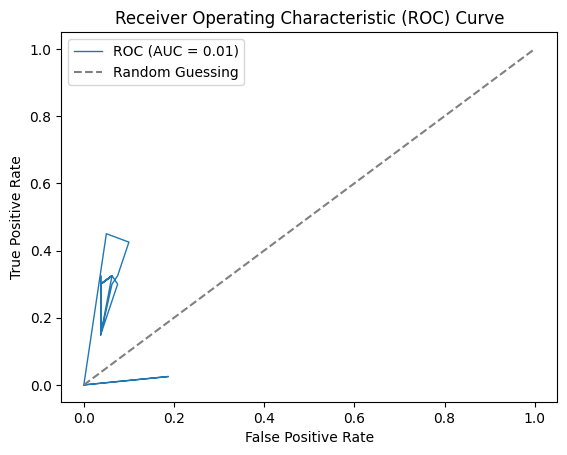

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import random
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max + 1))
    result_path_train = os.path.join(result_path,"train_{}".format(num_max + 1))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_train,exist_ok=True)
    return result_path_train


# 模型評估指標
def validation_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold_nums):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'
    plt.savefig(os.path.join(result_path,'confusion_matrix_fold'+str(fold_nums + 1)+'.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold_nums):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'
    plt.savefig(os.path.join(result_path,'Roc_curve'+str(fold_nums + 1)+'.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(result_path,parameter,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold_nums):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(result_path, 'csv_record')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(result_path + '/csv_record/epoch_fold'+str(fold_nums + 1)+'.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time','num_fold'])
        writer.writerow(parameter)
        writer.writerow('')
        writer.writerow(['Epoch','train_loss','train_acc','val_loss','val_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(train_loss_list[epoch], 4),
                            round(train_acc_list[epoch].item(), 4),
                            round(val_loss_list[epoch], 4),
                            round(val_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong_predict:',fold_wrong_predict])
    print('CSV output Sucessfully')

def print_filename_in_txt(train_loader, valid_loader, result_path, fold_num):
    # Initialize empty lists to store filenames
    train_filenames = []
    valid_filenames = []

    # Iterate over the training dataset
    for batch_idx, (data, target, filename) in enumerate(train_loader):
        # Append the filename to the list
        train_filenames.extend(filename)

    # Iterate over the validation dataset
    for batch_idx, (data, target, filename) in enumerate(valid_loader):
        # Append the filename to the list
        valid_filenames.extend(filename)

    # Create the 'file_name_record' directory if it doesn't exist
    file_record_dir = os.path.join(result_path, 'file_name_record')
    if not os.path.exists(file_record_dir):
        os.makedirs(file_record_dir)

    # Save the training filenames as a text file
    with open(result_path + '/file_name_record/train_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in train_filenames:
            file.write(filename + '\n')

    # Save the validation filenames as a text file
    with open(result_path + '/file_name_record/valid_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in valid_filenames:
            file.write(filename + '\n')

    print(f"Filenames saved in {result_path}/train_filenames.txt and {result_path}/valid_filenames.txt")

def calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, fold_nums, result_path):
    # Calculate averages
    avg_train_acc = sum(avg_train_acc_list) / fold_nums
    avg_val_acc = sum(avg_val_acc_list) / fold_nums
    avg_recall = sum(avg_recall_list) / fold_nums
    avg_precision = sum(avg_precision_list) / fold_nums
    avg_f1_score = sum(avg_f1_score_list) / fold_nums
    avg_TPR = sum(avg_TPR_list) / fold_nums
    avg_FPR = sum(avg_FPR_list) / fold_nums

    # Save averages to a text file
    with open(result_path + '/Average.txt', 'w') as file:
        file.write(f"Avg Train Accuracy: {avg_train_acc}\n")
        file.write(f"Avg Validation Accuracy: {avg_val_acc}\n")
        file.write(f"Avg Recall: {avg_recall}\n")
        file.write(f"Avg Precision: {avg_precision}\n")
        file.write(f"Avg F1 Score: {avg_f1_score}\n")
        file.write(f"Avg TPR: {avg_TPR}\n")
        file.write(f"Avg FPR: {avg_FPR}\n")

    print(f"Averages saved to {result_path}")

def train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,num_fold):
    #超參數設定
    batch_size = 52
    learning_rate = 0.001
    num_epochs = 50
    num_classes = 2
    num_folds = num_fold
    start_time = datetime.now()
    end_time = 0
    num_argumentation = 20
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    train_normal_dataset = MyDataset(train_normal_tensor_path)
    train_abnormal_dataset = MyDataset(train_abnormal_tensor_path)
    # Combine the datasets
    train_datasets = CombinedDataset(train_normal_dataset,train_abnormal_dataset)

    # Create the k-fold cross-validation object
    kfold = KFold(n_splits=num_folds)

    #印出資料集大小
    print("train dataset's size : " + str(len(train_datasets)))

    #創建模型
    model = models.resnet152(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    # make dir to save the training outcome
    result_path = mkdir_outcome(result_path)

    avg_train_acc_list = []
    avg_val_acc_list = []
    avg_recall_list = []
    avg_precision_list = []
    avg_f1_score_list = []
    avg_TPR_list = []
    avg_FPR_list = []

    files = []
    file_names = os.listdir(normal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    file_names = os.listdir(abnormal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    random.shuffle(files)

    torch.save(model.state_dict(),os.path.join(result_path,"resnet152_pre_train.pt"))

    for fold, (train_indices, valid_indices) in enumerate(kfold.split(files)):
        print(f"Fold: {fold+1}")

        #定義損失函數和優化器
        m = nn.Sigmoid()
        criterion = nn.BCELoss()
        # criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        recall_list = []
        precision_list = []
        f1_score_list = []
        TPR_list = []
        FPR_list = []
        fold_wrong_predict = []

        train_files = [files[i] for i in train_indices]
        valid_files = [files[i] for i in valid_indices]

        # 定義用於儲存訓練集和驗證集的檔案名稱的列表
        train_data_files = []
        valid_data_files = []

        # 尋找所有訓練集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in train_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              # 將增強後資料的檔案名稱新增至訓練集檔案名稱列表
              train_data_files.append(augmented_file)

        # 尋找所有驗證集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in valid_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              valid_data_files.append(augmented_file)

        train = []
        valid = []

        # 尋找所有combined_dataset中的樣本索引
        for index, (data, labels, filename) in enumerate(train_datasets):
            # 檢查目前樣本的檔案名稱是否在訓練集檔案名稱清單中
            if filename in train_data_files:
                train.append(index)
            # 檢查目前樣本的檔案名稱是否在驗證集檔案名稱清單中
            elif filename in valid_data_files:
                valid.append(index)

        # Create the train and validation datasets for this fold
        train_dataset = torch.utils.data.Subset(train_datasets, train)
        valid_dataset = torch.utils.data.Subset(train_datasets, valid)


        print("train_dataset : " + str(len(train_dataset)),",valid_dataset : " + str(len(valid_dataset)))

        # Create the data loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4)
        print_filename_in_txt(train_loader,valid_loader,result_path,fold)

        #訓練模型
        for epoch in range(num_epochs):

            train_loss = 0
            train_correct = 0
            train_acc = 0
            val_loss = 0
            val_corrects = 0
            val_acc = 0

            print("result_path:" + str(result_path))

            if(epoch == 0) :
              model.load_state_dict(torch.load(os.path.join(result_path,"resnet152_pre_train.pt")))
              print("Model initialized")
            else :
              model.load_state_dict(torch.load(os.path.join(result_path,"train_fold_"+f'{fold+1}'+".pt")))
              print("Model loaded")


            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Training Progress]: ")
            model.train()
            for inputs, labels, filename in tqdm(train_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(m(outputs),targets.float())
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_correct.double() / len(train_loader.dataset)
            train_loss_list.append(train_loss)

            model.eval()

            print("[Validating Progress]: ")
            wrong_predict = []
            for inputs, labels, filename in tqdm(valid_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(m(outputs),targets.float())
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            val_loss = val_loss / len(valid_loader.dataset)
            val_acc = val_corrects.double() / len(valid_loader.dataset)
            val_loss_list.append(val_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  train_loss: {:<.4f}  -  train_accuracy: {:<.4f} -  val_loss: {:<.4f}  -  val_accuracy: {:<.4f}  -  val_correct: {:<10}'.format(
                epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, val_corrects))
            print('wrong predict : ' + str(wrong_predict))
            torch.save(model.state_dict(),os.path.join(result_path,"train_fold_"+f'{fold+1}'+".pt"))
            print("Model saved")

            # validation index (評估指標)
            precision,recall,f1_score,TPR,FPR = validation_index(conf_matrix)

            # record the outcomes
            val_acc_list.append(val_acc),train_acc_list.append(train_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              avg_train_acc_list.append(train_acc),avg_val_acc_list.append(val_acc),avg_recall_list.append(recall),avg_precision_list.append(precision),avg_f1_score_list.append(f1_score),avg_TPR_list.append(TPR),avg_FPR_list.append(FPR),fold_wrong_predict.append(wrong_predict)

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(result_path,conf_matrix,fold)
        # functioN to show ROC curve
        ROC_Curve(result_path,TPR_list,FPR_list,fold)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time,fold]
        CSV_Output(result_path,param,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold)

    #calculate the average
    calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, num_folds, result_path)

    torch.cuda.empty_cache()


normal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
abnormal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result_resnet152'

train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,5)

#訓練及驗證模型(SEResNet/5-Fold)

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import random
import timm
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max + 1))
    result_path_train = os.path.join(result_path,"train_{}".format(num_max + 1))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_train,exist_ok=True)
    return result_path_train


# 模型評估指標
def validation_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold_nums):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'
    plt.savefig(os.path.join(result_path,'confusion_matrix_fold'+str(fold_nums + 1)+'.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold_nums):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'
    plt.savefig(os.path.join(result_path,'Roc_curve'+str(fold_nums + 1)+'.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(result_path,parameter,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold_nums):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(result_path, 'csv_record')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(result_path + '/csv_record/epoch_fold'+str(fold_nums + 1)+'.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time','num_fold'])
        writer.writerow(parameter)
        writer.writerow('')
        writer.writerow(['Epoch','train_loss','train_acc','val_loss','val_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(train_loss_list[epoch], 4),
                            round(train_acc_list[epoch].item(), 4),
                            round(val_loss_list[epoch], 4),
                            round(val_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong_predict:',fold_wrong_predict])
    print('CSV output Sucessfully')

def print_filename_in_txt(train_loader, valid_loader, result_path, fold_num):
    # Initialize empty lists to store filenames
    train_filenames = []
    valid_filenames = []

    # Iterate over the training dataset
    for batch_idx, (data, target, filename) in enumerate(train_loader):
        # Append the filename to the list
        train_filenames.extend(filename)

    # Iterate over the validation dataset
    for batch_idx, (data, target, filename) in enumerate(valid_loader):
        # Append the filename to the list
        valid_filenames.extend(filename)

    # Create the 'file_name_record' directory if it doesn't exist
    file_record_dir = os.path.join(result_path, 'file_name_record')
    if not os.path.exists(file_record_dir):
        os.makedirs(file_record_dir)

    # Save the training filenames as a text file
    with open(result_path + '/file_name_record/train_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in train_filenames:
            file.write(filename + '\n')

    # Save the validation filenames as a text file
    with open(result_path + '/file_name_record/valid_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in valid_filenames:
            file.write(filename + '\n')

    print(f"Filenames saved in {result_path}/train_filenames.txt and {result_path}/valid_filenames.txt")

def calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, fold_nums, result_path):
    # Calculate averages
    avg_train_acc = sum(avg_train_acc_list) / fold_nums
    avg_val_acc = sum(avg_val_acc_list) / fold_nums
    avg_recall = sum(avg_recall_list) / fold_nums
    avg_precision = sum(avg_precision_list) / fold_nums
    avg_f1_score = sum(avg_f1_score_list) / fold_nums
    avg_TPR = sum(avg_TPR_list) / fold_nums
    avg_FPR = sum(avg_FPR_list) / fold_nums

    # Save averages to a text file
    with open(result_path + '/Average.txt', 'w') as file:
        file.write(f"Avg Train Accuracy: {avg_train_acc}\n")
        file.write(f"Avg Validation Accuracy: {avg_val_acc}\n")
        file.write(f"Avg Recall: {avg_recall}\n")
        file.write(f"Avg Precision: {avg_precision}\n")
        file.write(f"Avg F1 Score: {avg_f1_score}\n")
        file.write(f"Avg TPR: {avg_TPR}\n")
        file.write(f"Avg FPR: {avg_FPR}\n")

    print(f"Averages saved to {result_path}")

def train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,num_fold):
    #超參數設定
    batch_size = 52
    learning_rate = 0.001
    num_epochs = 50
    num_classes = 2
    num_folds = num_fold
    start_time = datetime.now()
    end_time = 0
    num_argumentation = 20
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    train_normal_dataset = MyDataset(train_normal_tensor_path)
    train_abnormal_dataset = MyDataset(train_abnormal_tensor_path)
    # Combine the datasets
    train_datasets = CombinedDataset(train_normal_dataset,train_abnormal_dataset)

    # Create the k-fold cross-validation object
    kfold = KFold(n_splits=num_folds)

    #印出資料集大小
    print("train dataset's size : " + str(len(train_datasets)))

    #創建模型
    # model = models.resnet152(pretrained=True)
    model = timm.create_model('seresnet152d', pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    # make dir to save the training outcome
    result_path = mkdir_outcome(result_path)

    avg_train_acc_list = []
    avg_val_acc_list = []
    avg_recall_list = []
    avg_precision_list = []
    avg_f1_score_list = []
    avg_TPR_list = []
    avg_FPR_list = []

    files = []
    file_names = os.listdir(normal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    file_names = os.listdir(abnormal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    random.shuffle(files)

    torch.save(model.state_dict(),os.path.join(result_path,"seresnet152_pre_train.pt"))

    for fold, (train_indices, valid_indices) in enumerate(kfold.split(files)):
        print(f"Fold: {fold+1}")

        #定義損失函數和優化器
        m = nn.Sigmoid()
        criterion = nn.BCELoss()
        # criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        recall_list = []
        precision_list = []
        f1_score_list = []
        TPR_list = []
        FPR_list = []
        fold_wrong_predict = []

        train_files = [files[i] for i in train_indices]
        valid_files = [files[i] for i in valid_indices]

       # 定義用於儲存訓練集和驗證集的檔案名稱的列表
        train_data_files = []
        valid_data_files = []

        # 尋找所有訓練集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in train_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              # 將增強後資料的檔案名稱新增至訓練集檔案名稱列表
              train_data_files.append(augmented_file)

        # 尋找所有驗證集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in valid_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              valid_data_files.append(augmented_file)

        train = []
        valid = []

        # 尋找所有combined_dataset中的樣本索引
        for index, (data, labels, filename) in enumerate(train_datasets):
            # 檢查目前樣本的檔案名稱是否在訓練集檔案名稱清單中
            if filename in train_data_files:
                train.append(index)
            # 檢查目前樣本的檔案名稱是否在驗證集檔案名稱清單中
            elif filename in valid_data_files:
                valid.append(index)

        # Create the train and validation datasets for this fold
        train_dataset = torch.utils.data.Subset(train_datasets, train)
        valid_dataset = torch.utils.data.Subset(train_datasets, valid)


        print("train_dataset : " + str(len(train_dataset)),",valid_dataset : " + str(len(valid_dataset)))

        # Create the data loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4)
        print_filename_in_txt(train_loader,valid_loader,result_path,fold)

        #訓練模型
        for epoch in range(num_epochs):
            print("epoch:"+f"{epoch+1}")
            train_loss = 0
            train_correct = 0
            train_acc = 0
            val_loss = 0
            val_corrects = 0
            val_acc = 0

            print("result_path:" + str(result_path))

            if(epoch == 0) :
              model.load_state_dict(torch.load(os.path.join(result_path,"seresnet152_pre_train.pt")))
              print("Model initialized")
            else :
              model.load_state_dict(torch.load(os.path.join(result_path,"train"+f'_fold_{fold+1}'+".pt")))
              print("Model loaded")

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Training Progress]: ")
            model.train()
            for inputs, labels, filename in tqdm(train_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(m(outputs),targets.float())
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_correct.double() / len(train_loader.dataset)
            train_loss_list.append(train_loss)

            model.eval()

            print("[Validating Progress]: ")
            wrong_predict = []
            for inputs, labels, filename in tqdm(valid_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(m(outputs),targets.float())
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            val_loss = val_loss / len(valid_loader.dataset)
            val_acc = val_corrects.double() / len(valid_loader.dataset)
            val_loss_list.append(val_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  train_loss: {:<.4f}  -  train_accuracy: {:<.4f} -  val_loss: {:<.4f}  -  val_accuracy: {:<.4f}  -  val_correct: {:<10}'.format(
                epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, val_corrects))
            print('wrong predict : ' + str(wrong_predict))
            torch.save(model.state_dict(),os.path.join(result_path,"train"+f'_fold_{fold+1}'+".pt"))
            print("Model saved")

            # validation index (評估指標)
            precision,recall,f1_score,TPR,FPR = validation_index(conf_matrix)

            # record the outcomes
            val_acc_list.append(val_acc),train_acc_list.append(train_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              torch.cuda.empty_cache()
              avg_train_acc_list.append(train_acc),avg_val_acc_list.append(val_acc),avg_recall_list.append(recall),avg_precision_list.append(precision),avg_f1_score_list.append(f1_score),avg_TPR_list.append(TPR),avg_FPR_list.append(FPR),fold_wrong_predict.append(wrong_predict)

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(result_path,conf_matrix,fold)
        # functioN to show ROC curve
        ROC_Curve(result_path,TPR_list,FPR_list,fold)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time,fold]
        CSV_Output(result_path,param,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold)

    #calculate the average
    calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, num_folds, result_path)

    torch.cuda.empty_cache()


normal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
abnormal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result_seresnet152'

train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,5)

#測試模型(ResNet)

dataset's size : 14


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device used : cuda
test_result_path : /content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/test_2
train_result_path : /content/drive/My Drive/Deep_X_torch/result_resnet152/result_2/train_2
train model:train_fold_1.pt
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: [1/5]  test_loss: 5.4664  -  test_accuracy: 0.5000  -  test_correct: 7         
wrong predicts : [('abnormal_3.pt',), ('abnormal_16.pt',), ('normal_2.pt',), ('abnormal_26.pt',), ('normal_1.pt',), ('abnormal_28.pt',), ('abnormal_8.pt',)]
	      Precision: 0.3750  -  Recall: 0.6000  -  F1 Score: 0.4615
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.77it/s]



Epoch: [2/5]  test_loss: 5.4664  -  test_accuracy: 0.5000  -  test_correct: 7         
wrong predicts : [('normal_2.pt',), ('abnormal_8.pt',), ('abnormal_16.pt',), ('normal_1.pt',), ('abnormal_3.pt',), ('abnormal_28.pt',), ('abnormal_26.pt',)]
	      Precision: 0.3750  -  Recall: 0.6000  -  F1 Score: 0.4615
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.73it/s]



Epoch: [3/5]  test_loss: 5.4664  -  test_accuracy: 0.5000  -  test_correct: 7         
wrong predicts : [('abnormal_8.pt',), ('abnormal_28.pt',), ('abnormal_26.pt',), ('normal_1.pt',), ('abnormal_3.pt',), ('abnormal_16.pt',), ('normal_2.pt',)]
	      Precision: 0.3750  -  Recall: 0.6000  -  F1 Score: 0.4615
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 11.94it/s]



Epoch: [4/5]  test_loss: 5.4664  -  test_accuracy: 0.5000  -  test_correct: 7         
wrong predicts : [('abnormal_16.pt',), ('normal_1.pt',), ('abnormal_3.pt',), ('abnormal_28.pt',), ('normal_2.pt',), ('abnormal_8.pt',), ('abnormal_26.pt',)]
	      Precision: 0.3750  -  Recall: 0.6000  -  F1 Score: 0.4615
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 12.40it/s]



Epoch: [5/5]  test_loss: 5.4664  -  test_accuracy: 0.5000  -  test_correct: 7         
wrong predicts : [('normal_1.pt',), ('abnormal_28.pt',), ('abnormal_3.pt',), ('abnormal_16.pt',), ('abnormal_26.pt',), ('abnormal_8.pt',), ('normal_2.pt',)]
	      Precision: 0.3750  -  Recall: 0.6000  -  F1 Score: 0.4615
Confusion matrix:
[[3 5]
 [2 4]]
CSV output Sucessfully
Confusion matrix:
[[3 5]
 [2 4]]


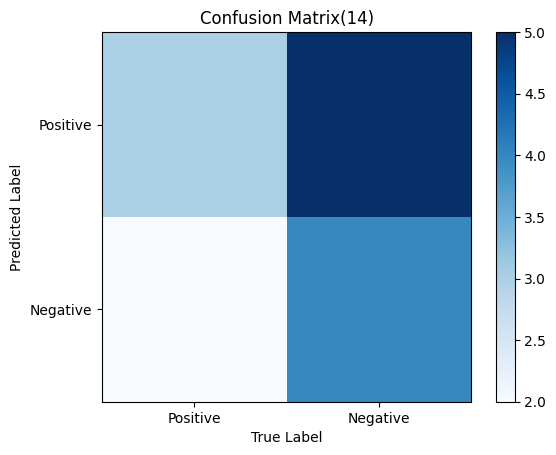

train model:train_fold_2.pt
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 16.77it/s]



Epoch: [1/5]  test_loss: 0.8301  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_1.pt',), ('abnormal_28.pt',), ('abnormal_3.pt',), ('abnormal_16.pt',), ('abnormal_26.pt',), ('abnormal_8.pt',), ('normal_2.pt',), ('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.8000  -  Recall: 0.8000  -  F1 Score: 0.8000
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.24it/s]



Epoch: [2/5]  test_loss: 0.8301  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.8000  -  Recall: 0.8000  -  F1 Score: 0.8000
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 18.07it/s]



Epoch: [3/5]  test_loss: 0.8301  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_2.pt',), ('abnormal_26.pt',)]
	      Precision: 0.8000  -  Recall: 0.8000  -  F1 Score: 0.8000
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 16.02it/s]



Epoch: [4/5]  test_loss: 0.8301  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.8000  -  Recall: 0.8000  -  F1 Score: 0.8000
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.76it/s]



Epoch: [5/5]  test_loss: 0.8301  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.8000  -  Recall: 0.8000  -  F1 Score: 0.8000
Confusion matrix:
[[4 1]
 [1 8]]
CSV output Sucessfully
Confusion matrix:
[[4 1]
 [1 8]]


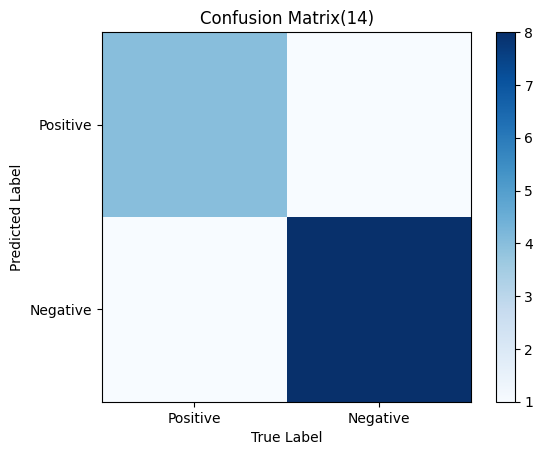

train model:train_fold_3.pt
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 12.02it/s]



Epoch: [1/5]  test_loss: 1.8421  -  test_accuracy: 0.7857  -  test_correct: 11        
wrong predicts : [('abnormal_26.pt',), ('normal_2.pt',), ('normal_6.pt',), ('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 11.02it/s]



Epoch: [2/5]  test_loss: 1.8421  -  test_accuracy: 0.7857  -  test_correct: 11        
wrong predicts : [('normal_6.pt',), ('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 18.02it/s]



Epoch: [3/5]  test_loss: 1.8421  -  test_accuracy: 0.7857  -  test_correct: 11        
wrong predicts : [('normal_6.pt',), ('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 18.08it/s]



Epoch: [4/5]  test_loss: 1.8421  -  test_accuracy: 0.7857  -  test_correct: 11        
wrong predicts : [('normal_6.pt',), ('abnormal_26.pt',), ('normal_2.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.89it/s]



Epoch: [5/5]  test_loss: 1.8421  -  test_accuracy: 0.7857  -  test_correct: 11        
wrong predicts : [('normal_6.pt',), ('normal_2.pt',), ('abnormal_26.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
Confusion matrix:
[[3 1]
 [2 8]]
CSV output Sucessfully
Confusion matrix:
[[3 1]
 [2 8]]


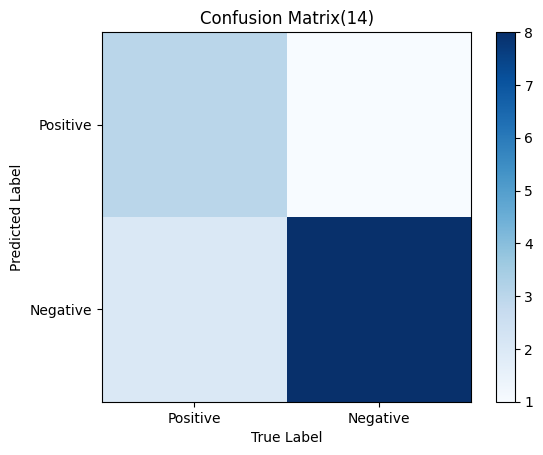

train model:train_fold_4.pt
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 16.92it/s]



Epoch: [1/5]  test_loss: 0.7718  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_6.pt',), ('normal_2.pt',), ('abnormal_26.pt',), ('normal_6.pt',), ('normal_2.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 16.83it/s]



Epoch: [2/5]  test_loss: 0.7718  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_2.pt',), ('normal_6.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.43it/s]



Epoch: [3/5]  test_loss: 0.7718  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_6.pt',), ('normal_2.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 12.91it/s]



Epoch: [4/5]  test_loss: 0.7718  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_2.pt',), ('normal_6.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 14/14 [00:01<00:00, 11.07it/s]



Epoch: [5/5]  test_loss: 0.7718  -  test_accuracy: 0.8571  -  test_correct: 12        
wrong predicts : [('normal_6.pt',), ('normal_2.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
Confusion matrix:
[[3 0]
 [2 9]]
CSV output Sucessfully
Confusion matrix:
[[3 0]
 [2 9]]


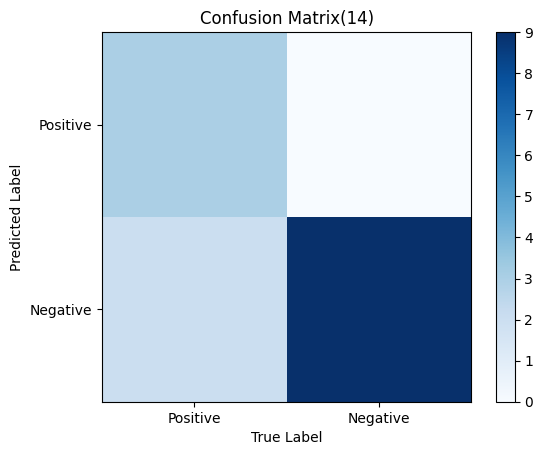

train model:train_fold_5.pt
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.25it/s]



Epoch: [1/5]  test_loss: 1.5053  -  test_accuracy: 0.6429  -  test_correct: 9         
wrong predicts : [('normal_6.pt',), ('normal_2.pt',), ('normal_3.pt',), ('abnormal_8.pt',), ('normal_6.pt',), ('normal_2.pt',), ('abnormal_26.pt',)]
	      Precision: 0.5000  -  Recall: 0.4000  -  F1 Score: 0.4444
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.52it/s]



Epoch: [2/5]  test_loss: 1.5053  -  test_accuracy: 0.6429  -  test_correct: 9         
wrong predicts : [('normal_2.pt',), ('abnormal_26.pt',), ('normal_3.pt',), ('abnormal_8.pt',), ('normal_6.pt',)]
	      Precision: 0.5000  -  Recall: 0.4000  -  F1 Score: 0.4444
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 16.99it/s]



Epoch: [3/5]  test_loss: 1.5053  -  test_accuracy: 0.6429  -  test_correct: 9         
wrong predicts : [('abnormal_26.pt',), ('normal_2.pt',), ('normal_3.pt',), ('abnormal_8.pt',), ('normal_6.pt',)]
	      Precision: 0.5000  -  Recall: 0.4000  -  F1 Score: 0.4444
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 17.22it/s]



Epoch: [4/5]  test_loss: 1.5053  -  test_accuracy: 0.6429  -  test_correct: 9         
wrong predicts : [('normal_3.pt',), ('abnormal_26.pt',), ('normal_2.pt',), ('normal_6.pt',), ('abnormal_8.pt',)]
	      Precision: 0.5000  -  Recall: 0.4000  -  F1 Score: 0.4444
[Test Progress]: 


100%|██████████| 14/14 [00:00<00:00, 18.26it/s]



Epoch: [5/5]  test_loss: 1.5053  -  test_accuracy: 0.6429  -  test_correct: 9         
wrong predicts : [('normal_3.pt',), ('abnormal_8.pt',), ('normal_2.pt',), ('abnormal_26.pt',), ('normal_6.pt',)]
	      Precision: 0.5000  -  Recall: 0.4000  -  F1 Score: 0.4444
Confusion matrix:
[[2 2]
 [3 7]]
CSV output Sucessfully
Confusion matrix:
[[2 2]
 [3 7]]


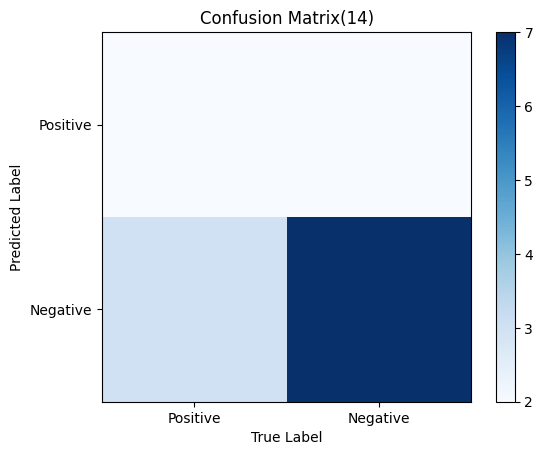

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()

# 找尋最新的訓練結果
def find_train_result_path(result_path):
    file_names = os.listdir(result_path)
    train_result_path = None
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if num > num_max:
                num_max = num

    result_path = os.path.join(result_path,"result_{}".format(num_max))
    train_result_path = os.path.join(result_path,"train_{}".format(num_max))
    return train_result_path


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max))
    result_path_test = os.path.join(result_path,"test_{}".format(num_max))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_test,exist_ok=True)
    return result_path_test


# 模型評估指標
def test_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'
    plt.savefig(os.path.join(result_path,'test_confusion_matrix_'+f'{fold}'+'.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'
    plt.savefig(os.path.join(result_path,'test_Roc_curve_'+f'{fold}'+'.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,fold):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(test_result_path, 'csv_record')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(test_result_path + '/csv_record'+'/test_epoch_'+f'{fold}'+'.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time'])
        writer.writerow(param)
        writer.writerow('')
        writer.writerow(['Epoch','test_loss','test_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(test_loss_list[epoch], 4),
                            round(test_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong predict:',final_wrong_predict])
    print('CSV output Sucessfully')

def test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,fold):
    #超參數設定
    batch_size = 1
    learning_rate = 0.001
    num_epochs = 5
    num_classes = 2
    start_time = datetime.now()
    end_time = 0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    test_normal_dataset = MyDataset(test_normal_tensor_path)
    test_abnormal_dataset = MyDataset(test_abnormal_tensor_path)

    # Combine the datasets
    test_dataset = CombinedDataset(test_normal_dataset,test_abnormal_dataset)

    #印出資料集大小
    print("dataset's size : " + str(len(test_dataset)))

    #創建模型
    model = models.resnet152(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    #定義損失函數和優化器
    m = nn.Sigmoid()
    criterion = nn.BCELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    test_loss_list = []
    test_acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    TPR_list = []
    FPR_list = []
    wrong_predict = []
    final_wrong_predict = []

    # make dir to save the training outcome
    test_result_path = mkdir_outcome(result_path)
    print('test_result_path : ' + str(test_result_path))

    train_result_path = find_train_result_path(result_path)
    print('train_result_path : ' + str(train_result_path))

    for folds in range(1,fold + 1):

        print("train model:"+"train_fold_"+f'{folds}'+".pt")

        # 載入訓練好的模型參數
        model.load_state_dict(torch.load(os.path.join(train_result_path, "train_fold_"+f'{folds}'+".pt")))
        test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)

        #測試模型
        for epoch in range(num_epochs):
            test_loss = 0
            test_corrects = 0
            test_acc = 0
            model.load_state_dict(torch.load(os.path.join(train_result_path, "train_fold_"+f'{folds}'+".pt")))
            model.eval()

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Test Progress]: ")
            for inputs, labels, filename in tqdm(test_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs.to(device))
                    loss = criterion(m(outputs),targets.float())
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            test_loss =  test_loss / len(test_loader.dataset)
            test_acc =  test_corrects.double() / len(test_loader.dataset)
            test_loss_list.append(test_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  test_loss: {:<.4f}  -  test_accuracy: {:<.4f}  -  test_correct: {:<10}'.format(
                epoch+1, num_epochs, test_loss, test_acc, test_corrects))
            print('wrong predicts : ' + str(wrong_predict))


            # teat index (評估指標)
            precision,recall,f1_score,TPR,FPR = test_index(conf_matrix)

            # record the outcomes
            test_acc_list.append(test_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              final_wrong_predict.append(wrong_predict)
            else:
              wrong_predict.clear()

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(test_result_path,conf_matrix,folds)
        # functio to show ROC curve
        ROC_Curve(test_result_path,TPR_list,FPR_list,folds)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time]
        CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds)

        confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
        print("Confusion matrix:")
        print(conf_matrix)
        plt.clf()
        plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Positive', 'Negative'])
        plt.yticks(tick_marks, ['Positive', 'Negative'])
        plt.ylabel('Predicted Label')
        plt.xlabel('True Label')
        plt.title('Confusion Matrix({})'.format(len(test_dataset)))
        plt.show()

        torch.cuda.empty_cache()


test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result_resnet152'

test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,5)



#測試模型(SEResNet)

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import timm
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()

# 找尋最新的訓練結果
def find_train_result_path(result_path):
    file_names = os.listdir(result_path)
    train_result_path = None
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if num > num_max:
                num_max = num

    result_path = os.path.join(result_path,"result_{}".format(num_max))
    train_result_path = os.path.join(result_path,"train_{}".format(num_max))
    return train_result_path


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max))
    result_path_test = os.path.join(result_path,"test_{}".format(num_max))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_test,exist_ok=True)
    return result_path_test


# 模型評估指標
def test_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,folds):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record'+'_fold'+f'{folds}')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'+'_fold'+f'{folds}'
    plt.savefig(os.path.join(result_path,'test_confusion_matrix.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,folds):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record'+'_fold'+f'{folds}')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'+'_fold'+f'{folds}'
    plt.savefig(os.path.join(result_path,'test_Roc_curve.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(test_result_path, 'csv_record'+'_fold'+f'{folds}')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(csv_record_dir + '/test_epoch.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time'])
        writer.writerow(param)
        writer.writerow('')
        writer.writerow(['Epoch','test_loss','test_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(test_loss_list[epoch], 4),
                            round(test_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong predict:',final_wrong_predict])
    print('CSV output Sucessfully')

def test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,fold):
    #超參數設定
    batch_size = 1
    learning_rate = 0.001
    num_epochs = 5
    num_classes = 2
    start_time = datetime.now()
    end_time = 0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    test_normal_dataset = MyDataset(test_normal_tensor_path)
    test_abnormal_dataset = MyDataset(test_abnormal_tensor_path)

    # Combine the datasets
    test_dataset = CombinedDataset(test_normal_dataset,test_abnormal_dataset)

    #印出資料集大小
    print("dataset's size : " + str(len(test_dataset)))

    #創建模型
    # model = models.resnet152(pretrained=False)
    model = timm.create_model('seresnet152d', pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    #定義損失函數和優化器
    m = nn.Sigmoid()
    criterion = nn.BCELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    test_loss_list = []
    test_acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    TPR_list = []
    FPR_list = []
    wrong_predict = []
    final_wrong_predict = []

    # make dir to save the training outcome
    test_result_path = mkdir_outcome(result_path)
    print('test_result_path : ' + str(test_result_path))

    train_result_path = find_train_result_path(result_path)
    print('train_result_path : ' + str(train_result_path))

    for folds in range(1,fold + 1):

        print("train model:"+"train"+f'_fold_{folds}'+".pt")

        # 載入訓練好的模型參數
        model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold_{folds}'+".pt")))
        test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)

        #測試模型
        for epoch in range(num_epochs):
            test_loss = 0
            test_corrects = 0
            test_acc = 0
            model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold_{folds}'+".pt")))
            model.eval()

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Test Progress]: ")
            for inputs, labels, filename in tqdm(test_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs.to(device))
                    loss = criterion(m(outputs),targets.float())
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            test_loss =  test_loss / len(test_loader.dataset)
            test_acc =  test_corrects.double() / len(test_loader.dataset)
            test_loss_list.append(test_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  test_loss: {:<.4f}  -  test_accuracy: {:<.4f}  -  test_correct: {:<10}'.format(
                epoch+1, num_epochs, test_loss, test_acc, test_corrects))
            print('wrong predicts : ' + str(wrong_predict))


            # teat index (評估指標)
            precision,recall,f1_score,TPR,FPR = test_index(conf_matrix)

            # record the outcomes
            test_acc_list.append(test_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              final_wrong_predict.append(wrong_predict)
            else:
              wrong_predict.clear()

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(test_result_path,conf_matrix,folds)
        # functio to show ROC curve
        ROC_Curve(test_result_path,TPR_list,FPR_list,folds)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time]
        CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds)

        confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
        print("Confusion matrix:")
        print(conf_matrix)
        plt.clf()
        plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Positive', 'Negative'])
        plt.yticks(tick_marks, ['Positive', 'Negative'])
        plt.ylabel('Predicted Label')
        plt.xlabel('True Label')
        plt.title('Confusion Matrix({})'.format(len(test_dataset)))
        plt.show()

        torch.cuda.empty_cache()


test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result_seresnet152'

test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,5)



#清除資料

In [ ]:
import os
import torch

def delete_file_under_path(path):
    for root, directories, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

def delete_folder_under_path(path):
    for root, directories, files in os.walk(path, topdown=False):
        for directory in directories:
            folder_path = os.path.join(root, directory)
            os.rmdir(folder_path)

normal_jpg_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.jpg)'
normal_label_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal_label'
abnormal_jpg_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.jpg)'
abnormal_label_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal_label'
processed_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset'
splitted_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset'
tesor_path = '/content/drive/My Drive/Deep_X_torch/tensor'
seresnet_result_path = '/content/drive/My Drive/Deep_X_torch/result_seresnet152/'
resnet_result_path = '/content/drive/My Drive/Deep_X_torch/result_resnet152/'
all_data_dir = '/content/drive/My Drive/Deep_X_torch/all_data'

torch.cuda.empty_cache()

# delete_file_under_path(normal_jpg_path)
# delete_file_under_path(abnormal_jpg_path)
# delete_file_under_path(normal_label_path)
# delete_file_under_path(abnormal_label_path)
# delete_file_under_path(processed_dir)
# delete_file_under_path(splitted_dir)
# delete_file_under_path(all_data_dir)
# delete_file_under_path(tesor_path)

# delete_file_under_path(seresnet_result_path)
# delete_folder_under_path(seresnet_result_path)
# delete_file_under_path(resnet_result_path)
# delete_folder_under_path(resnet_result_path)